In [1]:
import cv2
import cv2 as cv
import imutils
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

# Add code to sys.path
import matplotlib.pyplot as plt 

import sys
sys.path.append('../src')

from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import cv2 as cv
import collections

import dla.src.table_structure_analysis as tsa
import dla.src.xml_utils as xml_utils
from dla.src.image_utils import put_box, put_line
import pytesseract
import numpy as np

from statistics import mean

import importlib
import glosat_utils
importlib.reload(glosat_utils)

from glosat_utils import *

config_file = '/data/glosat/glosat_table_dataset/dla/config/cascadeRCNN.py'
table_checkpoint_file = '/data/glosat/glosat_table_dataset/models/model_fulltables_only_GloSAT.pth'
cell_checkpoint_file = '/data/glosat/glosat_table_dataset/models/model_coarsecell_GloSAT.pth'

model = init_detector(config_file, table_checkpoint_file, device='cuda:0')
cell_model = init_detector(config_file, cell_checkpoint_file, device='cuda:0')

THRESHOLD = 0.5
CLASSES = ("table_body","cell","full_table","header","heading")
color = 255

restricted_colors = [LABEL_TO_COLOR_MAPPING[l] for l in restricted_labels]
label_idx_color_mapping = {restricted_labels.index(l) + 1: c for l, c in zip(restricted_labels, restricted_colors)}

directory = '/data/glosat/Code-Git/docformer/dataset/Finetuning/test/images'
outdirectory = '/data/glosat/Code-Git/docExtractor-master/demo/output_files'

[2022-07-28 11:10:34] Model res_unet18 initialisated with norm_layer=InstanceNorm2d({'momentum': 0.1, 'affine': True, 'track_running_stats': False}) and kwargs {'encoder_name': 'resnet18', 'reduced_layers': False, 'no_maxpool': False, 'conv_as_maxpool': True, 'use_deconv': True, 'use_upcatconv': False, 'use_conv1x1': False, 'pretrained_encoder': False}


/data/glosat/glosat_table_dataset/mmdetection/mmdet/apis/inference.py:40: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [2]:
files = os.listdir(directory)
cell_cordinates_info = {}
filename = '59.jpg'

In [3]:
img_path = f'{directory}/{filename}'
img = cv.imread(img_path)
img, h, w, c = image_preprocessing(img)
masks, blend_img = find_text_region(img, label_idx_color_mapping, normalize)

blend_img.save(f'{outdirectory}/{filename}_text_region.jpg')

In [4]:
cells_by_image = collections.defaultdict(list)
cells_by_image[filename] = detect_cell_pretrained(cell_model,img)

full_tables, tables = detect_table_region(model,img)

/home/gyanendro/.local/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [5]:
ori_correct_cells, exclude_cells = classify_single_cell(cells_by_image[filename], masks[1])
table_cells = get_x_y_initial(tables, cells_by_image[filename], THRESHOLD)
cell_cordinates, average_cordinates = get_coordinates(table_cells,0.7)

In [6]:
x_avg = []
y_avg = []
for xa,ya in average_cordinates:
    x_avg.append(xa)
    y_avg.append(ya)
    
average_cordinates.append((mean(x_avg),mean(y_avg)))

In [7]:
# def find_overlapped_cell(corrected_cells, cells_pred, average_cordinates):
#     new_cells_pred = []
#     for i, box in enumerate(cells_pred):
#         count=0       
#         xi = abs(box[2]-box[0])
#         yi = abs(box[3]-box[1])
        
#         for j, cells in enumerate(corrected_cells): 
#             xj = abs(cells[2]-cells[0])
#             yj = abs(cells[3]-cells[1])
            
#             if check_cell(cells, average_cordinates) and check_cell(box, average_cordinates) :
#                 if tsa.how_much_contained(cells,box)>0.5:
#                     count+=1
#                     if xj < xi:
#                         cells[0] = box[0]  
#                         cells[2] = box[2]
#                     if yj < yi:
#                         cells[1] = box[1]  
#                         cells[3] = box[3]
#                     corrected_cells[j] = cells
#                     break
                    
#                 elif tsa.how_much_contained(box, cells)>0.5:
#                     count+=1
#                     if xj < xi:
#                         cells[0] = box[0]  
#                         cells[2] = box[2]
#                     if yj < yi:
#                         cells[1] = box[1]  
#                         cells[3] = box[3]
                        
#                     corrected_cells[j] = cells
#                     break
                    
#         if count==0:
#             new_cells_pred.append(box)
#     return new_cells_pred, corrected_cells

In [8]:
new_ori_correct_cells = []
for cell in ori_correct_cells:
    idx, score = get_table_coord_initial(cell, tables)
    if score>0.5:
        cell[4] = idx
        cell = list(map(int, cell))
        new_cell, changed = correct_boundary_single_cell(cell, masks[1], tables[idx], average_cordinates[-1], 0.7)
    new_ori_correct_cells.append(new_cell+[idx])

ori_correct_cells =  list(new_ori_correct_cells)

In [9]:
possible_cells, exclude_cells_pred = generate_cells(masks[1], tables, cell_cordinates, average_cordinates)
# possible_cells = find_overlapped_cell(ori_correct_cells, possible_cells, average_cordinates)

if len(possible_cells)>0:
    correct_cells, blank_cells, exclude_cells = classify_cells(possible_cells, masks[1], average_cordinates) 
else:
    correct_cells, blank_cells, exclude_cells = classify_cells(ori_correct_cells, masks[1], average_cordinates)

In [10]:
correct_cells, ori_correct_cells = find_overlapped_cell(ori_correct_cells, correct_cells, average_cordinates)
considered_cells = ori_correct_cells+correct_cells

not_ovellapped_blank_cells_pred, considered_cells = find_overlapped_cell(considered_cells, blank_cells, average_cordinates)
considered_cells = considered_cells+not_ovellapped_blank_cells_pred

not_ovellapped_exclude_cells_pred, considered_cells = find_overlapped_cell(considered_cells, exclude_cells+exclude_cells_pred, average_cordinates)

### Initial cell generation

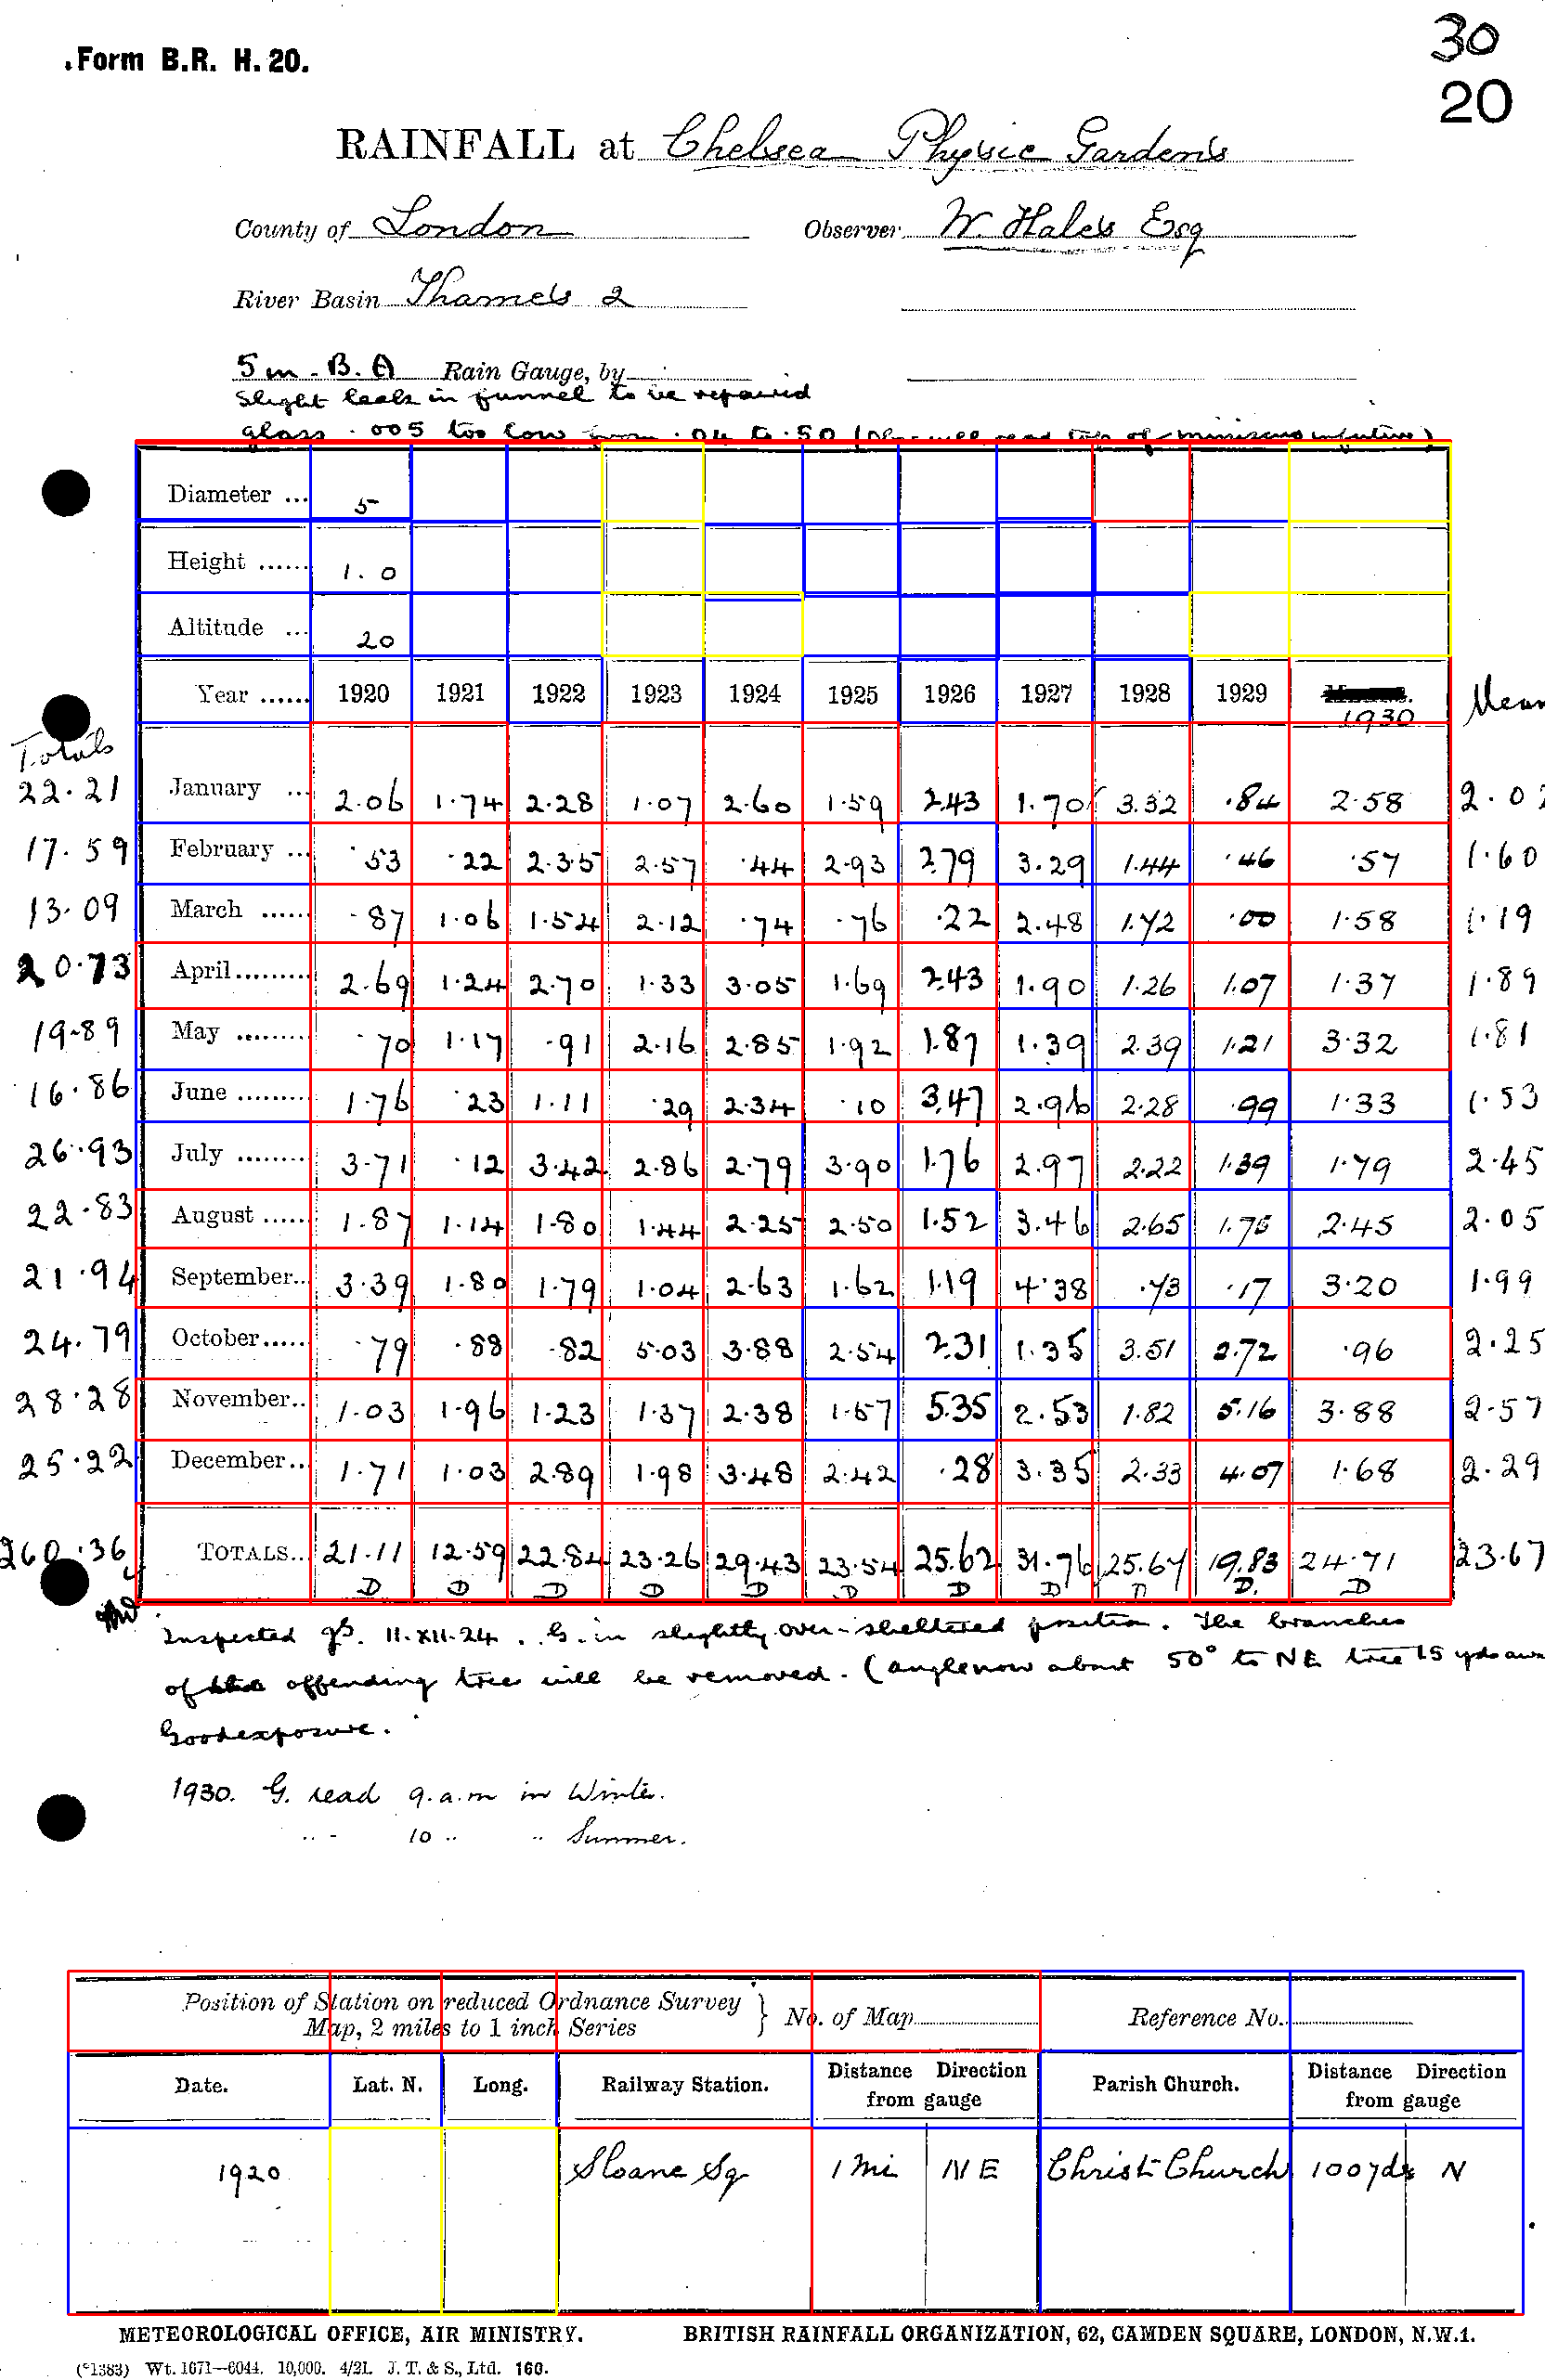

In [11]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in considered_cells:
    put_box(image,box,(0,0,color)) # Blue

for box in not_ovellapped_exclude_cells_pred:
    put_box(image,box,(color,0,0)) # Red

# for box in correct_cells:
#     put_box(image,box,(0,color,0)) # Green

for box in not_ovellapped_blank_cells_pred:
    put_box(image,box,(color,color,0)) # Yellow

im_pil = Image.fromarray(image)
im_pil  

In [12]:
all_valid_cells = considered_cells

In [116]:
# def classify_error_cells(new_excluded_cells_pred, tables, mask, average_cordinates,pc):
#     new_corrected_excluded_cells = []
#     not_corrected_excluded_cells = []

#     for cell in new_excluded_cells_pred:
#         tid = cell[4]
#         changed = [0]*4
        
#         if check_cell(cell,average_cordinates):
#             new_cell, changed = correct_boundary_single_cell(cell, mask, tables[tid], average_cordinates[-1], 1-pc)

#             x_avg, y_avg = average_cordinates[-1]

#             if abs(new_cell[0]-new_cell[2])<x_avg*pc or abs(new_cell[1]-new_cell[3])<y_avg*pc:
#                 not_corrected_excluded_cells.append(new_cell+[tid]+[changed])
#             elif sum(changed)==4 and 5 not in changed:
#                 new_corrected_excluded_cells.append(new_cell+[tid]+[changed])
#             elif sum(changed)> 5 and 0 not in changed:
#                 new_corrected_excluded_cells.append(new_cell+[tid]+[changed])
#             else:
#                 not_corrected_excluded_cells.append(new_cell+[tid]+[changed])

#         else:
#             not_corrected_excluded_cells.append(cell+[changed])
    
#     return new_corrected_excluded_cells, not_corrected_excluded_cells

In [13]:
if len(not_ovellapped_exclude_cells_pred)>2:
    corrected_cells_new, error_cells = classify_error_cells(not_ovellapped_exclude_cells_pred, tables, masks[1], average_cordinates,0.7)
    corrected_cells_new, blank_cells_new, exclude_cells_new = classify_cells(corrected_cells_new, masks[1], average_cordinates)
else:
    corrected_cells_new = []
    blank_cells_new = []
    exclude_cells_new = []
    error_cells = []
    
exclude_cells_new, corrected_cells_new = find_overlapped_cell(corrected_cells_new, not_ovellapped_exclude_cells_pred, average_cordinates)

### Plot all valid cells

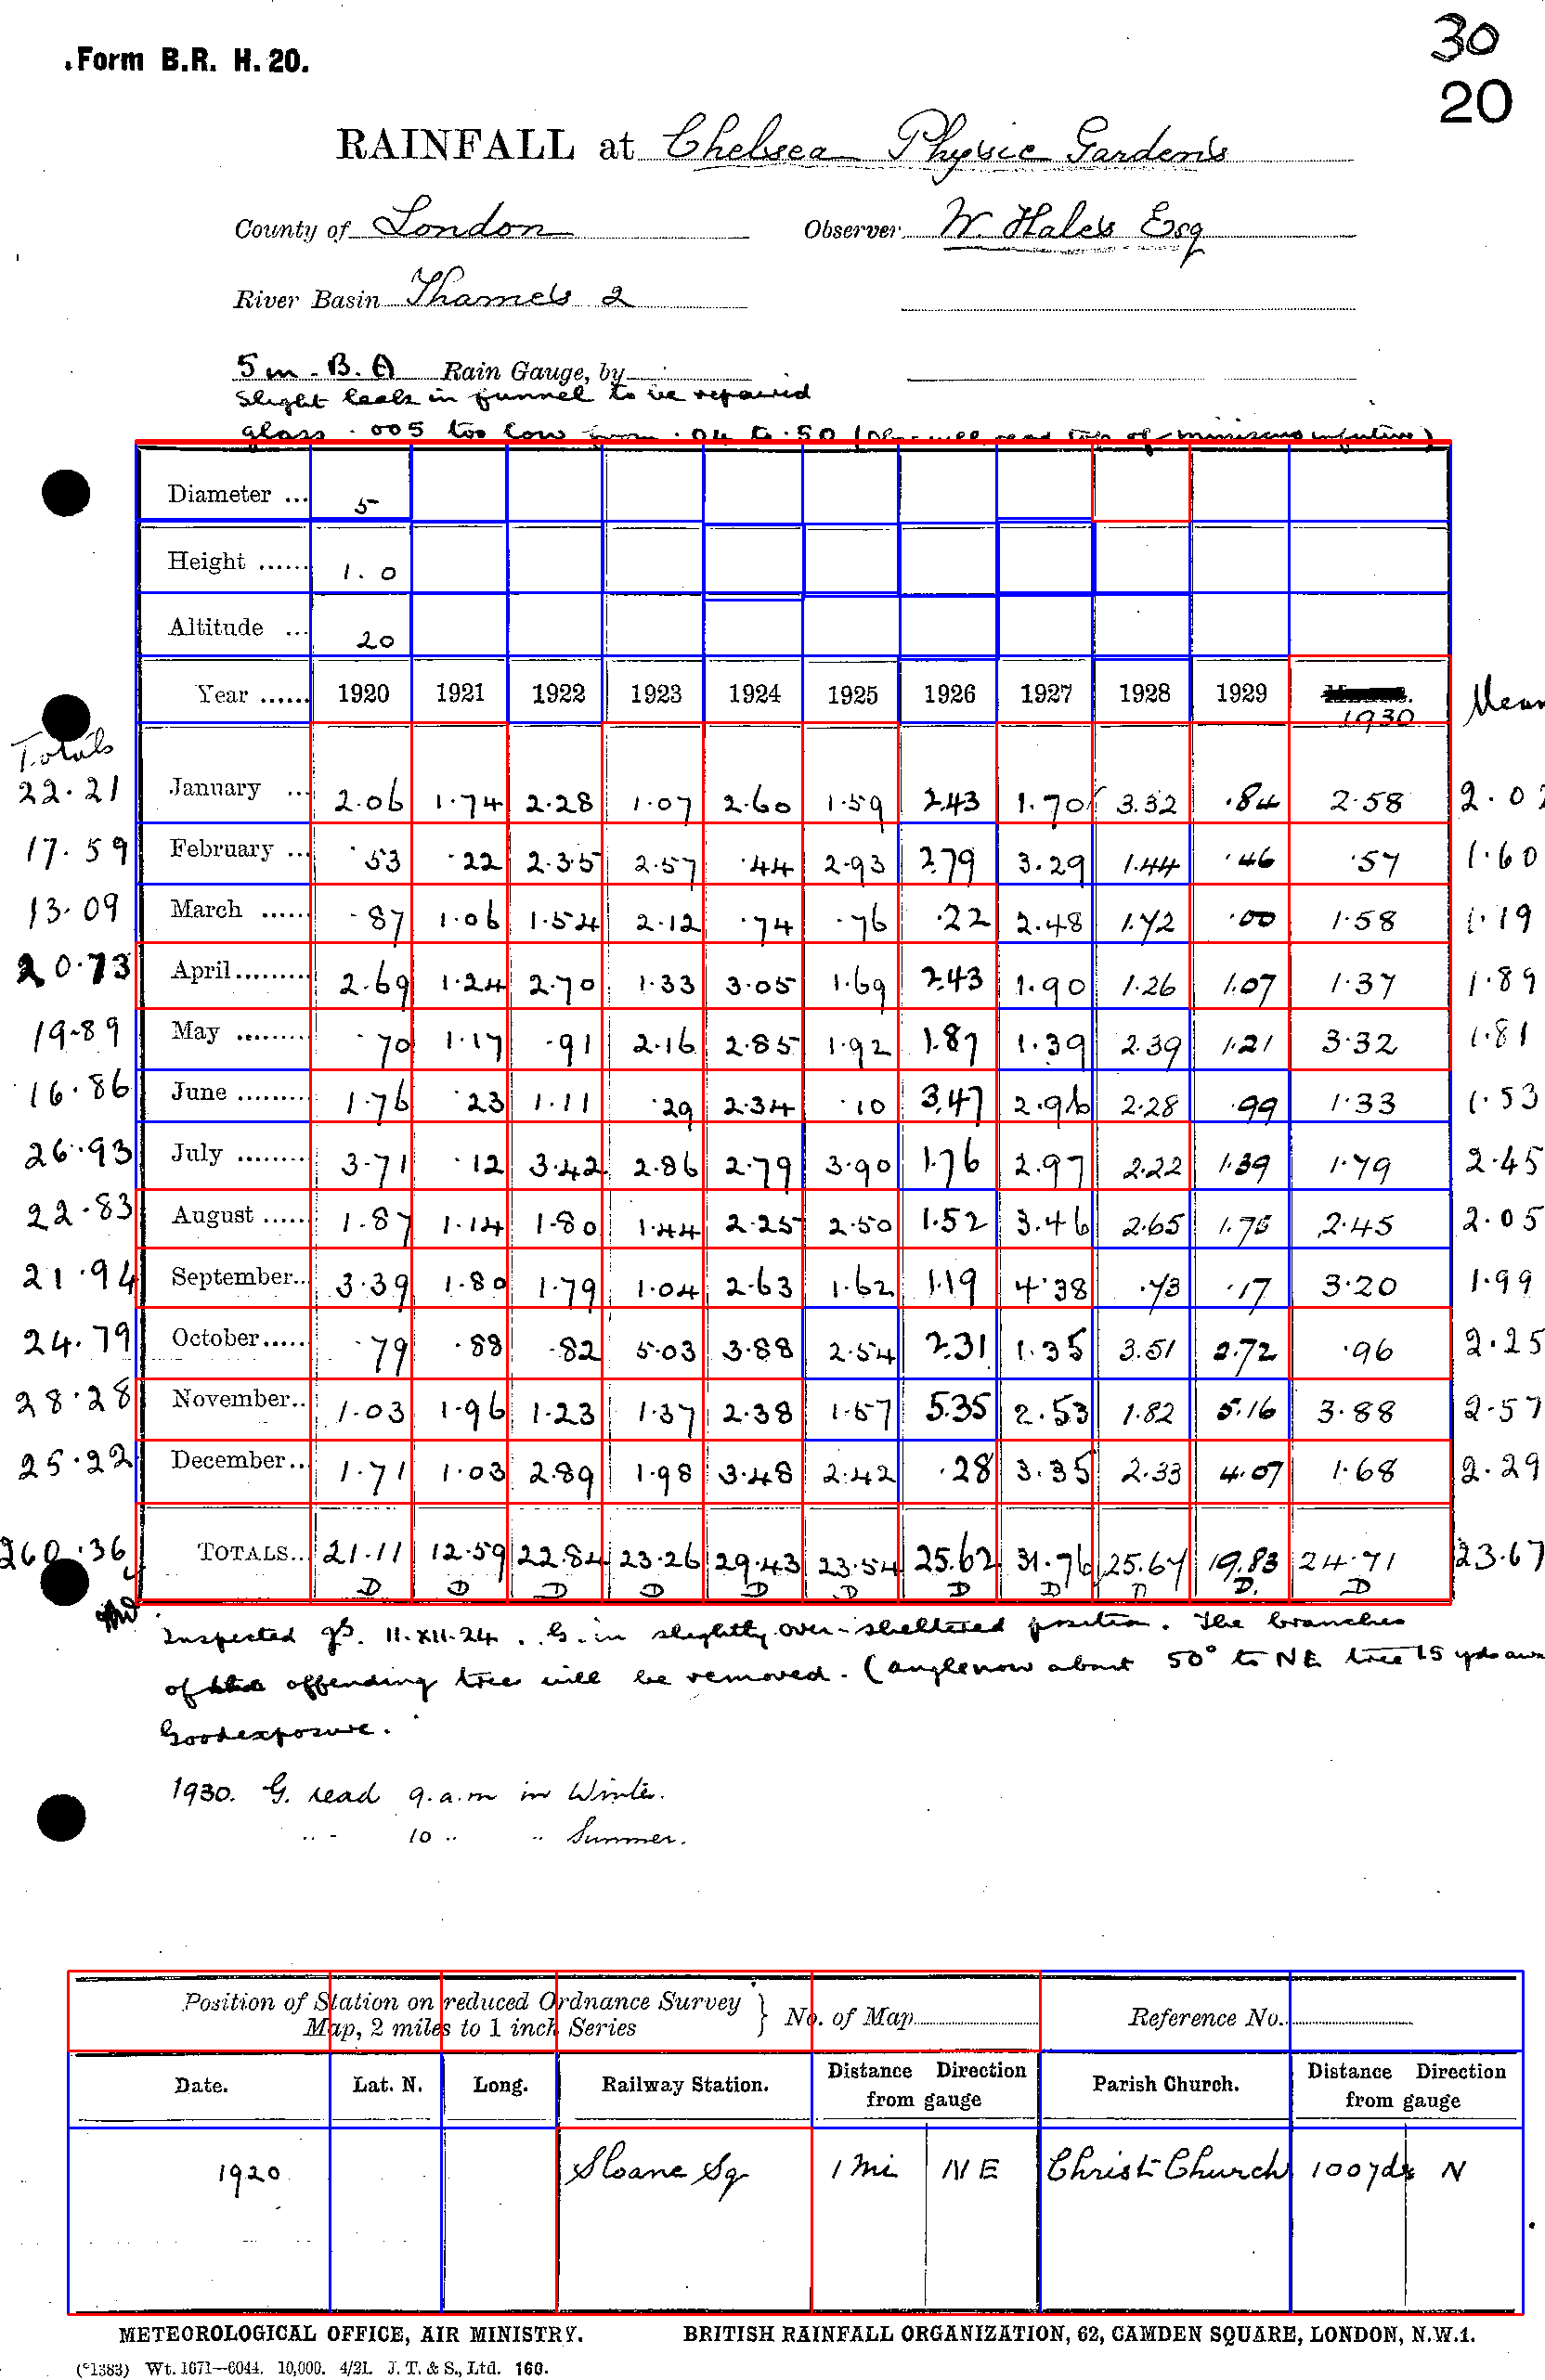

In [14]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in considered_cells:
    put_box(image,box,(0,0,color)) # Blue

for box in corrected_cells_new:
    put_box(image,box,(0,color,0)) # Green

for box in exclude_cells_new:
    put_box(image,box,(color,0,0)) # red

for box in blank_cells_new:
    put_box(image,box,(color,color,0)) # yellow

im_pil = Image.fromarray(image)
# im_pil.save(f"{filename}_temp_cell_classification_generation.jpg")
im_pil  

In [15]:
all_valid_cells += corrected_cells_new

### Generate cells from the valid cells

In [14]:
# def get_x_y_v2(tables, average_cordinates, cells, pc):   
#     segment_headers =  False
#     table_cells = []
#     for idx, table in enumerate(tables):
#         cells_x = []
#         cells_y = []
#         for box in cells:  #cells_by_image[img_path]: #
#             cell = box[0:4] #(x0,y0,x1,y1)
            
#             if tsa.how_much_contained(cell,table)>0.5:
#                 cells_x.append(cell[0])
#                 cells_x.append(cell[2])
#                 cells_y.append(cell[1])
#                 cells_y.append(cell[3])
#             else:
#                 pass
        
#         x_avg, y_avg = average_cordinates[idx]
# #         cells_x = find_coordinates(cells_x, x_avg, pc)
# #         cells_y = find_coordinates(cells_y, y_avg, pc)
        
#         table_cells.append([cells_x, cells_y])
#     return table_cells  

# def avg_coordinates_v2(cells_cord):
#     cells_x = list(cells_cord)
#     new_x = []   
#     avg = mean([j-i for i,j in zip(cells_x[0:-1],cells_x[1:])])/3  ###compare with 1/3 size of the average cell size
#     print(cells_x)
#     while len(cells_x)>0:
#         x=cells_x.pop()
#         if len(new_x)>0:
#             print('----',x, new_x[-1], abs(x - new_x[-1]), avg)
        
#         if len(new_x)>0 and abs(x - new_x[-1])<avg:  # last insert is near to current value then skip current value pop out
#             new_x[-1] = int((x + new_x[-1])/2)
#         else:
#             if len(cells_x)>0:
#                 if abs(x - cells_x[-1])<avg:
#                     n_c = int((x + cells_x[-1])/2)
#                     x = cells_x.pop()
#                     new_x.append(n_c)
#                 else:
#                     new_x.append(x)
#             else:
#                 new_x.append(x)

#     new_x = [i for i in reversed(new_x)] 
#     return new_x

# def get_coordinates(table_cells, pc):    
#     cell_cordinates = []
#     new_x = []
#     new_y = []
#     for cells_x, cells_y in table_cells:
#         cells_x = list(map(int, cells_x))
#         cells_x = list(set(cells_x))
#         values, _ = torch.Tensor(cells_x).int().sort()
#         cells_x = values.tolist()    

#         cells_y = list(map(int, cells_y))
#         cells_y = list(set(cells_y))
#         values, _ = torch.Tensor(cells_y).int().sort()
#         cells_y = values.tolist()

#         new_y = list(cells_y)
#         new_y = avg_coordinates_v2(new_y)

#         new_x = list(cells_x)
#         new_x = avg_coordinates_v2(new_x)
#         cell_cordinates.append([new_x,new_y])
        
#     average_cordinates = []
#     for tid, (x_cords, y_cords) in enumerate(cell_cordinates):

#         x_size = [abs(i-j) for i, j in zip(x_cords[0:-1], x_cords[1:])]
#         y_size = [abs(i-j) for i, j in zip(y_cords[0:-1], y_cords[1:])]

#         x_avg = average_list(x_size)
#         y_avg = average_list(y_size)

#         average_cordinates.append((x_avg, y_avg))
        
#     new_cell_cordinates = []
#     for idx, coords in enumerate(cell_cordinates):
#         x_coords, y_coords = coords
#         new_x_coords = avg_coordinates(x_coords)
#         new_y_coords = avg_coordinates(y_coords)

#         new_cell_cordinates.append([new_x_coords, new_y_coords])
    
#     return new_cell_cordinates, average_cordinates

In [ ]:
# coords = [474, 477, 556, 558, 559, 561, 562, 563, 564, 565, 567, 568, 634, 636, 637, 638, 639, 640, 641, 642, 643, 644, 646, 648, 702, 704, 706, 707, 709, 710, 711, 712, 713, 714, 715, 773, 774, 775, 776, 777, 778, 782, 783, 785, 881, 883, 886, 891, 947, 952, 957, 1010, 1015, 1020, 1022, 1026, 1081, 1084, 1086, 1091, 1092, 1146, 1147, 1152, 1157, 1158, 1203, 1209, 1212, 1216, 1219, 1276, 1281, 1282, 1283, 1285, 1294, 1295, 1339, 1342, 1343, 1344, 1349, 1356, 1403, 1405, 1408, 1413, 1414, 1415, 1479, 1480, 1482, 1485, 1490, 1492, 1493, 1538, 1539, 1542, 1544, 1549, 1553, 1615, 1616, 1619, 1624, 1728]
# avg_coordinates_v2(coords)

In [16]:
table_cells = get_x_y(tables, all_valid_cells) 
cell_cordinates, average_cordinates = get_coordinates(table_cells,0.7)

In [17]:
possible_cells, exclude_cells_pred = generate_cells(masks[1], tables, cell_cordinates, average_cordinates)
possible_cells, all_valid_cells = find_overlapped_cell(all_valid_cells, possible_cells, average_cordinates)

if len(possible_cells)>0:
    correct_cells, blank_cells, exclude_cells = classify_cells(possible_cells, masks[1], average_cordinates) 
else:
    correct_cells, blank_cells, exclude_cells = classify_cells(all_valid_cells, masks[1], average_cordinates)

In [18]:
correct_cells, all_valid_cells = find_overlapped_cell(all_valid_cells, correct_cells, average_cordinates)
blank_cells, all_valid_cells = find_overlapped_cell(all_valid_cells, blank_cells, average_cordinates)
exclude_cells, all_valid_cells = find_overlapped_cell(all_valid_cells, exclude_cells, average_cordinates)

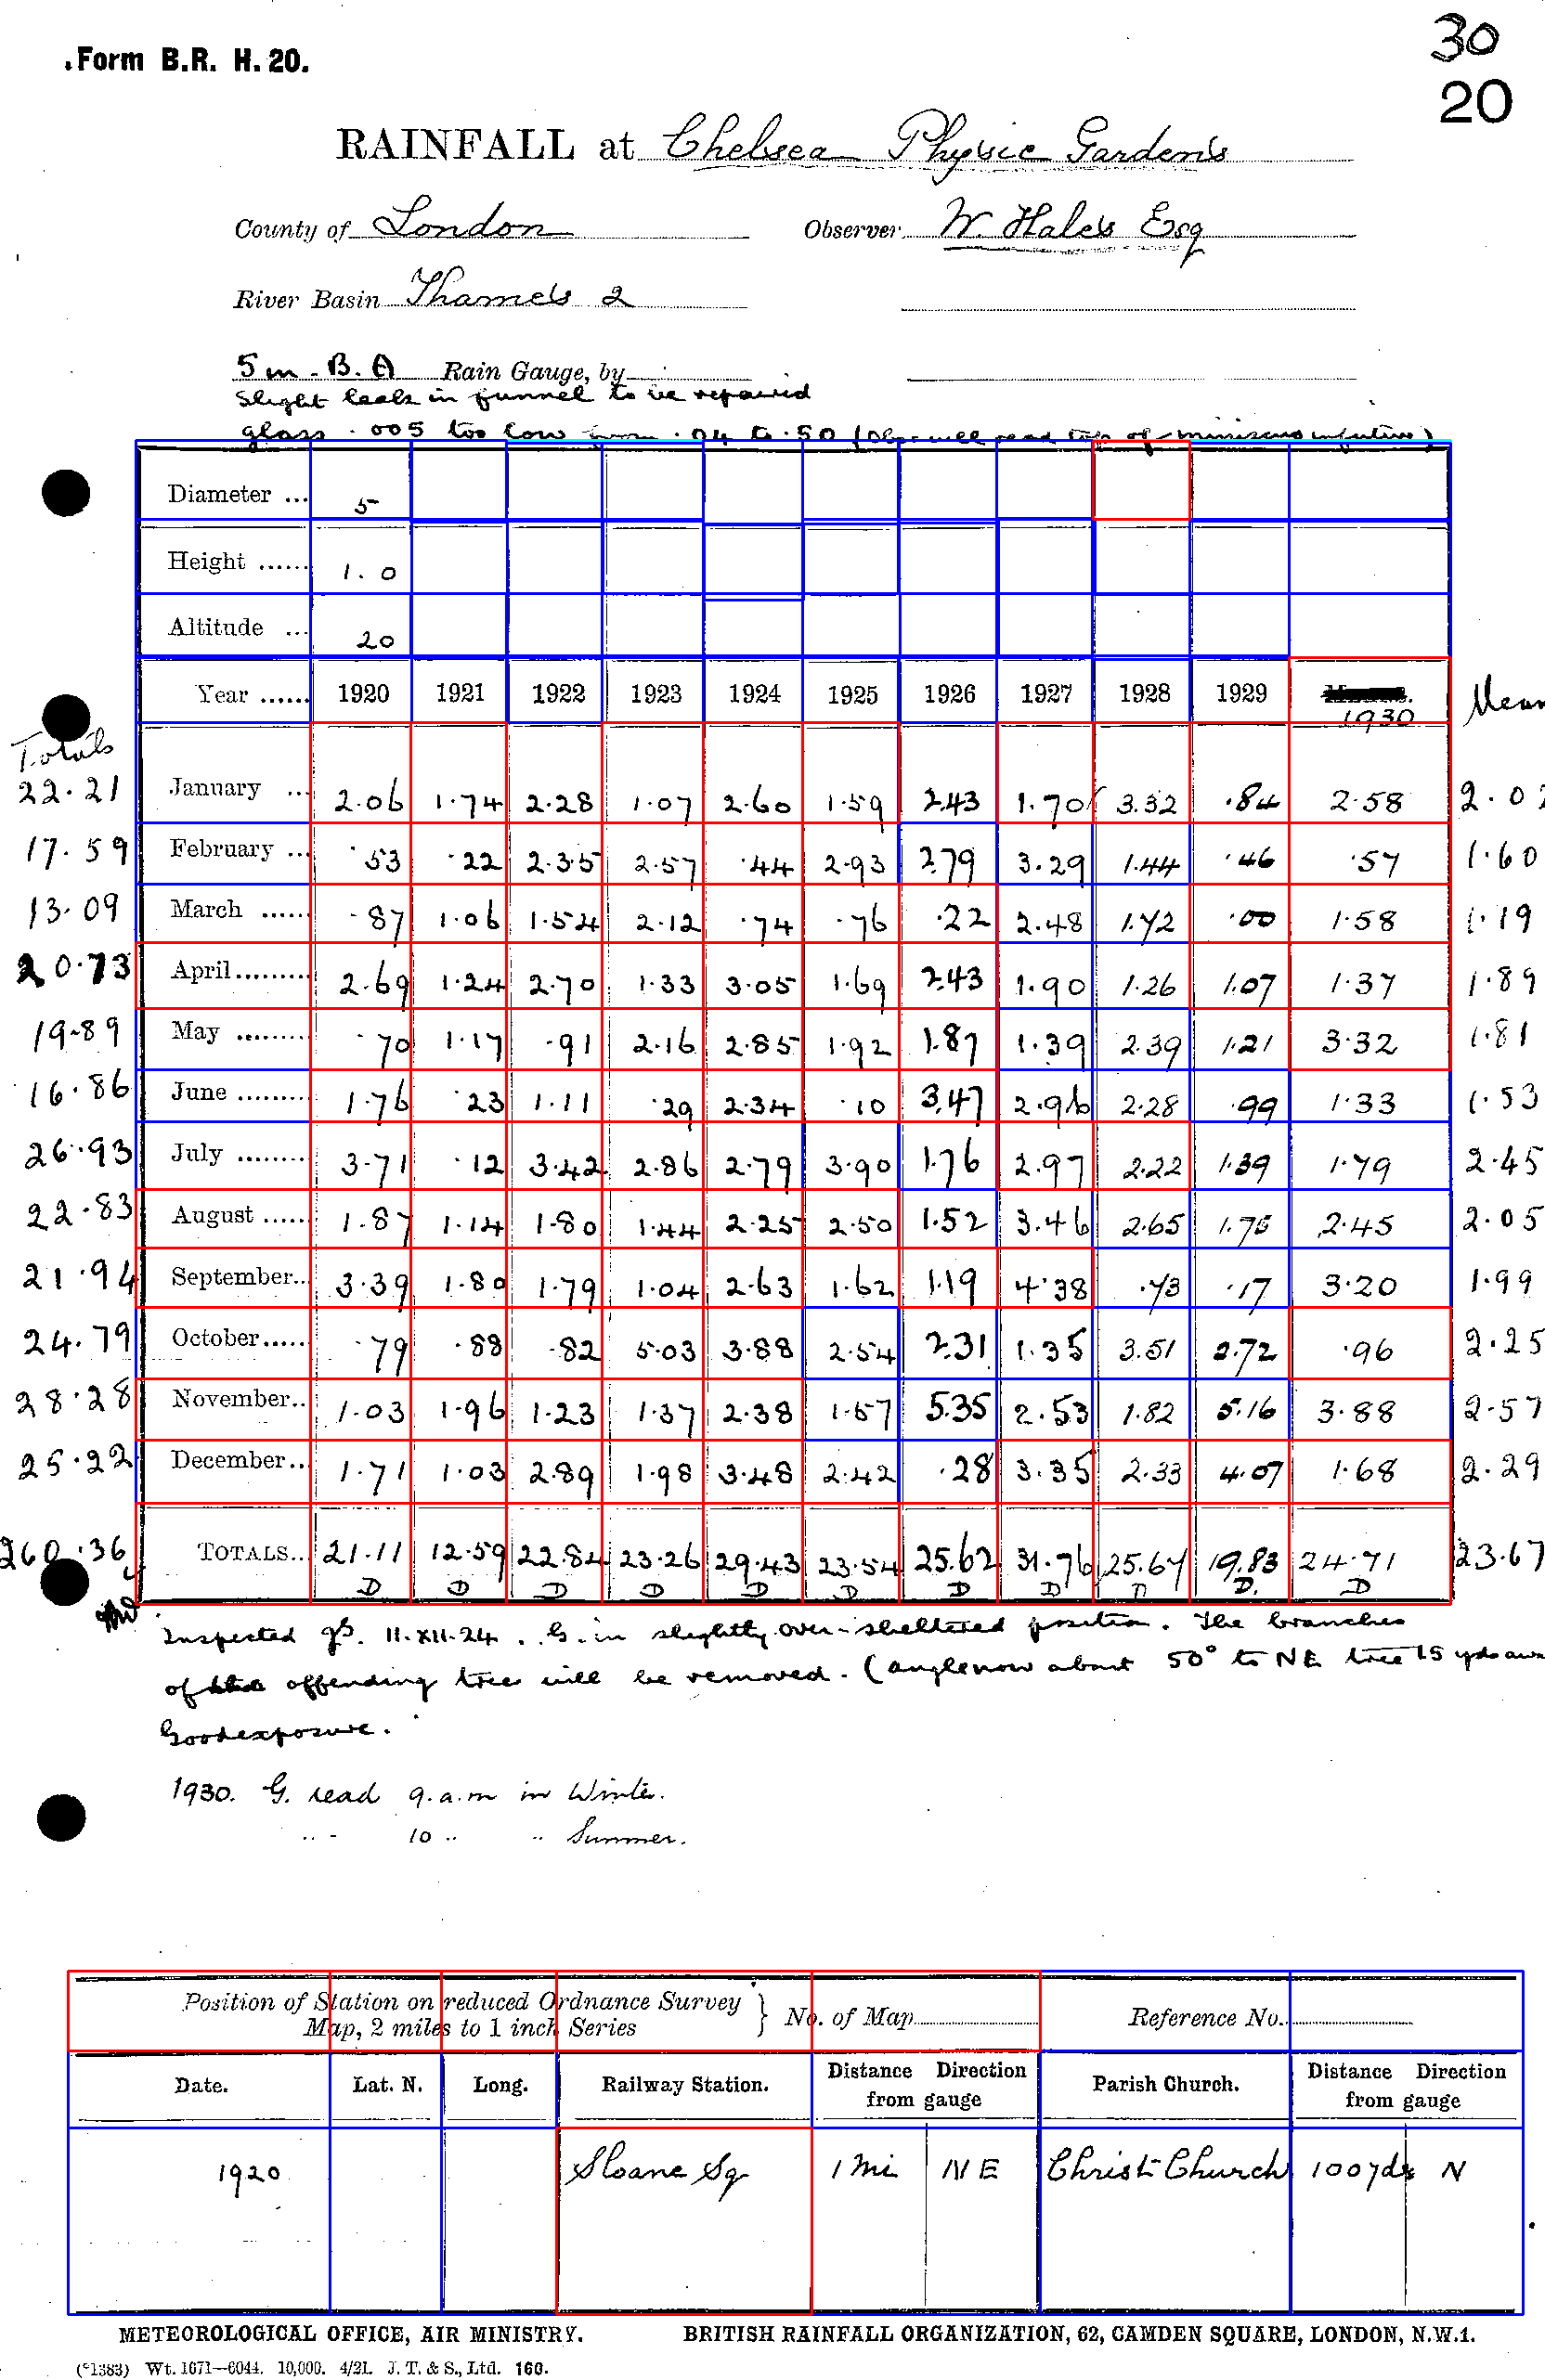

In [19]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in all_valid_cells:
    put_box(image,box,(0,0,color)) # Blue

for box in correct_cells:
    put_box(image,box,(0,color,0)) # Green

for box in exclude_cells:
    put_box(image,box,(color,0,0)) # Red

# for box in new_corrected_excluded_cells:
#     put_box(image,box,(color,0,color)) # Pink

for box in blank_cells:
    put_box(image,box,(color,color,0)) # Yellow

im_pil = Image.fromarray(image)
# im_pil.save(f"{filename}_temp_cell_classification_generation.jpg")
im_pil  

In [20]:
new_valid_cells = correct_cells+blank_cells
new_valid_cells, all_valid_cells = find_overlapped_cell(all_valid_cells, new_valid_cells, average_cordinates)
all_valid_cells += new_valid_cells

In [21]:
not_corrected_excluded_cells, all_valid_cells = find_overlapped_cell(all_valid_cells, exclude_cells, average_cordinates)

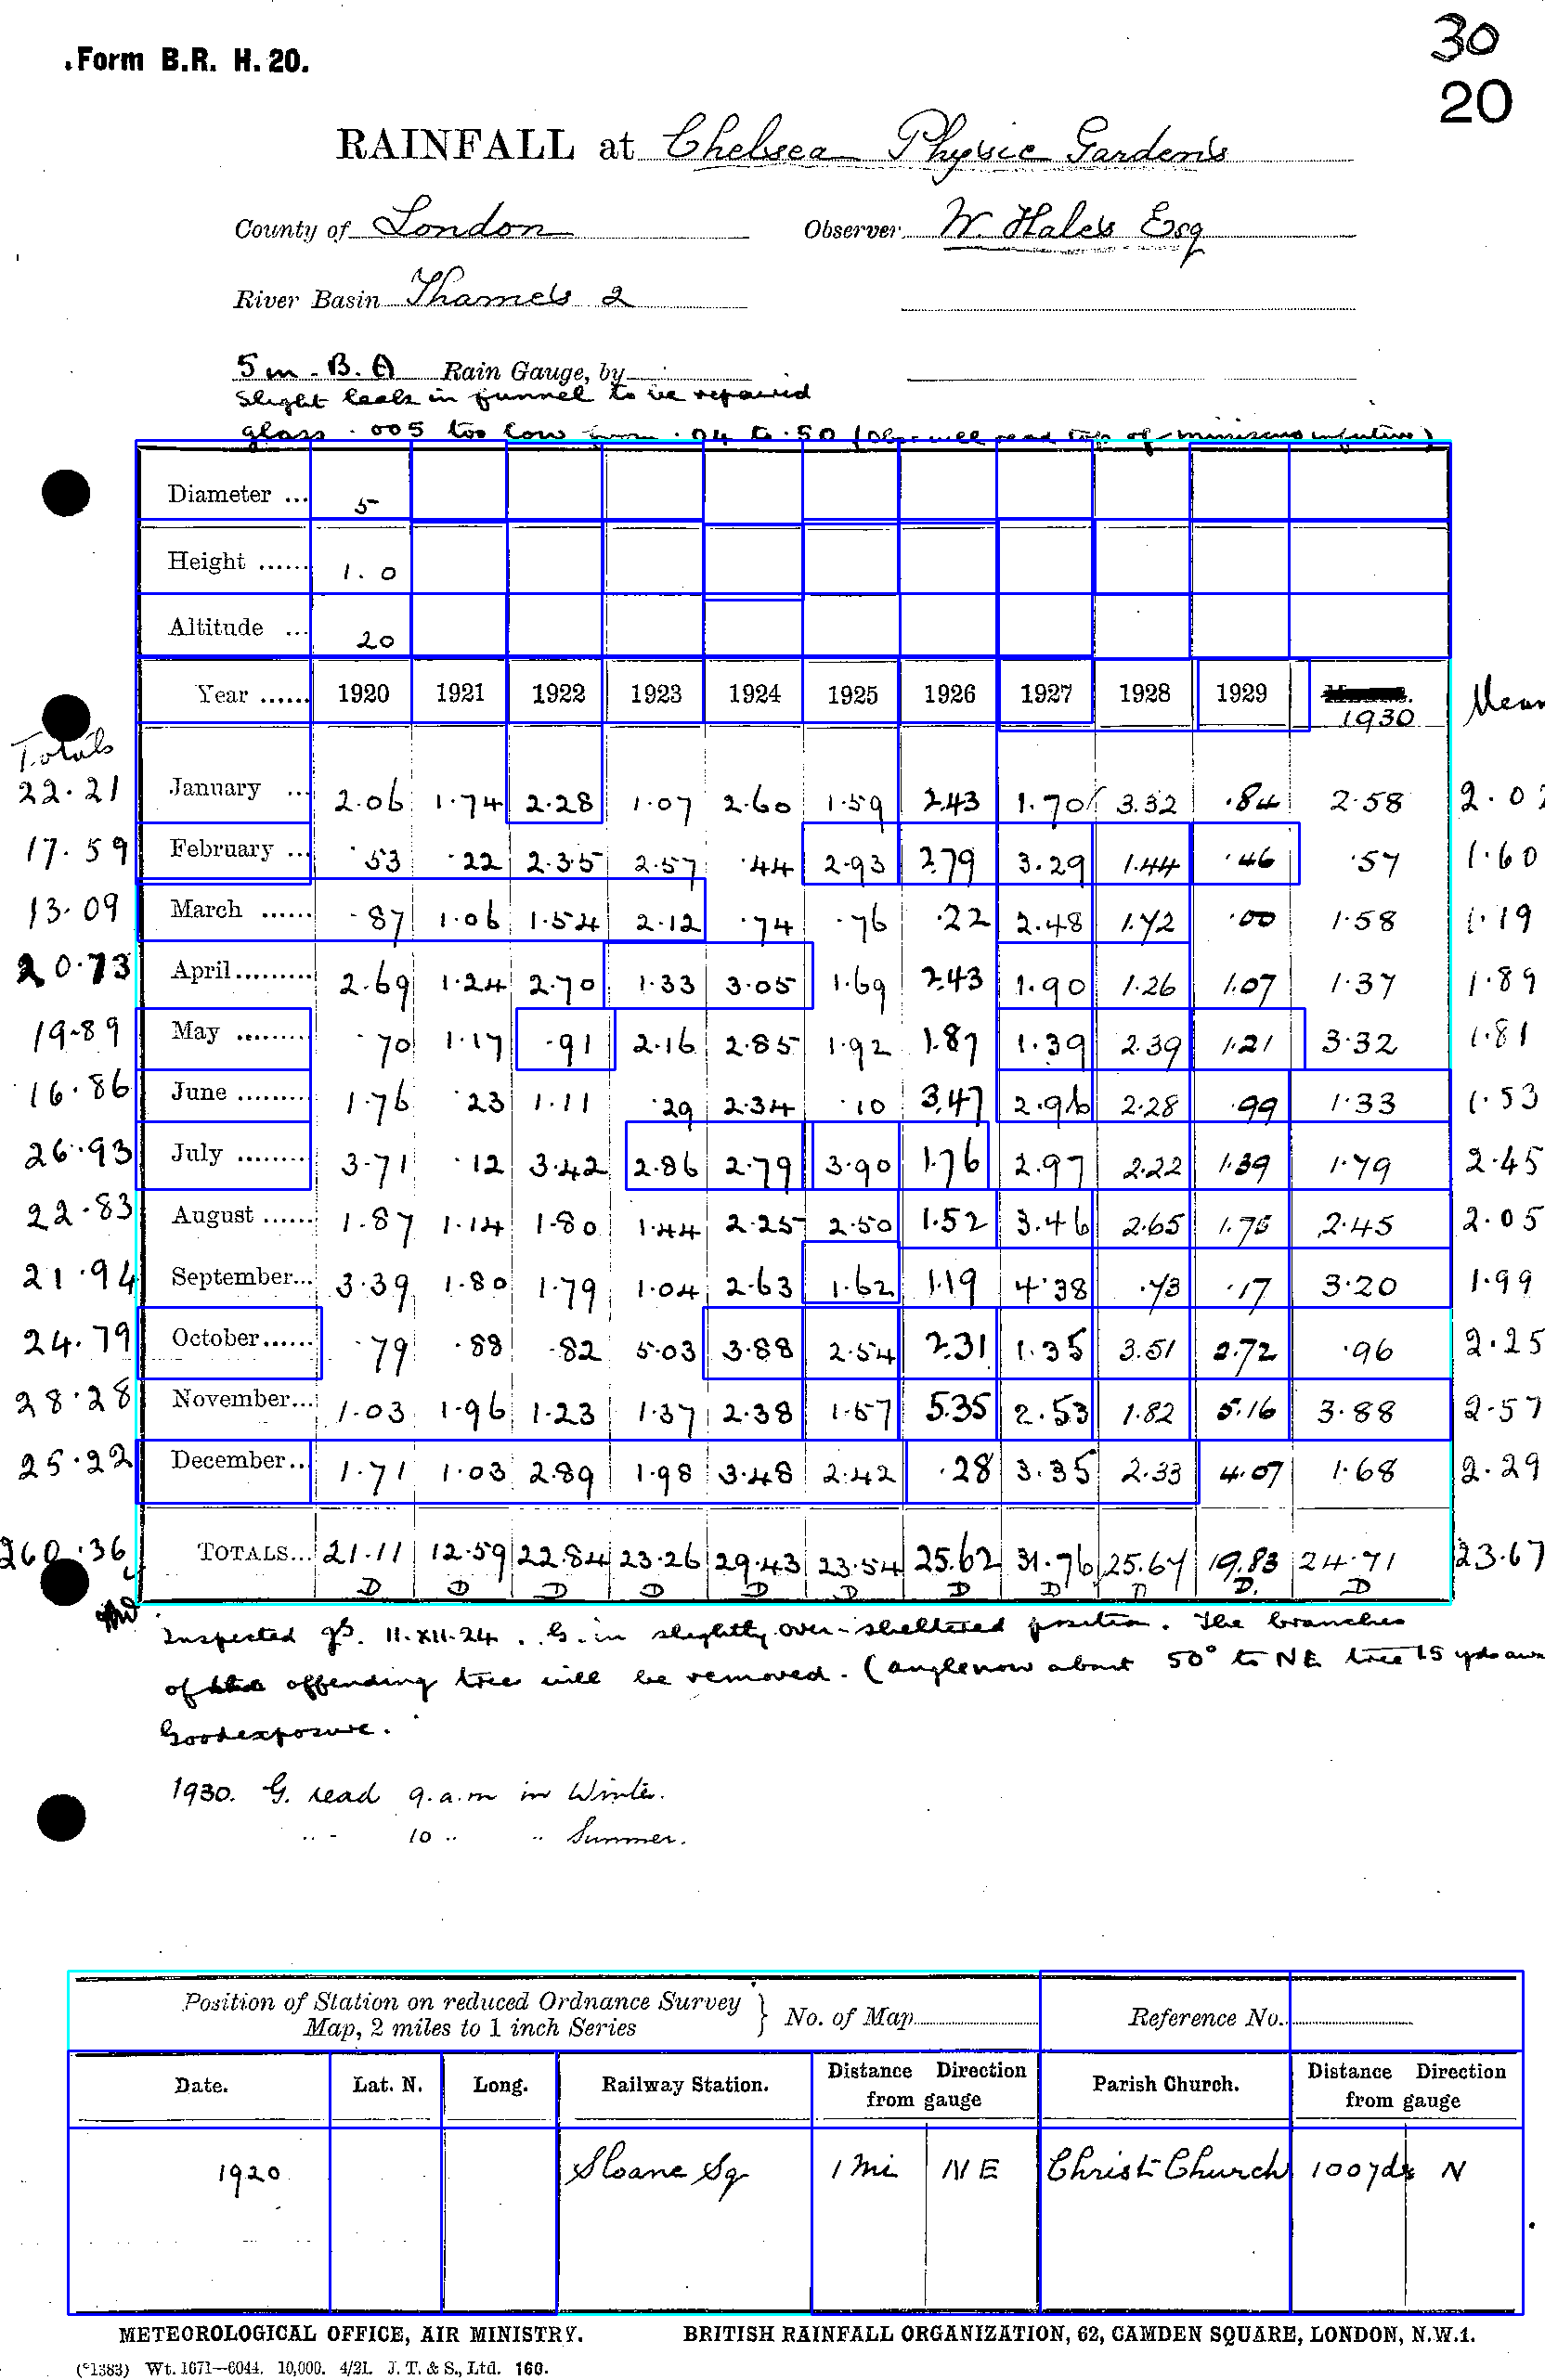

In [30]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in all_valid_cells:
    put_box(image,box,(0,0,color)) # Blue

# for box in new_valid_cells:
#     put_box(image,box,(0,color,0)) # Green

# for box in not_corrected_excluded_cells:
#     put_box(image,box,(color,0,0)) # Red

# for box in new_corrected_excluded_cells:
#     put_box(image,box,(color,0,color)) # Pink

# for box in blank_cells:
#     put_box(image,box,(color,color,0)) # Yellow

im_pil = Image.fromarray(image)
# im_pil.save(f"{filename}_temp_cell_classification_generation.jpg")
im_pil  

### Correct single error cell

In [22]:
# new_corrected_cells = []
# for cell in not_corrected_excluded_cells:
#     croppedimage_full=image[int(cell[1]):int(cell[3]),int(cell[0]):int(cell[2])]  
#     plt.rcParams["figure.figsize"] = (10,5)
#     plt.imshow(croppedimage_full)
#     plt.title(f'Input cell')
#     plt.show()
    
#     tid = cell[4]
#     avg_x, avg_y = average_cordinates[tid]

#     step_x = int(avg_x*0.01)
#     step_y = int(avg_y*0.01)

#     cur_corrected = segment_image(cell, masks[1], average_cordinates)
#     for cur_cell in cur_corrected:                      
#         cur_cell[0]-=step_x
#         cur_cell[1]-=step_y
#         cur_cell[2]+=step_x
#         cur_cell[3]+=step_y

#         croppedimage_full=image[int(cur_cell[1]):int(cur_cell[3]),int(cur_cell[0]):int(cur_cell[2])]  
#         plt.rcParams["figure.figsize"] = (10,5)
#         plt.imshow(croppedimage_full)
#         plt.title(f'Corrected cell')
#         plt.show()
        
#     new_corrected_cells += cur_corrected

In [49]:
# new_corrected_cells, error_cells = classify_single_cell(new_corrected_cells, masks[1])
# new_not_corrected_excluded_cells =  find_overlapped_cell(new_corrected_cells, not_corrected_excluded_cells, average_cordinates)

# error_cells =  find_overlapped_cell(new_corrected_cells, error_cells, average_cordinates)

# new_not_corrected_excluded_cells += error_cells

In [120]:
# new_corrected_cells =  find_overlapped_cell(all_valid_cells+new_valid_cells, new_corrected_cells,average_cordinates)

In [124]:
# img = cv.imread(img_path)
# image, height, width, _ = image_preprocessing(img)

# color = 255
# for box in tables:
#     box = list(map(int, box[0:4]))
#     put_box(image,box,(0,color,color)) # Cyan 
    
# for box in all_valid_cells:
#     put_box(image,box,(0,0,color)) # Blue

# # for box in new_valid_cells:
# #     put_box(image,box,(0,color,0)) # Green

# for box in new_not_corrected_excluded_cells:
#     put_box(image,box,(color,0,0)) # Red

# for box in new_corrected_cells:
#     put_box(image,box,(color,0,color)) # Pink

# for box in blank_cells:
#     put_box(image,box,(color,color,0)) # Yellow

# im_pil = Image.fromarray(image)
# # im_pil.save(f"{filename}_temp_cell_classification_generation.jpg")
# im_pil  

In [22]:
# # sort x and y coordinates of excluded_cells_pred
# def get_x_y_neighbour_cells(new_excluded_cells_pred, tables, average_cordinates):
#     y_cords = get_neighbouring_coord(new_excluded_cells_pred, tables, average_cordinates)
    
#     neighbouring_cells = {}
#     yidx = list(y_cords.keys())
    
#     for yid, y_idx in enumerate(y_cords):
#         yneighbours_idx = []

#         ## can be remove for later filtering
#         tid = y_cords[y_idx][0][4]
#         avg_x, avg_y = average_cordinates[tid]

#         yneighbours_idx = []
#         if yid>0 and yid+1 < len(y_cords):   
#             if abs(y_cords[yidx[yid-1]][0][3]-y_idx)<avg_y:   
#                 yneighbours_idx.append(yidx[yid-1]) #= [yidx[yid-1],yidx[yid+1]]
#             if abs(yidx[yid+1]-y_idx)<avg_y:             
#                 yneighbours_idx.append(yidx[yid+1]) 

#         elif yid+1 < len(y_cords):
#             if abs(yidx[yid+1]-y_idx)<avg_y:           
#                 yneighbours_idx.append(yidx[yid+1]) #first cell neighbour 

#         ### remove if condition if filtering is not required

#         xneighbours_idx = []
#         if len(y_cords[y_idx])>=1:
#             xneighbours_idx = [yneighbours_idx, y_cords[y_idx]]
#         else:
#             xneighbours_idx = [yneighbours_idx,[]]  # no neighbours

#         neighbouring_cells[y_idx]=xneighbours_idx
    
#     return neighbouring_cells, y_cords

In [20]:
# neighbouring_cells, y_cords = get_x_y_neighbour_cells(not_corrected_excluded_cells, tables, average_cordinates)

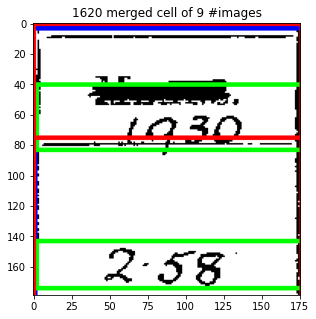

In [44]:
# cell = [1386, 703, 1562, 882, 1]
# croppedimage_full=image[int(cell[1]):int(cell[3]),int(cell[0]):int(cell[2])] 
# plt.rcParams["figure.figsize"] = (10,5)
# plt.imshow(croppedimage_full)
# plt.title(f'{yid} merged cell of {len(y_cords[yid])} #images')
# plt.show()   


In [23]:
# cor_cells = segment_image(cell, masks[1], average_cordinates)

In [24]:
# # seg_cells = [[1386, 703, 1562, 743, 1], [1386, 743, 1562, 786, 1], [1386, 786, 1562, 846, 1], [1386, 846, 1562, 877, 1]]
# # cor_cells = correct_column_cells(seg_cells,masks[1],average_cordinates)
# for i, s_cell in enumerate(cor_cells):
#     seg_cell = list(s_cell)
#     croppedimage_full=image[int(seg_cell[1]):int(seg_cell[3]),int(seg_cell[0]):int(seg_cell[2])]  
#     plt.rcParams["figure.figsize"] = (10,5)
#     plt.imshow(croppedimage_full)
#     plt.title(f'current cell images {seg_cell}')
#     plt.show()

In [25]:
# for i, s_cell in enumerate(error_corrected_cells):
#     seg_cell = list(s_cell)
#     croppedimage_full=image[int(seg_cell[1]):int(seg_cell[3]),int(seg_cell[0]):int(seg_cell[2])]  
#     plt.rcParams["figure.figsize"] = (10,5)
#     plt.imshow(croppedimage_full)
#     plt.title(f'current cell images {seg_cell}')
#     plt.show()

### Correct cell by merging error cells

In [23]:
x_y_neighbouring_cells_dict = {}
if len(not_corrected_excluded_cells)>2:
    neighbouring_cells, y_cords = get_x_y_neighbour_cells(not_corrected_excluded_cells, tables, average_cordinates)
    
    for yid in neighbouring_cells:
        cells = neighbouring_cells[yid]

        y_neighbours = cells[0]
        x_neighbours = cells[1]

        tid =x_neighbours[0][4]

        avg_x, avg_y = average_cordinates[tid]

        # print(yid,y_neighbours,x_neighbours,tid, average_cordinates[tid])

        # find x_neighbours
        ncells = []
        imagedraw = []
        next_cell_begin = True
        starting_cell = []

        for xid, xcell in enumerate(x_neighbours):    

            # Either split the cell or merge to begining cell
            if next_cell_begin:
                starting_cell = list(xcell)
            else:
                starting_cell[2] = xcell[2]

            # check next cell distance
            if (xid+1)<len(x_neighbours):
                next_cell = x_neighbours[xid+1]
                if abs(next_cell[0]-xcell[2])<(avg_x/3):
                    next_cell_begin = False
                else:
                    ncells.append(starting_cell)
                    starting_cell = []
                    next_cell_begin = True
            elif len(x_neighbours)==1:
                ncells.append(starting_cell)
                starting_cell = []

        if len(starting_cell)>0:
            ncells.append(starting_cell)

    #     print(x_neighbours,'---',ncells)   
        x_y_neighbouring_cells_dict[yid] = (y_neighbours, ncells)


y_neighbours_new = {}
if len(x_y_neighbouring_cells_dict)>2:
    yids = list(x_y_neighbouring_cells_dict.keys())
    count = 0
    y_neighbours = {}
    cur_list = []

    for i, j in zip(yids[:-1],yids[1:]):
        if count == 0:  # First index
            cur_list.append(i)        
        if (j-i) < avg_y:
            cur_list.append(j)
        else:
            y_neighbours[cur_list[0]] = cur_list
            cur_list = [j]
        count+=1

    if cur_list[0] not in y_neighbours:
        y_neighbours[cur_list[0]] = cur_list

    for yid in y_neighbours:
        for yidn in y_neighbours[yid]:
            y_neighbours_new[yidn] = y_neighbours[yid]
    #         if yidn not in y_neighbours:
    #             print(y_neighbours[yid])

============708================== 
Above cells:[] 
Current cells: [[1388, 708, 1562, 778, 1]] 
Below cells: [[334, 778, 545, 886, 1], [648, 778, 968, 886, 1], [1074, 778, 1562, 886, 1]]
collll [[1074, 708, 1288, 786, 1], [1288, 708, 1408, 786, 1], [1408, 708, 1562, 786, 1]] 708_786
collll [[1074, 786, 1288, 849, 1], [1288, 786, 1408, 849, 1], [1408, 786, 1562, 849, 1]] 786_849
collll [[1074, 849, 1288, 886, 1], [1288, 849, 1408, 886, 1], [1408, 849, 1562, 886, 1]] 849_886
[[1074, 708, 1288, 786, 1], [1288, 708, 1408, 786, 1], [1408, 708, 1562, 786, 1], [1074, 786, 1288, 849, 1], [1288, 786, 1408, 849, 1], [1408, 786, 1562, 849, 1], [1074, 849, 1288, 886, 1], [1288, 849, 1408, 886, 1], [1408, 849, 1562, 886, 1]]
2--708 just below cell: [1074, 778, 1562, 886, 1], Current cell: [1388, 708, 1562, 778, 1], [1074, 708, 1562, 778, 1] 1.0


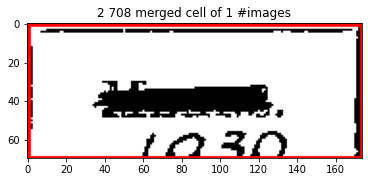

2 cur_cell info: [1076, 709, 1290, 787, 1]


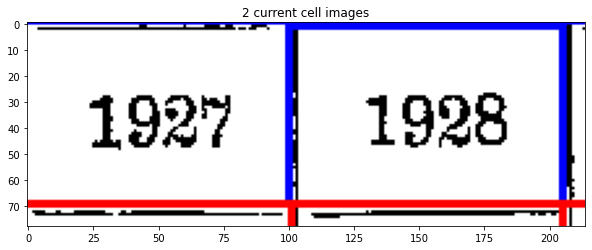

2 cur_cell info: [1290, 709, 1410, 787, 1]


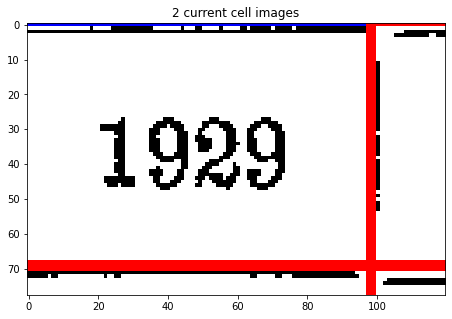

2 cur_cell info: [1410, 709, 1564, 818, 1]


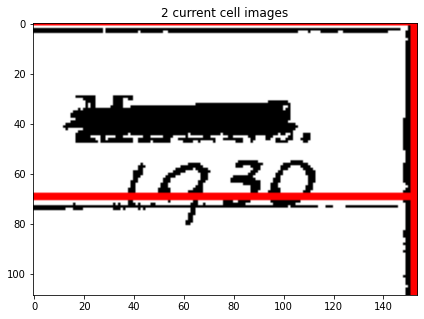

2 cur_cell info: [1076, 818, 1290, 887, 1]


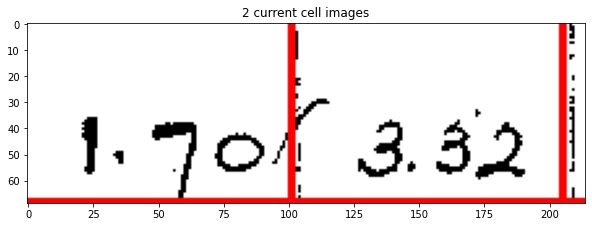

2 cur_cell info: [1290, 850, 1410, 887, 1]


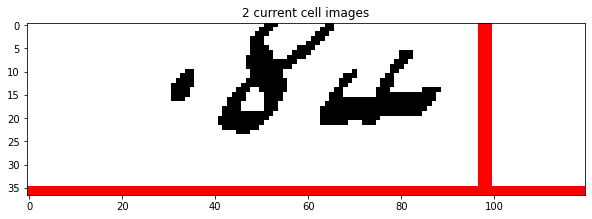

2 cur_cell info: [1410, 850, 1564, 887, 1]


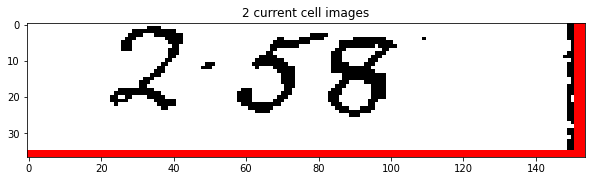

-----Below-----

============778================== 
Above cells:[[1388, 708, 1562, 778, 1]] 
Current cells: [[334, 778, 545, 886, 1], [648, 778, 968, 886, 1], [1074, 778, 1562, 886, 1]] 
Below cells: []
1 overlap score: 0.0 0.0
1 overlap score: 0.0 0.0
1 overlap score: 1.0 0.35655737704918034
1 cell info: [1388, 708, 1562, 778, 1] [1074, 778, 1562, 886, 1] [1388, 708, 1562, 886, 1]


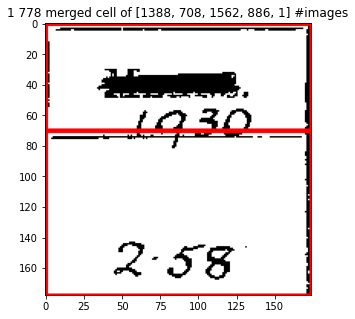

1--778 just above cell: [1388, 708, 1562, 778, 1], Current cell: [1074, 778, 1562, 886, 1], [1388, 778, 1562, 886, 1], 1.0
collll [[1388, 708, 1562, 786, 1]] 708_786
collll [[1388, 786, 1562, 846, 1]] 786_846
collll [[1388, 846, 1562, 886, 1]] 846_886
[[1388, 708, 1562, 786, 1], [1388, 786, 1562, 846, 1], [1388, 846, 1562, 886, 1]]
1 cur_cell info: [1390, 709, 1564, 817, 1]


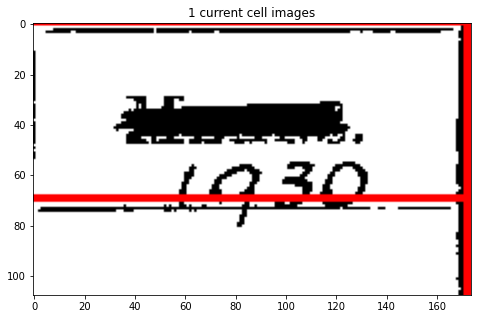

1 cur_cell info: [1390, 817, 1564, 887, 1]


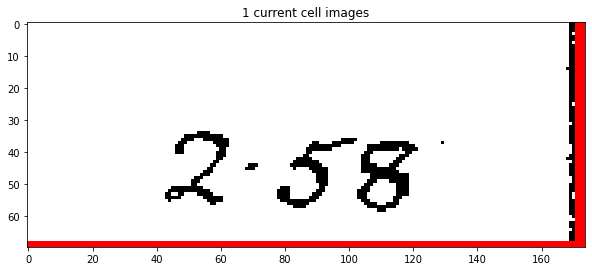

-----Above-----

============886================== 
Above cells:[[334, 778, 545, 886, 1], [648, 778, 968, 886, 1], [1074, 778, 1562, 886, 1]] 
Current cells: [[334, 886, 864, 952, 1], [1388, 886, 1562, 952, 1]] 
Below cells: [[334, 952, 1074, 1015, 1], [1281, 952, 1562, 1015, 1]]
1 overlap score: 1.0 0.39811320754716983
1 cell info: [334, 778, 545, 886, 1] [334, 886, 864, 952, 1] [334, 778, 545, 952, 1]


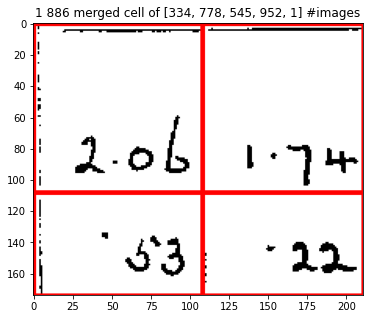

1--886 just above cell: [334, 778, 545, 886, 1], Current cell: [334, 886, 864, 952, 1], [334, 886, 545, 952, 1], 1.0
collll [[334, 778, 545, 850, 1]] 778_850
collll [[334, 850, 545, 911, 1]] 850_911
collll [[334, 911, 545, 952, 1]] 911_952
[[334, 778, 545, 850, 1], [334, 850, 545, 911, 1], [334, 911, 545, 952, 1]]
1 cur_cell info: [336, 779, 547, 912, 1]


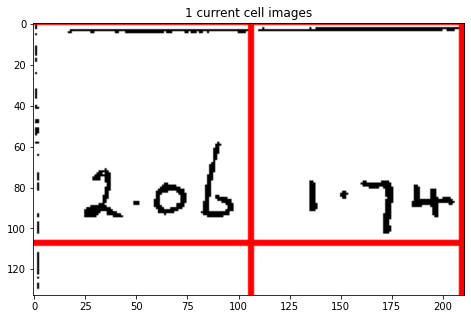

1 cur_cell info: [336, 912, 547, 953, 1]


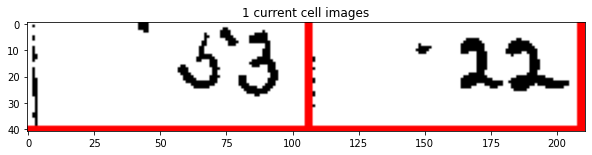

-----Above-----

1 overlap score: 0.675 0.4075471698113208
1 cell info: [648, 778, 968, 886, 1] [334, 886, 864, 952, 1] [648, 778, 968, 952, 1]


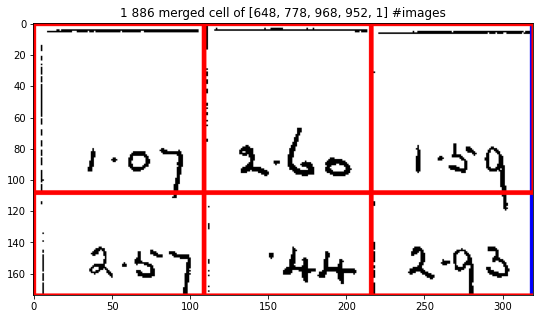

1--886 just above cell: [648, 778, 968, 886, 1], Current cell: [334, 886, 864, 952, 1], [648, 886, 968, 952, 1], 0.675
collll [[648, 778, 879, 854, 1], [879, 778, 968, 854, 1]] 778_854
collll [[648, 854, 879, 919, 1], [879, 854, 968, 919, 1]] 854_919
collll [[648, 919, 879, 952, 1], [879, 919, 968, 952, 1]] 919_952
[[648, 778, 879, 854, 1], [879, 778, 968, 854, 1], [648, 854, 879, 919, 1], [879, 854, 968, 919, 1], [648, 919, 879, 952, 1], [879, 919, 968, 952, 1]]
1 cur_cell info: [650, 779, 881, 920, 1]


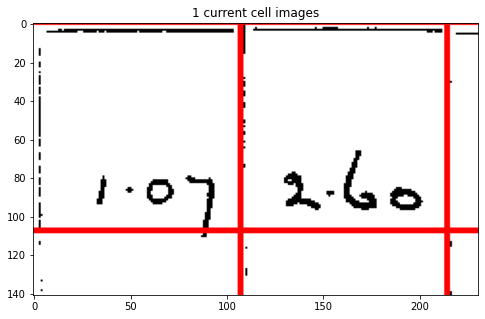

1 cur_cell info: [881, 855, 970, 920, 1]


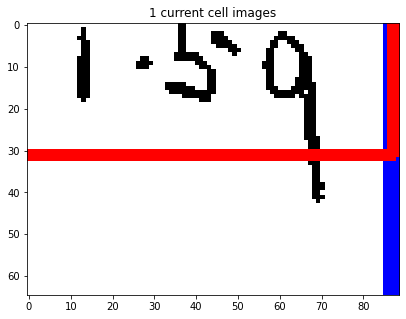

-----Above-----

1 overlap score: 0.0 0.0
collll [[334, 886, 458, 945, 1], [458, 886, 664, 945, 1], [664, 886, 872, 945, 1], [872, 886, 1066, 945, 1]] 886_945
collll [[334, 945, 458, 1012, 1], [458, 945, 664, 1012, 1], [664, 945, 872, 1012, 1], [872, 945, 1066, 1012, 1]] 945_1012
[[334, 886, 458, 945, 1], [458, 886, 664, 945, 1], [664, 886, 872, 945, 1], [872, 886, 1066, 945, 1], [334, 945, 458, 1012, 1], [458, 945, 664, 1012, 1], [664, 945, 872, 1012, 1], [872, 945, 1066, 1012, 1]]
2--886 just below cell: [334, 952, 1074, 1015, 1], Current cell: [334, 886, 864, 952, 1], [334, 886, 1074, 952, 1] 1.0


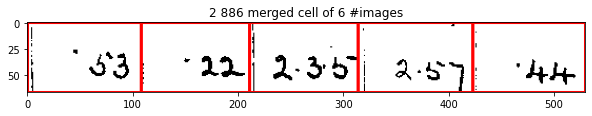

2 cur_cell info: [336, 887, 460, 946, 1]


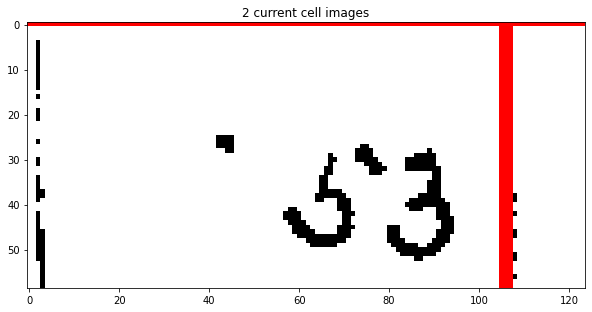

2 cur_cell info: [460, 887, 666, 946, 1]


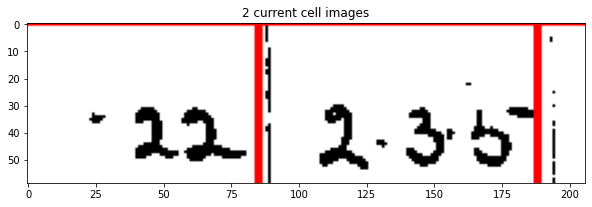

2 cur_cell info: [666, 887, 874, 946, 1]


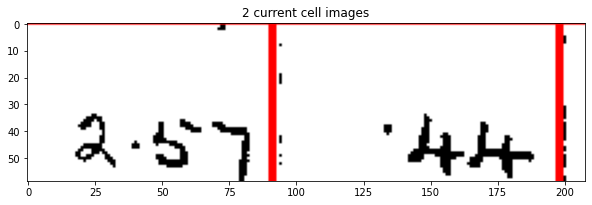

2 cur_cell info: [874, 887, 1068, 946, 1]


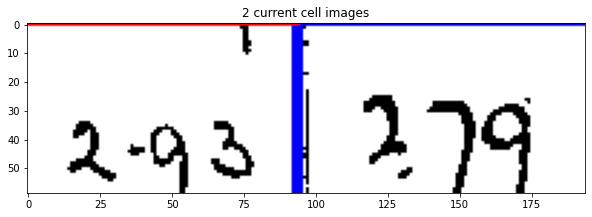

2 cur_cell info: [336, 946, 460, 1013, 1]


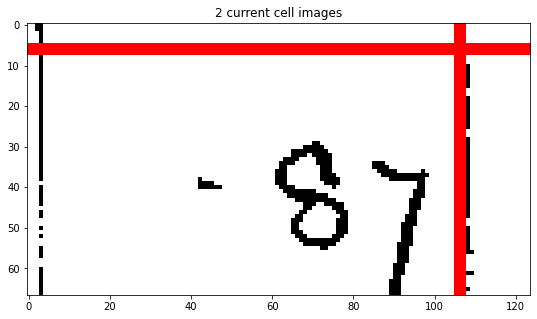

2 cur_cell info: [460, 946, 666, 1013, 1]


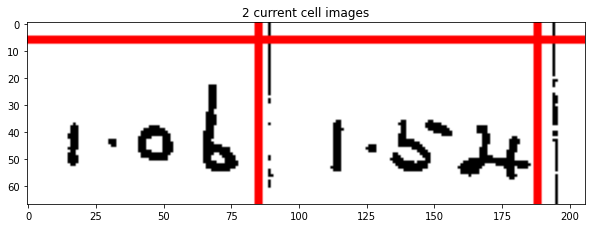

2 cur_cell info: [666, 946, 874, 1013, 1]


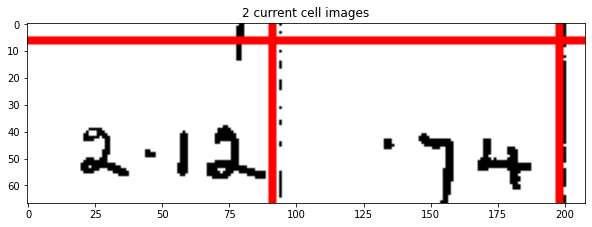

2 cur_cell info: [874, 946, 1068, 1013, 1]


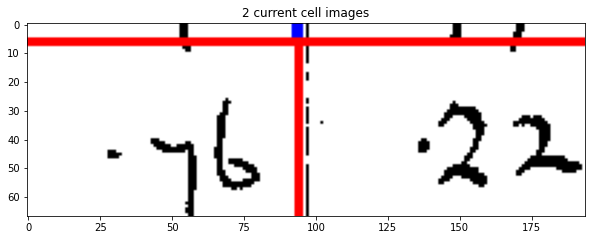

-----Below-----

1 overlap score: 0.0 0.0
1 overlap score: 0.0 0.0
1 overlap score: 0.35655737704918034 1.0
collll [[1281, 886, 1397, 942, 1], [1397, 886, 1562, 942, 1]] 886_942
collll [[1281, 942, 1397, 1005, 1], [1397, 942, 1562, 1005, 1]] 942_1005
[[1281, 886, 1397, 942, 1], [1397, 886, 1562, 942, 1], [1281, 942, 1397, 1005, 1], [1397, 942, 1562, 1005, 1]]
2--886 just below cell: [1281, 952, 1562, 1015, 1], Current cell: [1388, 886, 1562, 952, 1], [1281, 886, 1562, 952, 1] 1.0


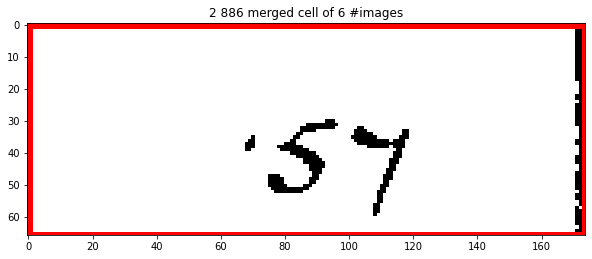

2 cur_cell info: [1283, 887, 1399, 943, 1]


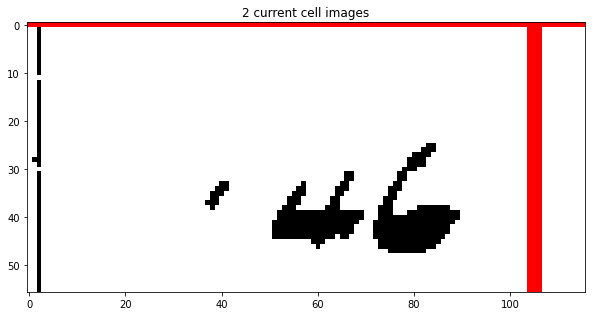

2 cur_cell info: [1399, 887, 1564, 943, 1]


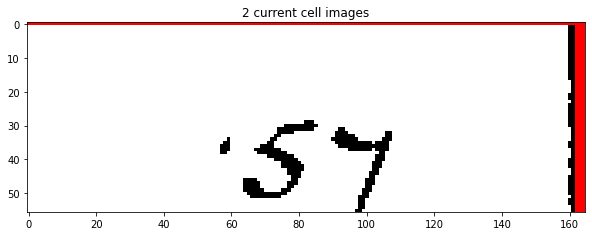

2 cur_cell info: [1283, 943, 1399, 1006, 1]


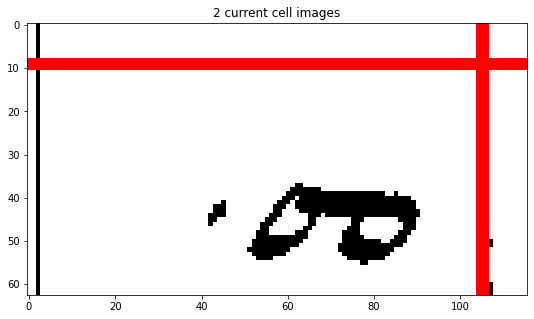

2 cur_cell info: [1399, 943, 1564, 1006, 1]


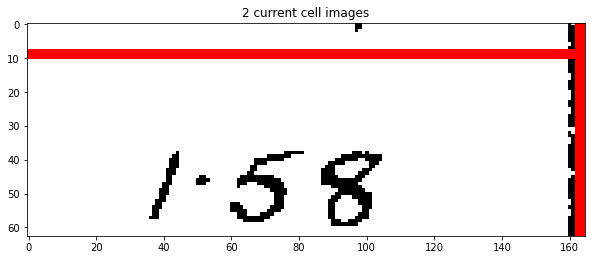

-----Below-----

============952================== 
Above cells:[[334, 886, 864, 952, 1], [1388, 886, 1562, 952, 1]] 
Current cells: [[334, 952, 1074, 1015, 1], [1281, 952, 1562, 1015, 1]] 
Below cells: [[146, 1015, 757, 1086, 1], [864, 1015, 1074, 1086, 1], [1281, 1015, 1562, 1086, 1]]
1 overlap score: 1.0 0.7162162162162162
1 cell info: [334, 886, 864, 952, 1] [334, 952, 1074, 1015, 1] [334, 886, 864, 1015, 1]


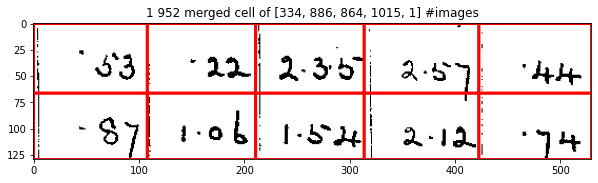

1--952 just above cell: [334, 886, 864, 952, 1], Current cell: [334, 952, 1074, 1015, 1], [334, 952, 864, 1015, 1], 1.0
collll [[334, 886, 458, 945, 1], [458, 886, 664, 945, 1], [664, 886, 858, 945, 1]] 886_945
collll [[334, 945, 458, 1012, 1], [458, 945, 664, 1012, 1], [664, 945, 858, 1012, 1]] 945_1012
[[334, 886, 458, 945, 1], [458, 886, 664, 945, 1], [664, 886, 858, 945, 1], [334, 945, 458, 1012, 1], [458, 945, 664, 1012, 1], [664, 945, 858, 1012, 1]]
1 cur_cell info: [336, 887, 460, 946, 1]


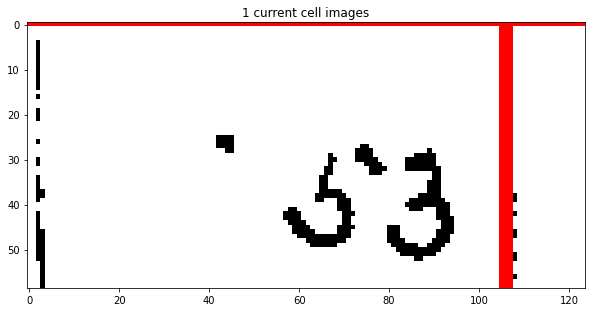

1 cur_cell info: [460, 887, 666, 946, 1]


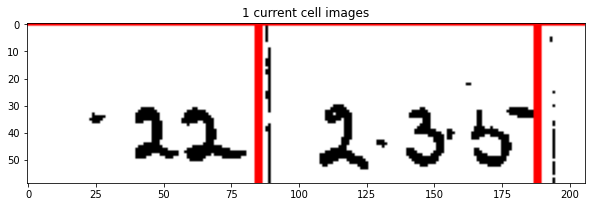

1 cur_cell info: [666, 887, 860, 946, 1]


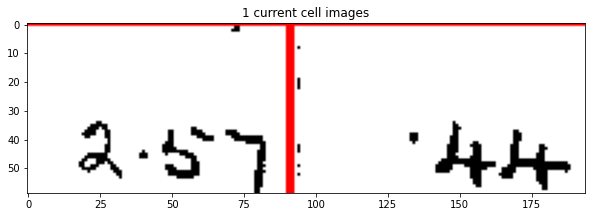

1 cur_cell info: [336, 946, 460, 1013, 1]


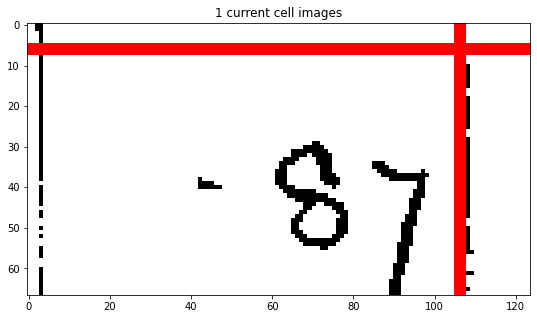

1 cur_cell info: [460, 946, 666, 1013, 1]


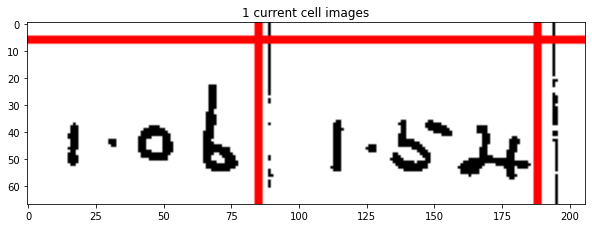

1 cur_cell info: [666, 946, 860, 1013, 1]


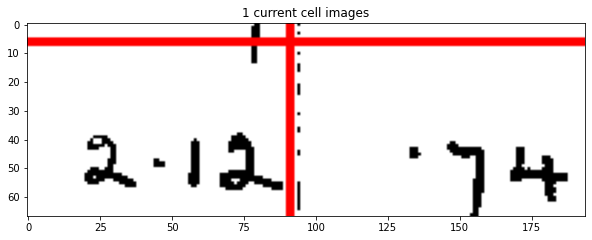

-----Above-----

1 overlap score: 0.0 0.0
collll [[146, 952, 757, 1006, 1]] 952_1006
collll [[146, 1006, 757, 1074, 1]] 1006_1074
[[146, 952, 757, 1006, 1], [146, 1006, 757, 1074, 1]]
2--952 just below cell: [146, 1015, 757, 1086, 1], Current cell: [334, 952, 1074, 1015, 1], [146, 952, 757, 1015, 1] 0.5716216216216217


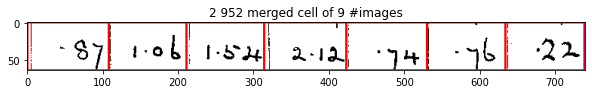

2 cur_cell info: [148, 953, 759, 1007, 1]


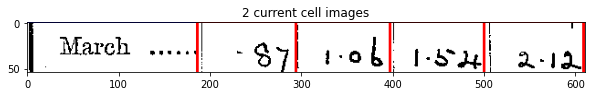

2 cur_cell info: [148, 1007, 759, 1075, 1]


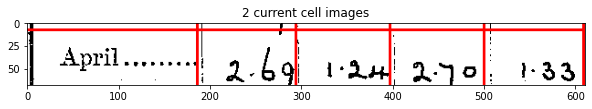

-----Below-----

1 overlap score: 0.0 0.0
1 overlap score: 1.0 0.6192170818505338
1 cell info: [1388, 886, 1562, 952, 1] [1281, 952, 1562, 1015, 1] [1388, 886, 1562, 1015, 1]


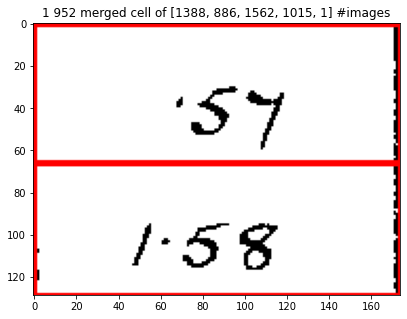

1--952 just above cell: [1388, 886, 1562, 952, 1], Current cell: [1281, 952, 1562, 1015, 1], [1388, 952, 1562, 1015, 1], 1.0
collll [[1388, 886, 1562, 943, 1]] 886_943
collll [[1388, 943, 1562, 1005, 1]] 943_1005
[[1388, 886, 1562, 943, 1], [1388, 943, 1562, 1005, 1]]
1 cur_cell info: [1390, 887, 1564, 944, 1]


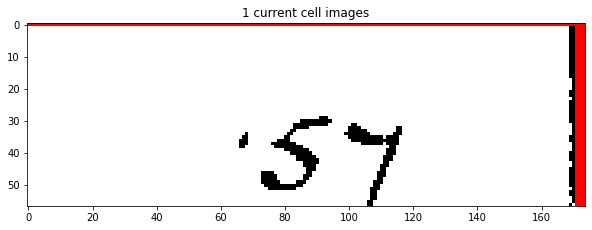

1 cur_cell info: [1390, 944, 1564, 1006, 1]


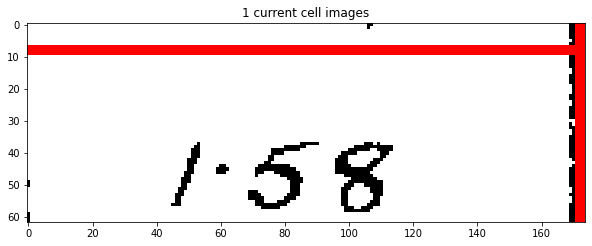

-----Above-----

collll [[1281, 952, 1403, 1005, 1], [1403, 952, 1562, 1005, 1]] 952_1005
collll [[1281, 1005, 1403, 1073, 1], [1403, 1005, 1562, 1073, 1]] 1005_1073
[[1281, 952, 1403, 1005, 1], [1403, 952, 1562, 1005, 1], [1281, 1005, 1403, 1073, 1], [1403, 1005, 1562, 1073, 1]]
2--952 just below cell: [1281, 1015, 1562, 1086, 1], Current cell: [1281, 952, 1562, 1015, 1], [1281, 952, 1562, 1015, 1] 1.0


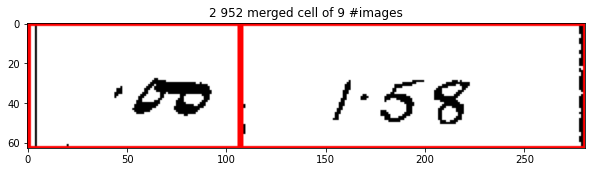

2 cur_cell info: [1283, 953, 1405, 1006, 1]


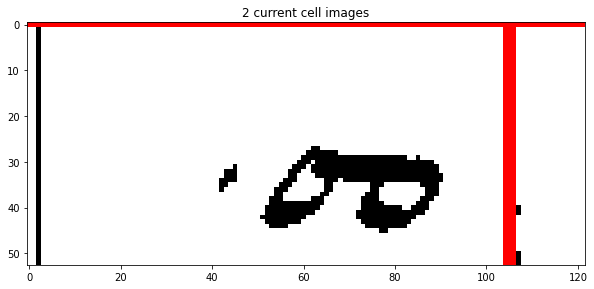

2 cur_cell info: [1405, 953, 1564, 1006, 1]


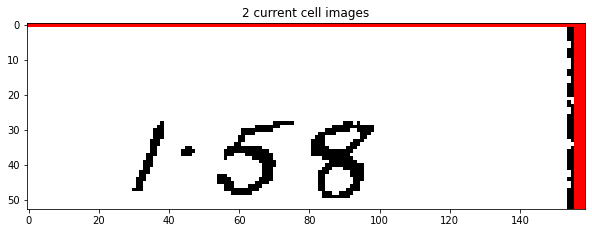

2 cur_cell info: [1283, 1006, 1405, 1074, 1]


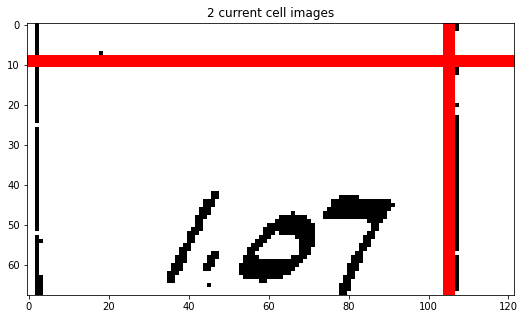

2 cur_cell info: [1405, 1006, 1564, 1074, 1]


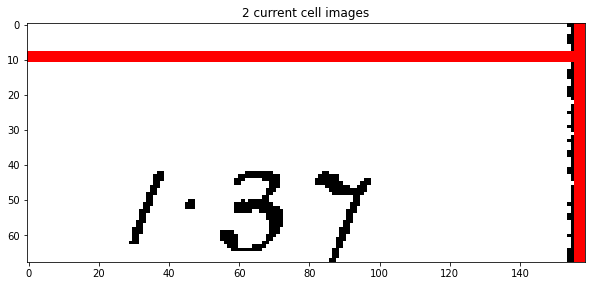

-----Below-----

============1015================== 
Above cells:[[334, 952, 1074, 1015, 1], [1281, 952, 1562, 1015, 1]] 
Current cells: [[146, 1015, 757, 1086, 1], [864, 1015, 1074, 1086, 1], [1281, 1015, 1562, 1086, 1]] 
Below cells: [[334, 1086, 545, 1152, 1], [648, 1086, 1074, 1152, 1], [1388, 1086, 1562, 1152, 1]]
1 overlap score: 0.5716216216216217 0.6923076923076923
1 cell info: [334, 952, 1074, 1015, 1] [146, 1015, 757, 1086, 1] [334, 952, 1074, 1086, 1]


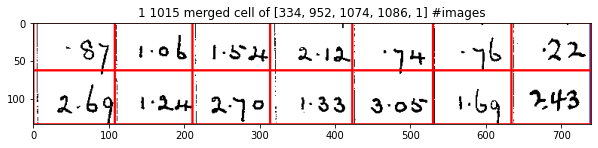

1--1015 just above cell: [334, 952, 1074, 1015, 1], Current cell: [146, 1015, 757, 1086, 1], [334, 1015, 1074, 1086, 1], 0.5716216216216217
collll [[334, 952, 874, 1012, 1], [874, 952, 1074, 1012, 1]] 952_1012
collll [[334, 1012, 874, 1074, 1], [874, 1012, 1074, 1074, 1]] 1012_1074
[[334, 952, 874, 1012, 1], [874, 952, 1074, 1012, 1], [334, 1012, 874, 1074, 1], [874, 1012, 1074, 1074, 1]]
1 cur_cell info: [336, 953, 876, 1013, 1]


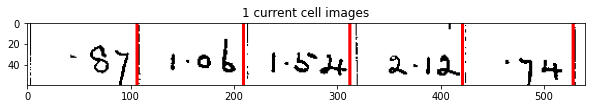

1 cur_cell info: [876, 953, 1076, 1013, 1]


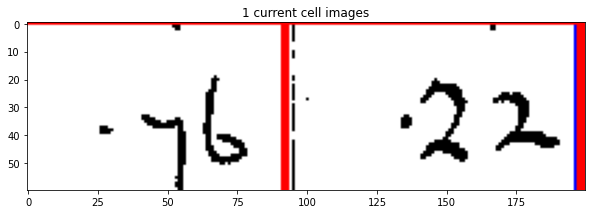

1 cur_cell info: [336, 1013, 876, 1075, 1]


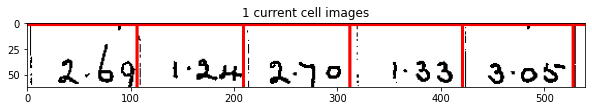

1 cur_cell info: [876, 1013, 1076, 1075, 1]


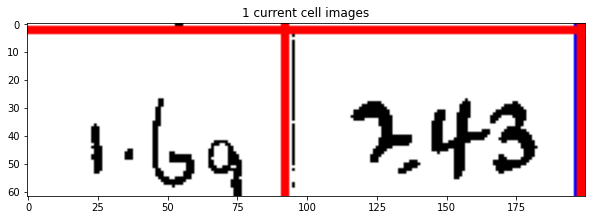

-----Above-----

1 overlap score: 0.0 0.0
1 overlap score: 0.28378378378378377 1.0
1 overlap score: 0.0 0.0
collll [[648, 1015, 873, 1073, 1], [873, 1015, 1074, 1073, 1]] 1015_1073
collll [[648, 1073, 873, 1141, 1], [873, 1073, 1074, 1141, 1]] 1073_1141
[[648, 1015, 873, 1073, 1], [873, 1015, 1074, 1073, 1], [648, 1073, 873, 1141, 1], [873, 1073, 1074, 1141, 1]]
2--1015 just below cell: [648, 1086, 1074, 1152, 1], Current cell: [864, 1015, 1074, 1086, 1], [648, 1015, 1074, 1086, 1] 1.0


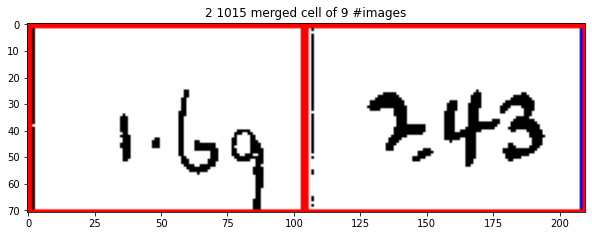

2 cur_cell info: [650, 1016, 875, 1074, 1]


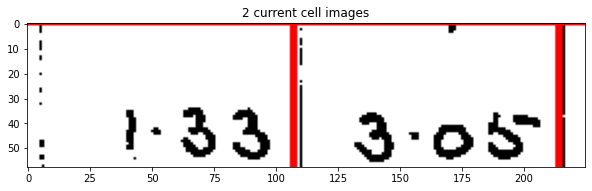

2 cur_cell info: [875, 1016, 1076, 1074, 1]


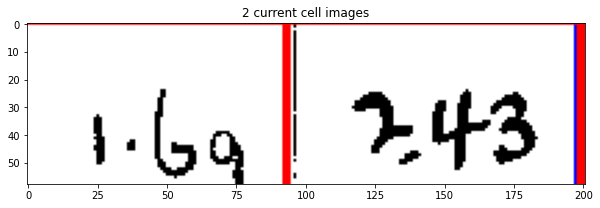

2 cur_cell info: [650, 1074, 875, 1142, 1]


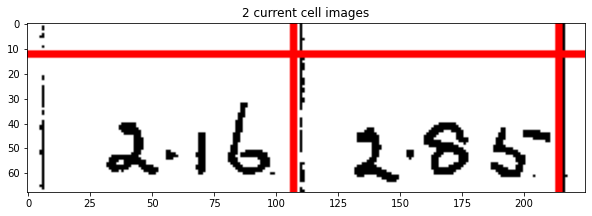

2 cur_cell info: [875, 1074, 1076, 1142, 1]


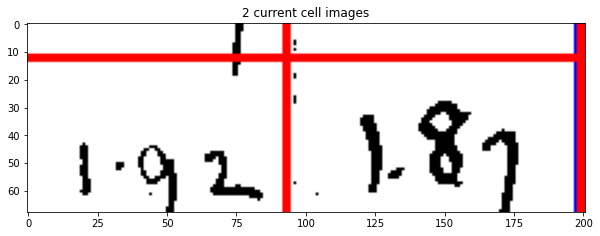

-----Below-----

1 overlap score: 0.0 0.0
1 overlap score: 1.0 1.0
1 cell info: [1281, 952, 1562, 1015, 1] [1281, 1015, 1562, 1086, 1] [1281, 952, 1562, 1086, 1]


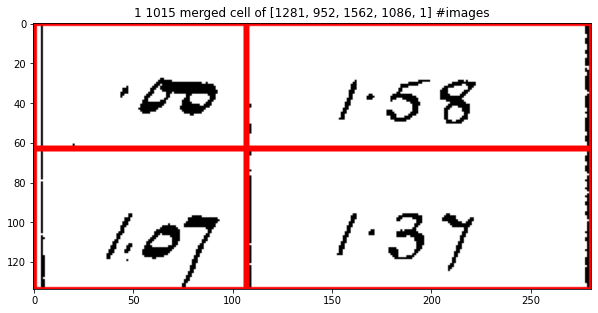

1--1015 just above cell: [1281, 952, 1562, 1015, 1], Current cell: [1281, 1015, 1562, 1086, 1], [1281, 1015, 1562, 1086, 1], 1.0
collll [[1281, 952, 1403, 1005, 1], [1403, 952, 1562, 1005, 1]] 952_1005
collll [[1281, 1005, 1403, 1073, 1], [1403, 1005, 1562, 1073, 1]] 1005_1073
[[1281, 952, 1403, 1005, 1], [1403, 952, 1562, 1005, 1], [1281, 1005, 1403, 1073, 1], [1403, 1005, 1562, 1073, 1]]
1 cur_cell info: [1283, 953, 1405, 1006, 1]


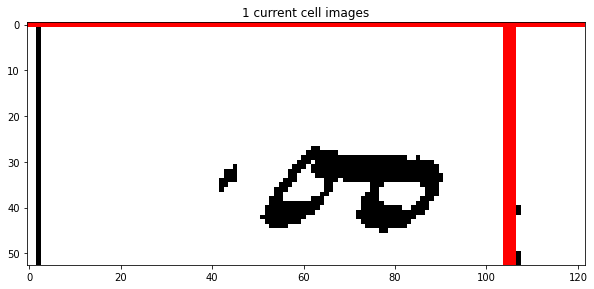

1 cur_cell info: [1405, 953, 1564, 1006, 1]


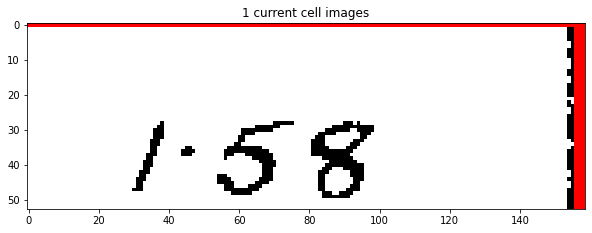

1 cur_cell info: [1283, 1006, 1405, 1074, 1]


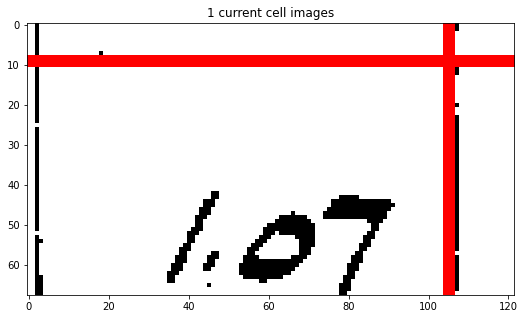

1 cur_cell info: [1405, 1006, 1564, 1074, 1]


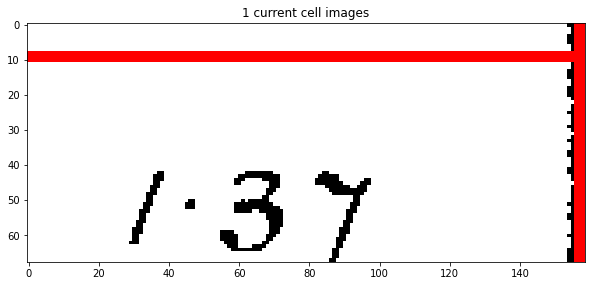

-----Above-----

collll [[1388, 1015, 1562, 1073, 1]] 1015_1073
collll [[1388, 1073, 1562, 1138, 1]] 1073_1138
[[1388, 1015, 1562, 1073, 1], [1388, 1073, 1562, 1138, 1]]
2--1015 just below cell: [1388, 1086, 1562, 1152, 1], Current cell: [1281, 1015, 1562, 1086, 1], [1388, 1015, 1562, 1086, 1] 0.6192170818505338


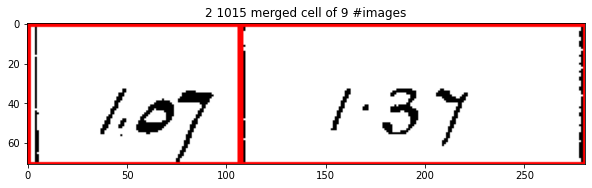

2 cur_cell info: [1390, 1016, 1564, 1074, 1]


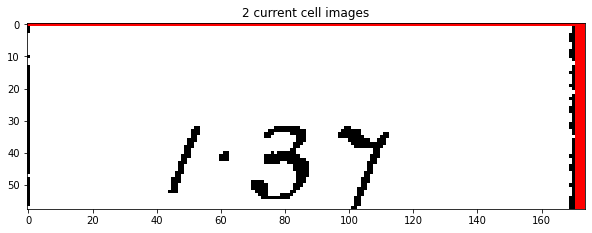

2 cur_cell info: [1390, 1074, 1564, 1139, 1]


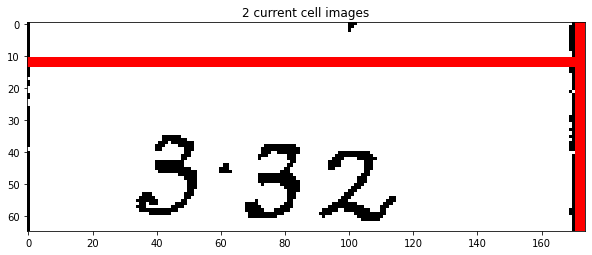

-----Below-----

============1086================== 
Above cells:[[146, 1015, 757, 1086, 1], [864, 1015, 1074, 1086, 1], [1281, 1015, 1562, 1086, 1]] 
Current cells: [[334, 1086, 545, 1152, 1], [648, 1086, 1074, 1152, 1], [1388, 1086, 1562, 1152, 1]] 
Below cells: [[334, 1152, 1074, 1208, 1]]
1 overlap score: 0.3453355155482815 1.0
1 overlap score: 0.0 0.0
1 overlap score: 0.0 0.0
collll [[334, 1086, 554, 1141, 1], [554, 1086, 660, 1141, 1], [660, 1086, 872, 1141, 1], [872, 1086, 1062, 1141, 1]] 1086_1141
collll [[334, 1141, 554, 1206, 1], [554, 1141, 660, 1206, 1], [660, 1141, 872, 1206, 1], [872, 1141, 1062, 1206, 1]] 1141_1206
[[334, 1086, 554, 1141, 1], [554, 1086, 660, 1141, 1], [660, 1086, 872, 1141, 1], [872, 1086, 1062, 1141, 1], [334, 1141, 554, 1206, 1], [554, 1141, 660, 1206, 1], [660, 1141, 872, 1206, 1], [872, 1141, 1062, 1206, 1]]
2--1086 just below cell: [334, 1152, 1074, 1208, 1], Current cell: [334, 1086, 545, 1152, 1], [334, 1086, 1074, 1152, 1] 1.0


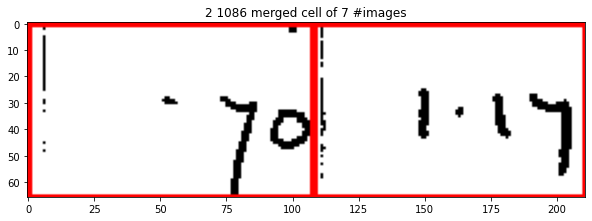

2 cur_cell info: [336, 1087, 556, 1142, 1]


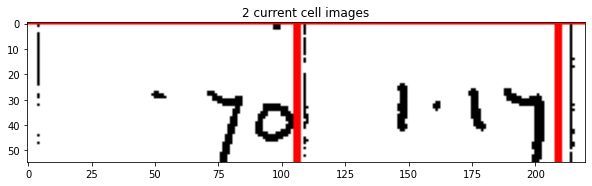

2 cur_cell info: [556, 1087, 662, 1142, 1]


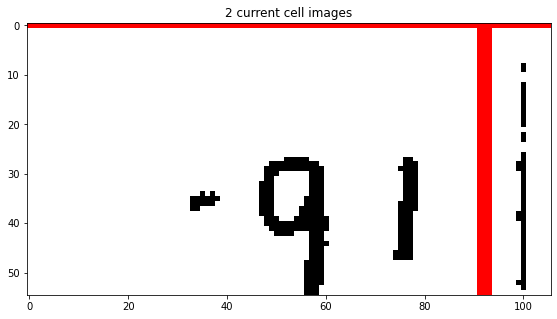

2 cur_cell info: [662, 1087, 874, 1142, 1]


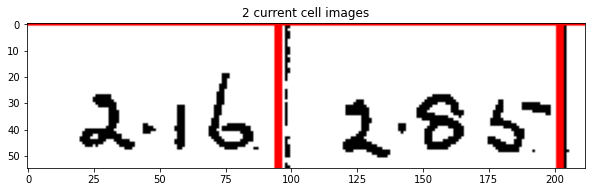

2 cur_cell info: [874, 1087, 1064, 1142, 1]


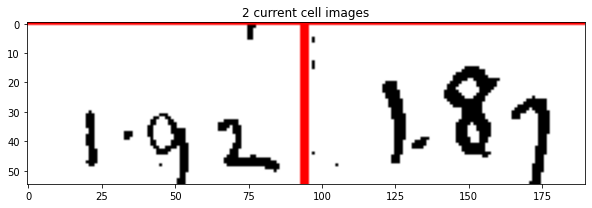

2 cur_cell info: [336, 1142, 556, 1207, 1]


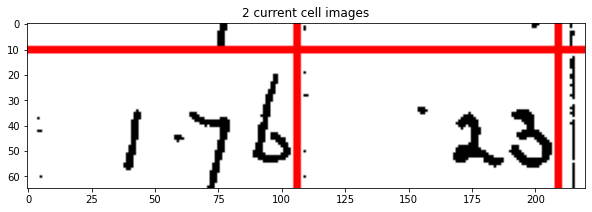

2 cur_cell info: [556, 1142, 662, 1207, 1]


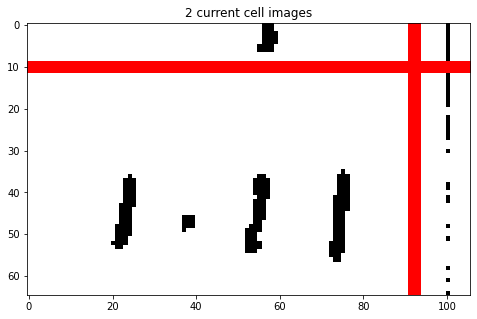

2 cur_cell info: [662, 1142, 874, 1207, 1]


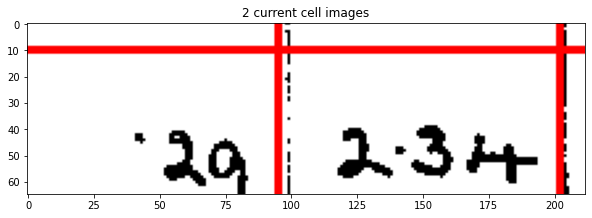

2 cur_cell info: [874, 1142, 1064, 1207, 1]


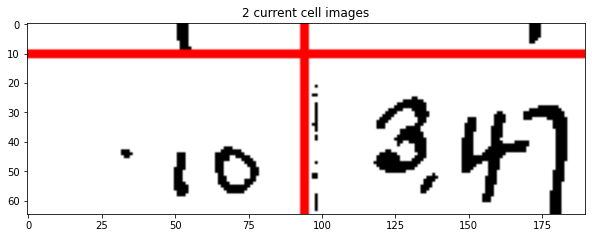

-----Below-----

1 overlap score: 0.1783960720130933 0.25586854460093894
1 overlap score: 1.0 0.49295774647887325
1 cell info: [864, 1015, 1074, 1086, 1] [648, 1086, 1074, 1152, 1] [864, 1015, 1074, 1152, 1]


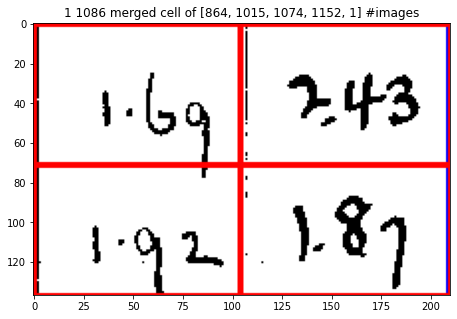

1--1086 just above cell: [864, 1015, 1074, 1086, 1], Current cell: [648, 1086, 1074, 1152, 1], [864, 1086, 1074, 1152, 1], 1.0
collll [[864, 1015, 1074, 1073, 1]] 1015_1073
collll [[864, 1073, 1074, 1141, 1]] 1073_1141
[[864, 1015, 1074, 1073, 1], [864, 1073, 1074, 1141, 1]]
1 cur_cell info: [866, 1016, 1076, 1074, 1]


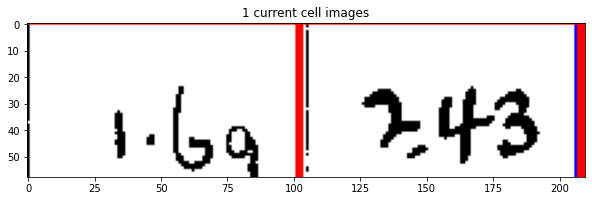

1 cur_cell info: [866, 1074, 1076, 1142, 1]


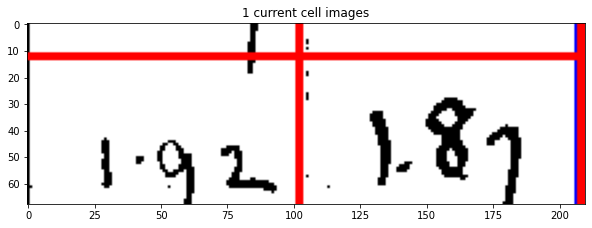

-----Above-----

1 overlap score: 0.0 0.0
collll [[334, 1086, 554, 1141, 1], [554, 1086, 660, 1141, 1], [660, 1086, 872, 1141, 1], [872, 1086, 1062, 1141, 1]] 1086_1141
collll [[334, 1141, 554, 1206, 1], [554, 1141, 660, 1206, 1], [660, 1141, 872, 1206, 1], [872, 1141, 1062, 1206, 1]] 1141_1206
[[334, 1086, 554, 1141, 1], [554, 1086, 660, 1141, 1], [660, 1086, 872, 1141, 1], [872, 1086, 1062, 1141, 1], [334, 1141, 554, 1206, 1], [554, 1141, 660, 1206, 1], [660, 1141, 872, 1206, 1], [872, 1141, 1062, 1206, 1]]
2--1086 just below cell: [334, 1152, 1074, 1208, 1], Current cell: [648, 1086, 1074, 1152, 1], [334, 1086, 1074, 1152, 1] 1.0


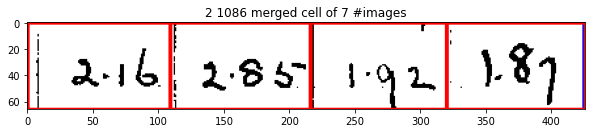

2 cur_cell info: [336, 1087, 556, 1142, 1]


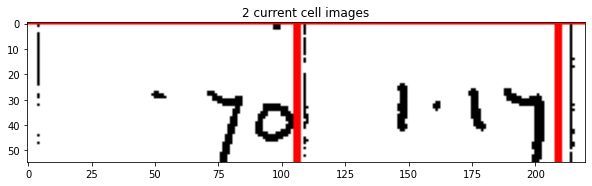

2 cur_cell info: [556, 1087, 662, 1142, 1]


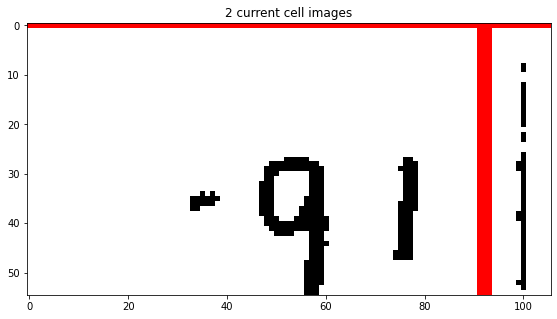

2 cur_cell info: [662, 1087, 874, 1142, 1]


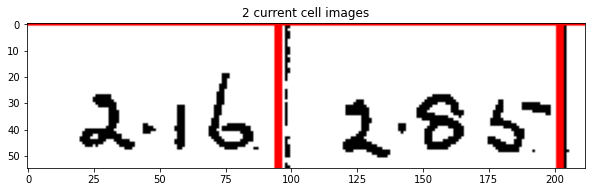

2 cur_cell info: [874, 1087, 1064, 1142, 1]


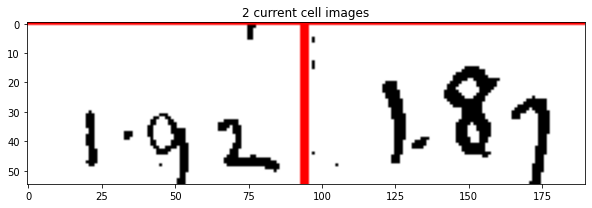

2 cur_cell info: [336, 1142, 556, 1207, 1]


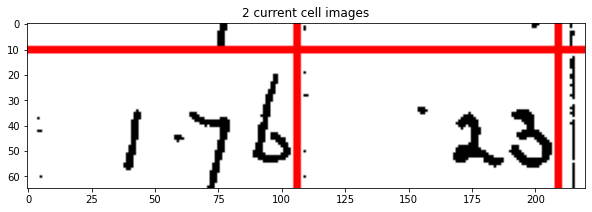

2 cur_cell info: [556, 1142, 662, 1207, 1]


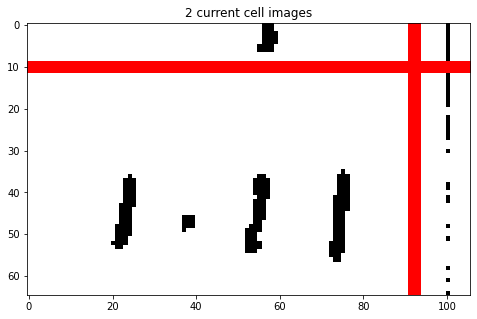

2 cur_cell info: [662, 1142, 874, 1207, 1]


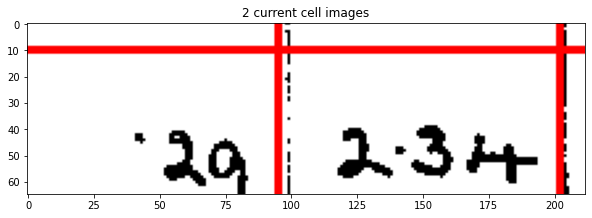

2 cur_cell info: [874, 1142, 1064, 1207, 1]


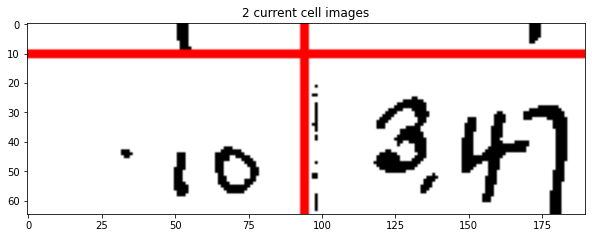

-----Below-----

1 overlap score: 0.0 0.0
1 overlap score: 0.0 0.0
1 overlap score: 0.6192170818505338 1.0
1 cell info: [1281, 1015, 1562, 1086, 1] [1388, 1086, 1562, 1152, 1] [1281, 1015, 1562, 1152, 1]


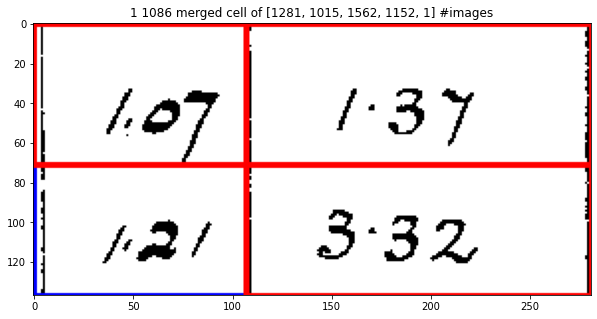

1--1086 just above cell: [1281, 1015, 1562, 1086, 1], Current cell: [1388, 1086, 1562, 1152, 1], [1281, 1086, 1562, 1152, 1], 0.6192170818505338
collll [[1281, 1015, 1403, 1073, 1], [1403, 1015, 1562, 1073, 1]] 1015_1073
collll [[1281, 1073, 1403, 1138, 1], [1403, 1073, 1562, 1138, 1]] 1073_1138
[[1281, 1015, 1403, 1073, 1], [1403, 1015, 1562, 1073, 1], [1281, 1073, 1403, 1138, 1], [1403, 1073, 1562, 1138, 1]]
1 cur_cell info: [1283, 1016, 1405, 1074, 1]


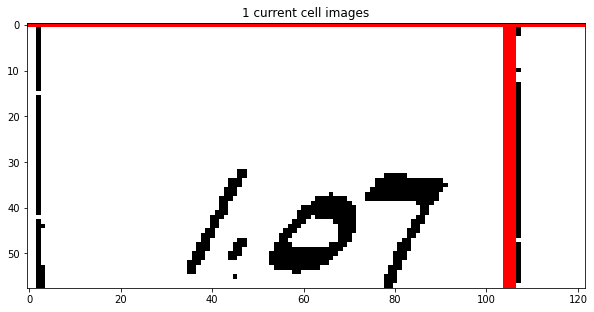

1 cur_cell info: [1405, 1016, 1564, 1074, 1]


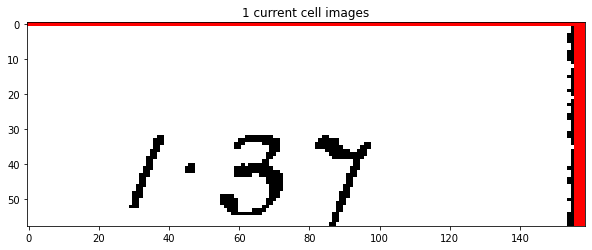

1 cur_cell info: [1283, 1074, 1405, 1139, 1]


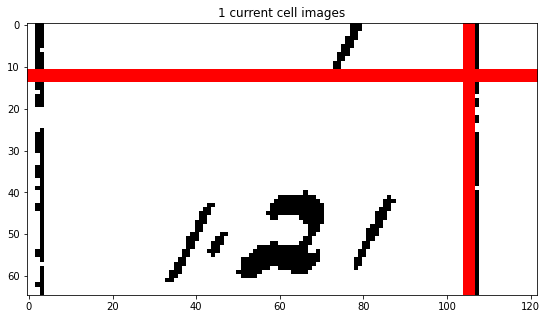

1 cur_cell info: [1405, 1074, 1564, 1139, 1]


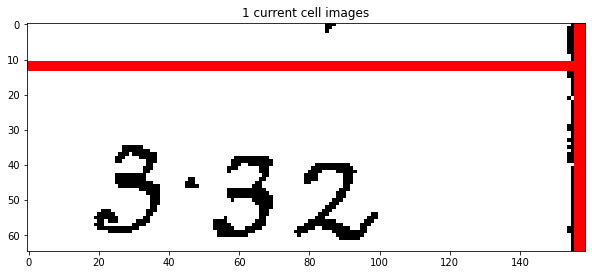

-----Above-----

============1152================== 
Above cells:[[334, 1086, 545, 1152, 1], [648, 1086, 1074, 1152, 1], [1388, 1086, 1562, 1152, 1]] 
Current cells: [[334, 1152, 1074, 1208, 1]] 
Below cells: [[334, 1208, 757, 1281, 1], [1074, 1208, 1281, 1281, 1]]
1 overlap score: 1.0 0.2851351351351351
1 cell info: [334, 1086, 545, 1152, 1] [334, 1152, 1074, 1208, 1] [334, 1086, 545, 1208, 1]


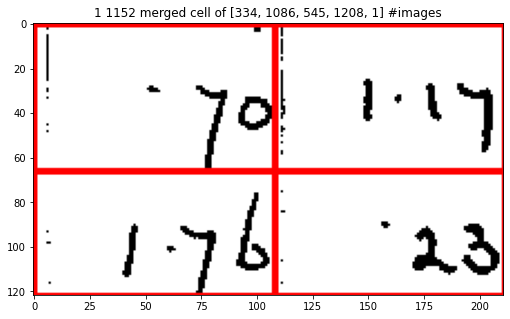

1--1152 just above cell: [334, 1086, 545, 1152, 1], Current cell: [334, 1152, 1074, 1208, 1], [334, 1152, 545, 1208, 1], 1.0
collll [[334, 1086, 545, 1136, 1]] 1086_1136
collll [[334, 1136, 545, 1200, 1]] 1136_1200
[[334, 1086, 545, 1136, 1], [334, 1136, 545, 1200, 1]]
1 cur_cell info: [336, 1087, 547, 1137, 1]


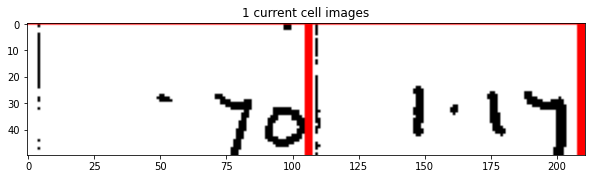

1 cur_cell info: [336, 1137, 547, 1201, 1]


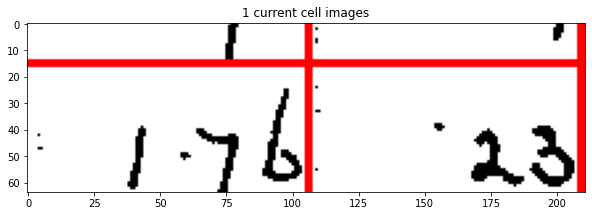

-----Above-----

1 overlap score: 1.0 0.5756756756756757
1 cell info: [648, 1086, 1074, 1152, 1] [334, 1152, 1074, 1208, 1] [648, 1086, 1074, 1208, 1]


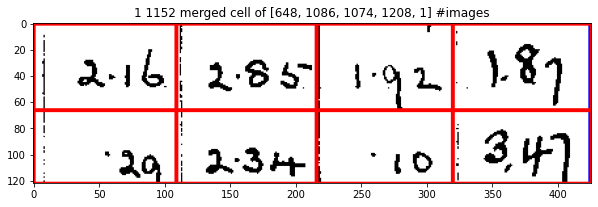

1--1152 just above cell: [648, 1086, 1074, 1152, 1], Current cell: [334, 1152, 1074, 1208, 1], [648, 1152, 1074, 1208, 1], 1.0
collll [[648, 1086, 872, 1141, 1], [872, 1086, 1062, 1141, 1]] 1086_1141
collll [[648, 1141, 872, 1206, 1], [872, 1141, 1062, 1206, 1]] 1141_1206
[[648, 1086, 872, 1141, 1], [872, 1086, 1062, 1141, 1], [648, 1141, 872, 1206, 1], [872, 1141, 1062, 1206, 1]]
1 cur_cell info: [650, 1087, 874, 1142, 1]


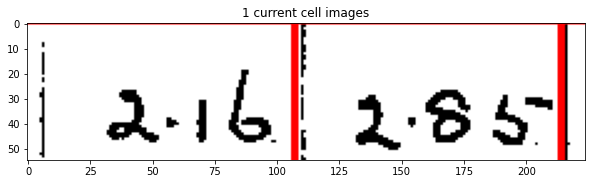

1 cur_cell info: [874, 1087, 1064, 1142, 1]


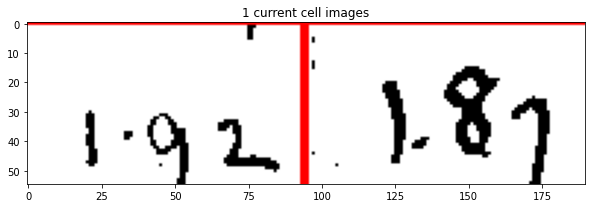

1 cur_cell info: [650, 1142, 874, 1207, 1]


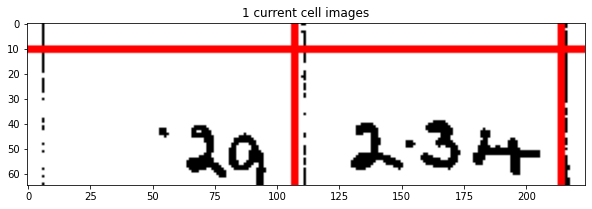

1 cur_cell info: [874, 1142, 1064, 1207, 1]


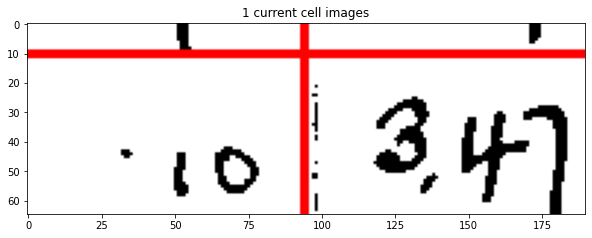

-----Above-----

1 overlap score: 0.0 0.0
collll [[334, 1152, 555, 1206, 1], [555, 1152, 757, 1206, 1]] 1152_1206
collll [[334, 1206, 555, 1269, 1], [555, 1206, 757, 1269, 1]] 1206_1269
[[334, 1152, 555, 1206, 1], [555, 1152, 757, 1206, 1], [334, 1206, 555, 1269, 1], [555, 1206, 757, 1269, 1]]
2--1152 just below cell: [334, 1208, 757, 1281, 1], Current cell: [334, 1152, 1074, 1208, 1], [334, 1152, 757, 1208, 1] 0.5716216216216217


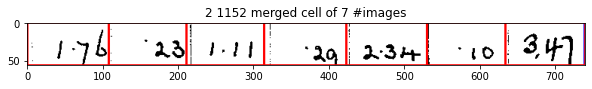

2 cur_cell info: [336, 1153, 557, 1207, 1]


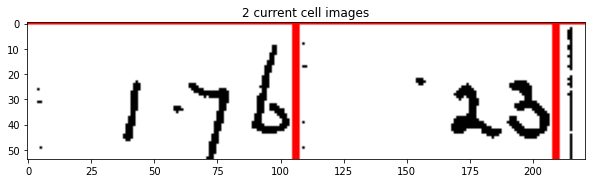

2 cur_cell info: [557, 1153, 759, 1207, 1]


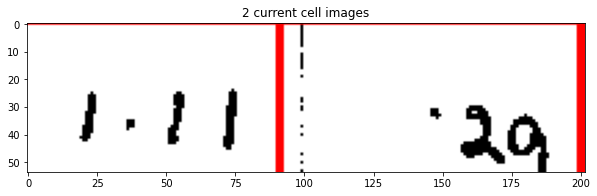

2 cur_cell info: [336, 1207, 557, 1270, 1]


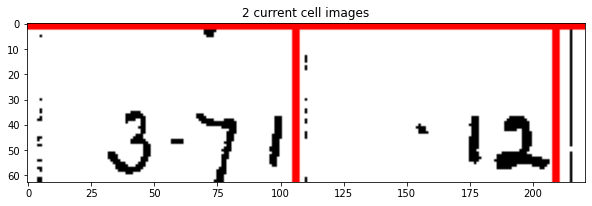

2 cur_cell info: [557, 1207, 759, 1270, 1]


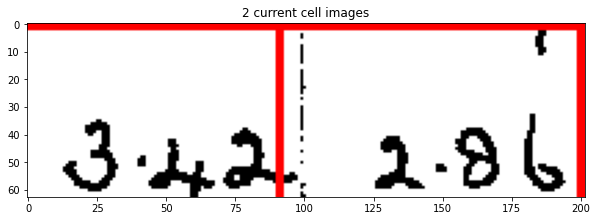

-----Below-----

============1208================== 
Above cells:[[334, 1152, 1074, 1208, 1]] 
Current cells: [[334, 1208, 757, 1281, 1], [1074, 1208, 1281, 1281, 1]] 
Below cells: []
1 overlap score: 0.5716216216216217 1.0
1 cell info: [334, 1152, 1074, 1208, 1] [334, 1208, 757, 1281, 1] [334, 1152, 1074, 1281, 1]


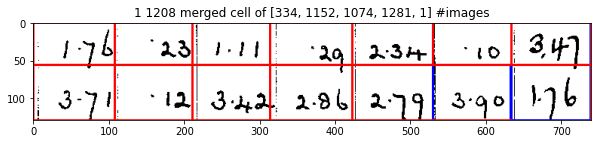

1--1208 just above cell: [334, 1152, 1074, 1208, 1], Current cell: [334, 1208, 757, 1281, 1], [334, 1208, 1074, 1281, 1], 0.5716216216216217
collll [[334, 1152, 555, 1206, 1], [555, 1152, 672, 1206, 1], [672, 1152, 873, 1206, 1], [873, 1152, 1062, 1206, 1]] 1152_1206
collll [[334, 1206, 555, 1274, 1], [555, 1206, 672, 1274, 1], [672, 1206, 873, 1274, 1], [873, 1206, 1062, 1274, 1]] 1206_1274
[[334, 1152, 555, 1206, 1], [555, 1152, 672, 1206, 1], [672, 1152, 873, 1206, 1], [873, 1152, 1062, 1206, 1], [334, 1206, 555, 1274, 1], [555, 1206, 672, 1274, 1], [672, 1206, 873, 1274, 1], [873, 1206, 1062, 1274, 1]]
1 cur_cell info: [336, 1153, 557, 1207, 1]


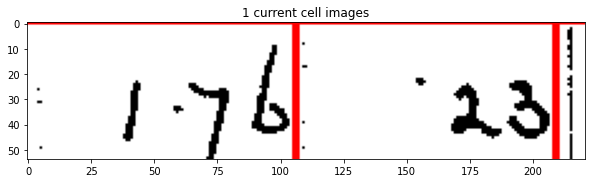

1 cur_cell info: [557, 1153, 674, 1207, 1]


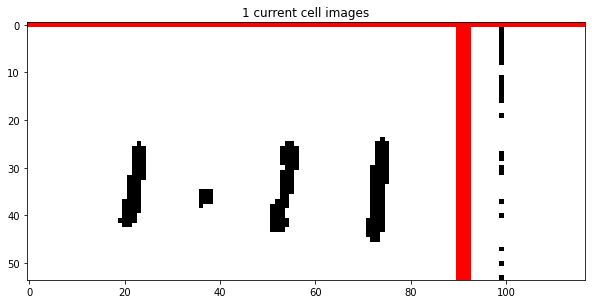

1 cur_cell info: [674, 1153, 875, 1207, 1]


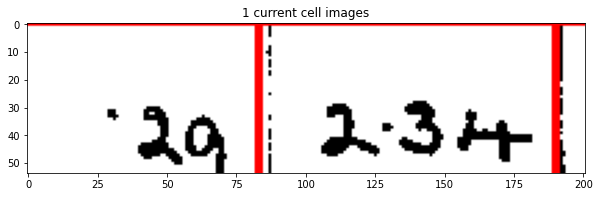

1 cur_cell info: [875, 1153, 1064, 1207, 1]


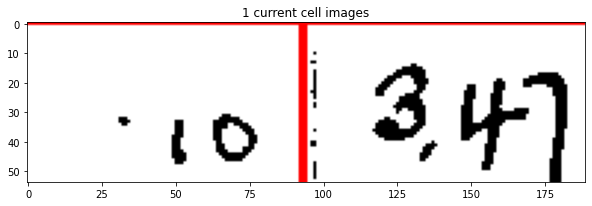

1 cur_cell info: [336, 1207, 557, 1275, 1]


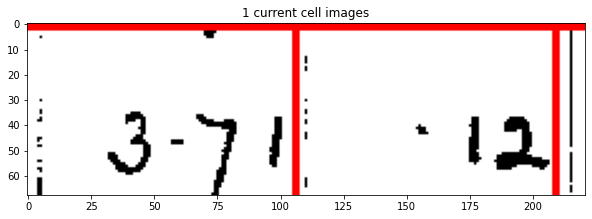

1 cur_cell info: [557, 1207, 674, 1275, 1]


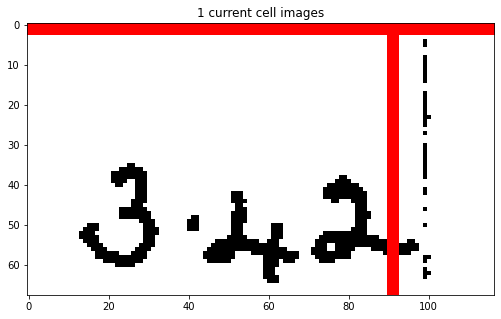

1 cur_cell info: [674, 1207, 875, 1275, 1]


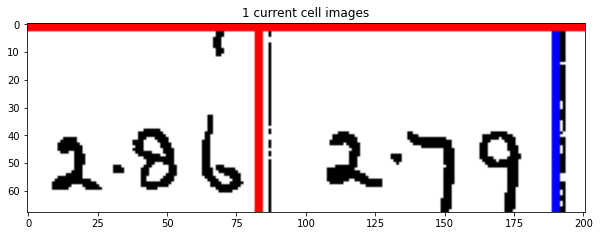

1 cur_cell info: [875, 1207, 1064, 1275, 1]


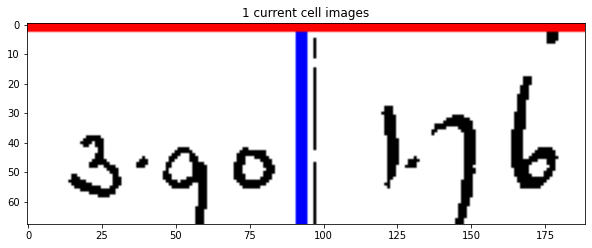

-----Above-----

1 overlap score: 0.0 0.0
============1281================== 
Above cells:[[334, 1208, 757, 1281, 1], [1074, 1208, 1281, 1281, 1]] 
Current cells: [[146, 1281, 968, 1344, 1]] 
Below cells: [[146, 1344, 864, 1408, 1], [968, 1344, 1177, 1408, 1]]
1 overlap score: 1.0 0.5145985401459854
1 cell info: [334, 1208, 757, 1281, 1] [146, 1281, 968, 1344, 1] [334, 1208, 757, 1344, 1]


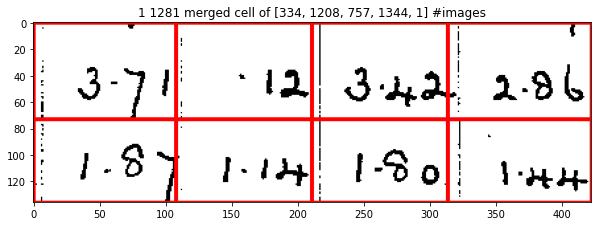

1--1281 just above cell: [334, 1208, 757, 1281, 1], Current cell: [146, 1281, 968, 1344, 1], [334, 1281, 757, 1344, 1], 1.0
collll [[334, 1208, 757, 1269, 1]] 1208_1269
collll [[334, 1269, 757, 1336, 1]] 1269_1336
[[334, 1208, 757, 1269, 1], [334, 1269, 757, 1336, 1]]
1 cur_cell info: [336, 1209, 759, 1270, 1]


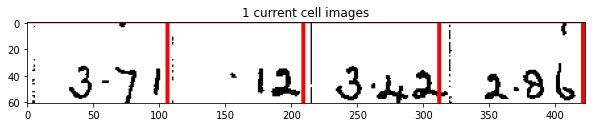

1 cur_cell info: [336, 1270, 759, 1337, 1]


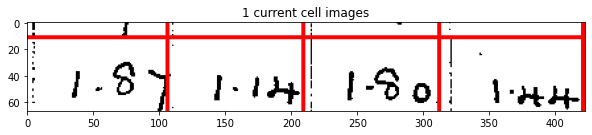

-----Above-----

1 overlap score: 0.0 0.0
collll [[146, 1281, 344, 1336, 1], [344, 1281, 864, 1336, 1]] 1281_1336
collll [[146, 1336, 344, 1402, 1], [344, 1336, 864, 1402, 1]] 1336_1402
[[146, 1281, 344, 1336, 1], [344, 1281, 864, 1336, 1], [146, 1336, 344, 1402, 1], [344, 1336, 864, 1402, 1]]
2--1281 just below cell: [146, 1344, 864, 1408, 1], Current cell: [146, 1281, 968, 1344, 1], [146, 1281, 864, 1344, 1] 0.8734793187347932


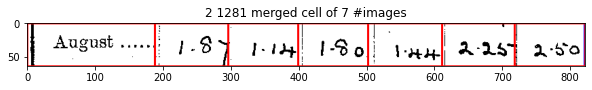

2 cur_cell info: [148, 1282, 346, 1337, 1]


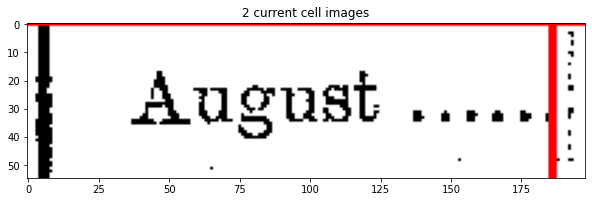

2 cur_cell info: [346, 1282, 866, 1337, 1]


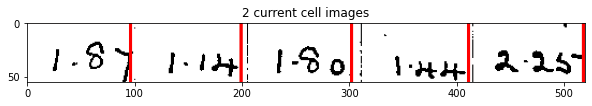

2 cur_cell info: [148, 1337, 346, 1403, 1]


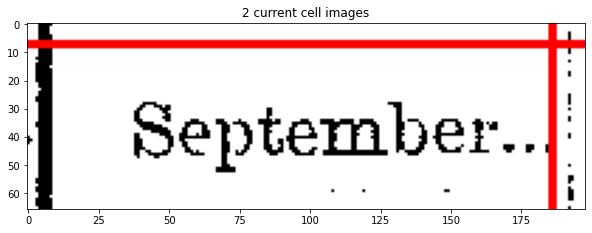

2 cur_cell info: [346, 1337, 866, 1403, 1]


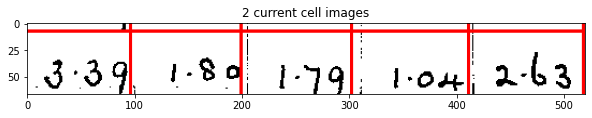

-----Below-----

============1344================== 
Above cells:[[146, 1281, 968, 1344, 1]] 
Current cells: [[146, 1344, 864, 1408, 1], [968, 1344, 1177, 1408, 1]] 
Below cells: [[334, 1408, 757, 1485, 1], [1388, 1408, 1562, 1485, 1]]
1 overlap score: 0.8734793187347932 1.0
1 cell info: [146, 1281, 968, 1344, 1] [146, 1344, 864, 1408, 1] [146, 1281, 968, 1408, 1]


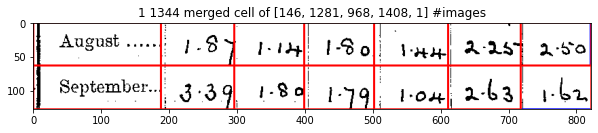

1--1344 just above cell: [146, 1281, 968, 1344, 1], Current cell: [146, 1344, 864, 1408, 1], [146, 1344, 968, 1408, 1], 0.8734793187347932
collll [[146, 1281, 344, 1336, 1], [344, 1281, 773, 1336, 1], [773, 1281, 876, 1336, 1], [876, 1281, 967, 1336, 1]] 1281_1336
collll [[146, 1336, 344, 1402, 1], [344, 1336, 773, 1402, 1], [773, 1336, 876, 1402, 1], [876, 1336, 967, 1402, 1]] 1336_1402
[[146, 1281, 344, 1336, 1], [344, 1281, 773, 1336, 1], [773, 1281, 876, 1336, 1], [876, 1281, 967, 1336, 1], [146, 1336, 344, 1402, 1], [344, 1336, 773, 1402, 1], [773, 1336, 876, 1402, 1], [876, 1336, 967, 1402, 1]]
1 cur_cell info: [148, 1282, 346, 1337, 1]


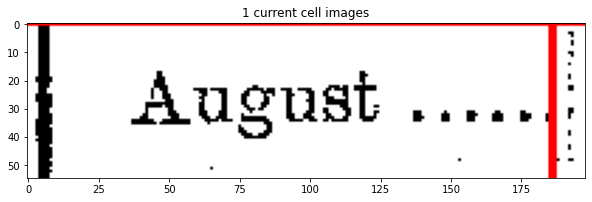

1 cur_cell info: [346, 1282, 775, 1337, 1]


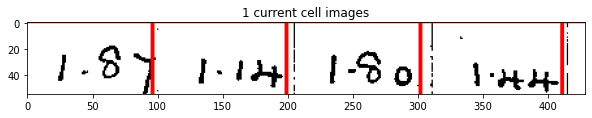

1 cur_cell info: [775, 1282, 878, 1337, 1]


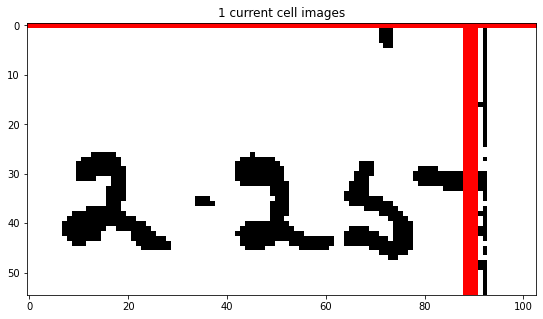

1 cur_cell info: [878, 1282, 969, 1337, 1]


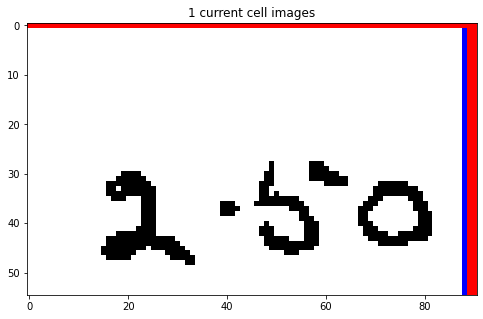

1 cur_cell info: [148, 1337, 346, 1403, 1]


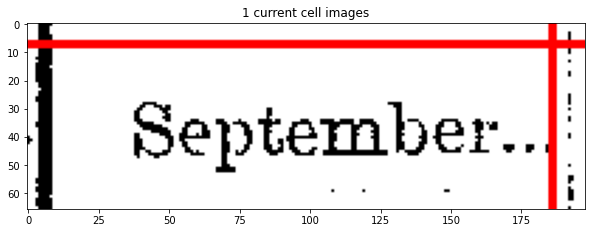

1 cur_cell info: [346, 1337, 775, 1403, 1]


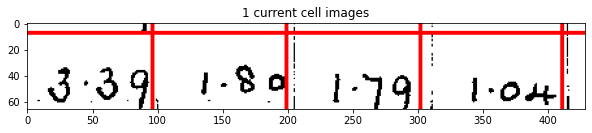

1 cur_cell info: [775, 1337, 878, 1403, 1]


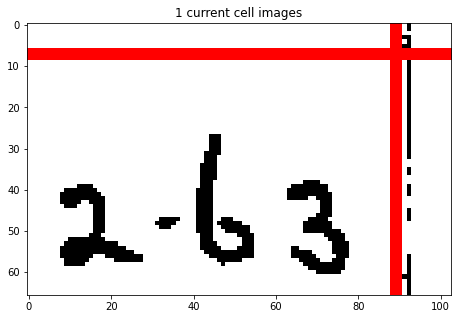

1 cur_cell info: [878, 1337, 969, 1403, 1]


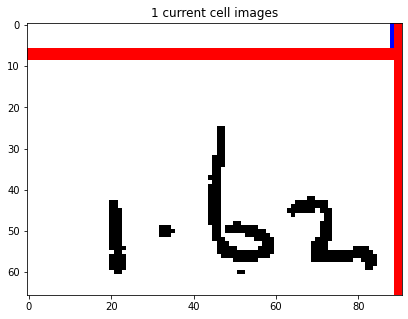

-----Above-----

collll [[334, 1344, 757, 1402, 1]] 1344_1402
collll [[334, 1402, 757, 1471, 1]] 1402_1471
[[334, 1344, 757, 1402, 1], [334, 1402, 757, 1471, 1]]
2--1344 just below cell: [334, 1408, 757, 1485, 1], Current cell: [146, 1344, 864, 1408, 1], [334, 1344, 757, 1408, 1] 0.5891364902506964


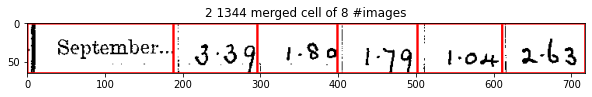

2 cur_cell info: [336, 1345, 759, 1403, 1]


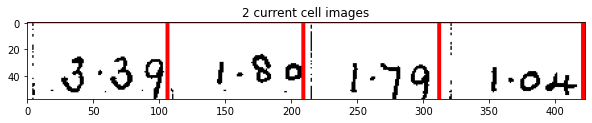

2 cur_cell info: [336, 1403, 759, 1472, 1]


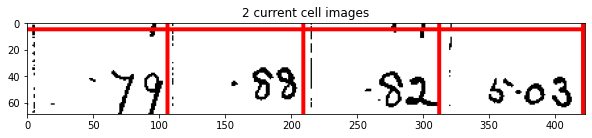

-----Below-----

1 overlap score: 0.0 0.0
============1408================== 
Above cells:[[146, 1344, 864, 1408, 1], [968, 1344, 1177, 1408, 1]] 
Current cells: [[334, 1408, 757, 1485, 1], [1388, 1408, 1562, 1485, 1]] 
Below cells: []
1 overlap score: 0.5891364902506964 1.0
1 cell info: [146, 1344, 864, 1408, 1] [334, 1408, 757, 1485, 1] [146, 1344, 864, 1485, 1]


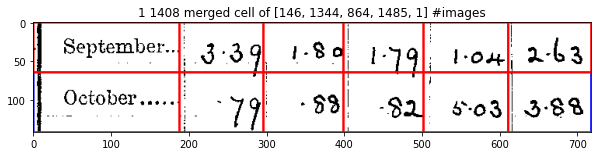

1--1408 just above cell: [146, 1344, 864, 1408, 1], Current cell: [334, 1408, 757, 1485, 1], [146, 1408, 864, 1485, 1], 0.5891364902506964
collll [[146, 1344, 344, 1402, 1], [344, 1344, 772, 1402, 1], [772, 1344, 858, 1402, 1]] 1344_1402
collll [[146, 1402, 344, 1471, 1], [344, 1402, 772, 1471, 1], [772, 1402, 858, 1471, 1]] 1402_1471
[[146, 1344, 344, 1402, 1], [344, 1344, 772, 1402, 1], [772, 1344, 858, 1402, 1], [146, 1402, 344, 1471, 1], [344, 1402, 772, 1471, 1], [772, 1402, 858, 1471, 1]]
1 cur_cell info: [148, 1345, 346, 1403, 1]


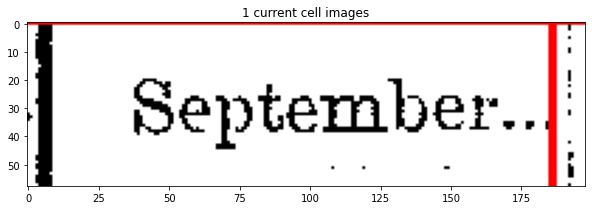

1 cur_cell info: [346, 1345, 774, 1403, 1]


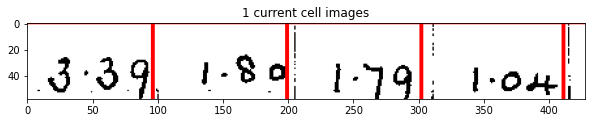

1 cur_cell info: [774, 1345, 860, 1403, 1]


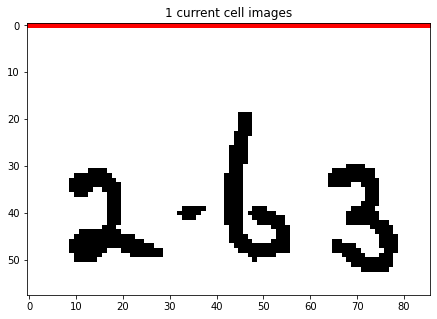

1 cur_cell info: [148, 1403, 346, 1472, 1]


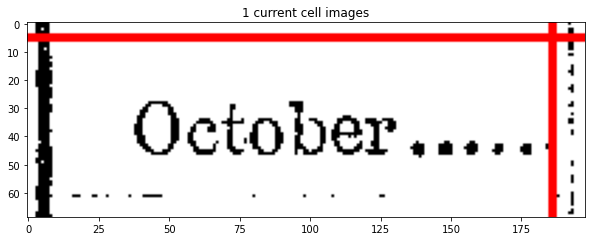

1 cur_cell info: [346, 1403, 774, 1472, 1]


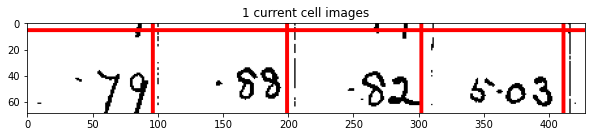

1 cur_cell info: [774, 1403, 860, 1472, 1]


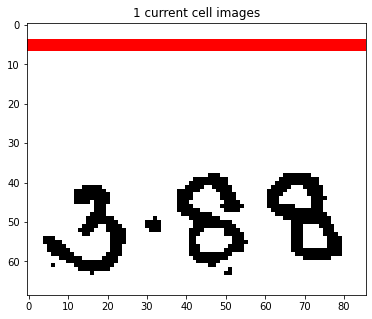

-----Above-----

1 overlap score: 0.0 0.0
1 overlap score: 0.0 0.0
1 overlap score: 0.0 0.0
============1485================== 
Above cells:[[334, 1408, 757, 1485, 1], [1388, 1408, 1562, 1485, 1]] 
Current cells: [[146, 1485, 864, 1551, 1]] 
Below cells: [[334, 1551, 864, 1619, 1], [1074, 1551, 1562, 1619, 1]]
1 overlap score: 1.0 0.5891364902506964
1 cell info: [334, 1408, 757, 1485, 1] [146, 1485, 864, 1551, 1] [334, 1408, 757, 1551, 1]


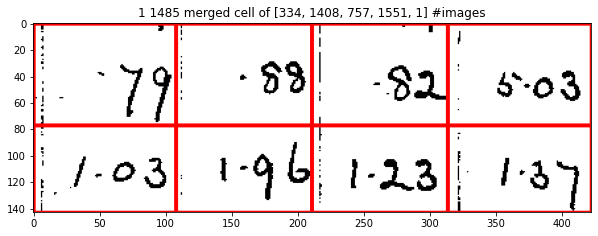

1--1485 just above cell: [334, 1408, 757, 1485, 1], Current cell: [146, 1485, 864, 1551, 1], [334, 1485, 757, 1551, 1], 1.0
collll [[334, 1408, 757, 1471, 1]] 1408_1471
collll [[334, 1471, 757, 1536, 1]] 1471_1536
[[334, 1408, 757, 1471, 1], [334, 1471, 757, 1536, 1]]
1 cur_cell info: [336, 1409, 759, 1472, 1]


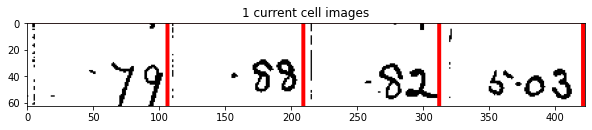

1 cur_cell info: [336, 1472, 759, 1537, 1]


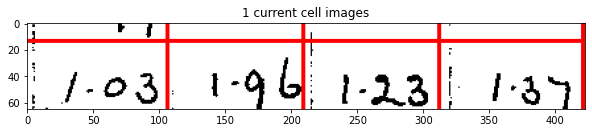

-----Above-----

1 overlap score: 0.0 0.0
collll [[334, 1485, 663, 1536, 1], [663, 1485, 860, 1536, 1]] 1485_1536
collll [[334, 1536, 663, 1600, 1], [663, 1536, 860, 1600, 1]] 1536_1600
[[334, 1485, 663, 1536, 1], [663, 1485, 860, 1536, 1], [334, 1536, 663, 1600, 1], [663, 1536, 860, 1600, 1]]
2--1485 just below cell: [334, 1551, 864, 1619, 1], Current cell: [146, 1485, 864, 1551, 1], [334, 1485, 864, 1551, 1] 0.7381615598885793


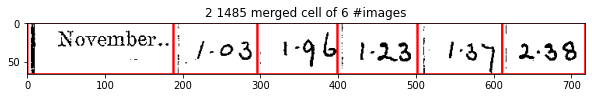

2 cur_cell info: [336, 1486, 665, 1537, 1]


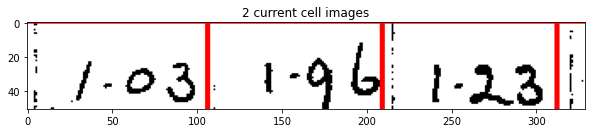

2 cur_cell info: [665, 1486, 862, 1537, 1]


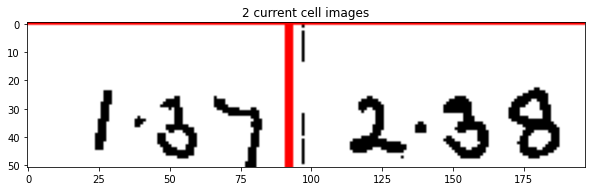

2 cur_cell info: [336, 1537, 665, 1601, 1]


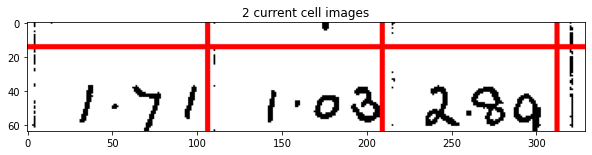

2 cur_cell info: [665, 1537, 862, 1601, 1]


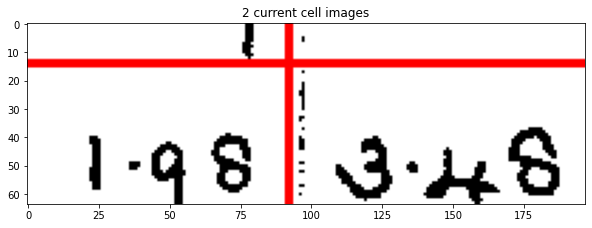

-----Below-----

============1551================== 
Above cells:[[146, 1485, 864, 1551, 1]] 
Current cells: [[334, 1551, 864, 1619, 1], [1074, 1551, 1562, 1619, 1]] 
Below cells: [[146, 1619, 1562, 1728, 1]]
1 overlap score: 0.7381615598885793 1.0
1 cell info: [146, 1485, 864, 1551, 1] [334, 1551, 864, 1619, 1] [146, 1485, 864, 1619, 1]


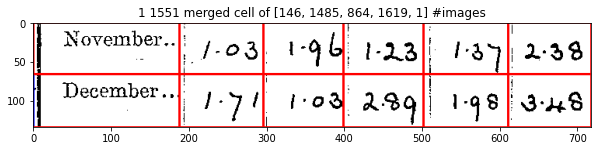

1--1551 just above cell: [146, 1485, 864, 1551, 1], Current cell: [334, 1551, 864, 1619, 1], [146, 1551, 864, 1619, 1], 0.7381615598885793
collll [[146, 1485, 347, 1536, 1], [347, 1485, 663, 1536, 1], [663, 1485, 860, 1536, 1]] 1485_1536
collll [[146, 1536, 347, 1600, 1], [347, 1536, 663, 1600, 1], [663, 1536, 860, 1600, 1]] 1536_1600
[[146, 1485, 347, 1536, 1], [347, 1485, 663, 1536, 1], [663, 1485, 860, 1536, 1], [146, 1536, 347, 1600, 1], [347, 1536, 663, 1600, 1], [663, 1536, 860, 1600, 1]]
1 cur_cell info: [148, 1486, 349, 1537, 1]


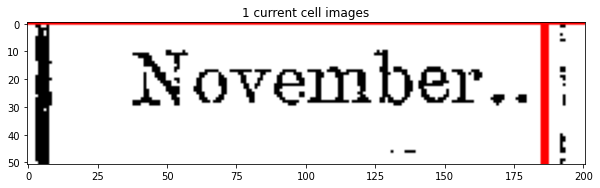

1 cur_cell info: [349, 1486, 665, 1537, 1]


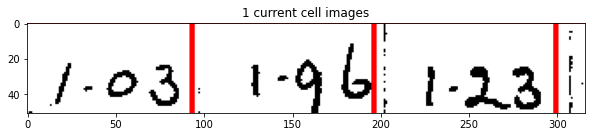

1 cur_cell info: [665, 1486, 862, 1537, 1]


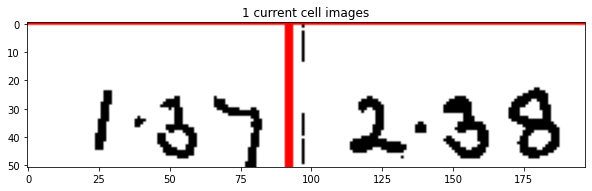

1 cur_cell info: [148, 1537, 349, 1601, 1]


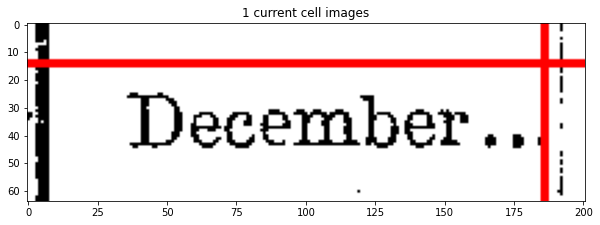

1 cur_cell info: [349, 1537, 665, 1601, 1]


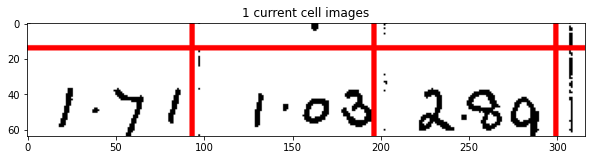

1 cur_cell info: [665, 1537, 862, 1601, 1]


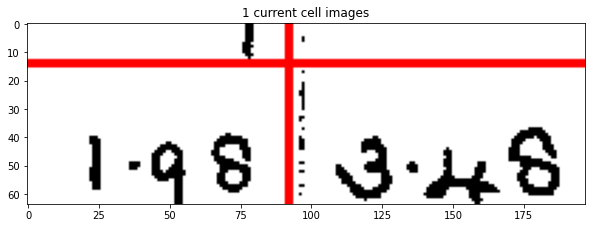

-----Above-----

collll [[146, 1551, 974, 1600, 1], [974, 1551, 1289, 1600, 1], [1289, 1551, 1562, 1600, 1]] 1551_1600
collll [[146, 1600, 974, 1661, 1], [974, 1600, 1289, 1661, 1], [1289, 1600, 1562, 1661, 1]] 1600_1661
collll [[146, 1661, 974, 1728, 1], [974, 1661, 1289, 1728, 1], [1289, 1661, 1562, 1728, 1]] 1661_1728
[[146, 1551, 974, 1600, 1], [974, 1551, 1289, 1600, 1], [1289, 1551, 1562, 1600, 1], [146, 1600, 974, 1661, 1], [974, 1600, 1289, 1661, 1], [1289, 1600, 1562, 1661, 1], [146, 1661, 974, 1728, 1], [974, 1661, 1289, 1728, 1], [1289, 1661, 1562, 1728, 1]]
2--1551 just below cell: [146, 1619, 1562, 1728, 1], Current cell: [334, 1551, 864, 1619, 1], [146, 1551, 1562, 1619, 1] 1.0


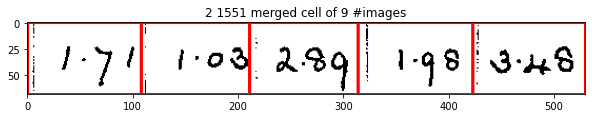

2 cur_cell info: [148, 1552, 976, 1601, 1]


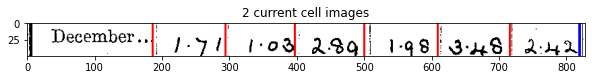

2 cur_cell info: [976, 1552, 1291, 1601, 1]


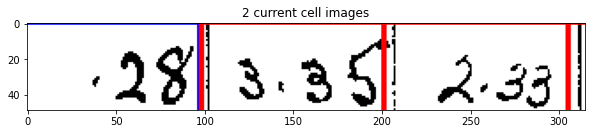

2 cur_cell info: [1291, 1552, 1564, 1631, 1]


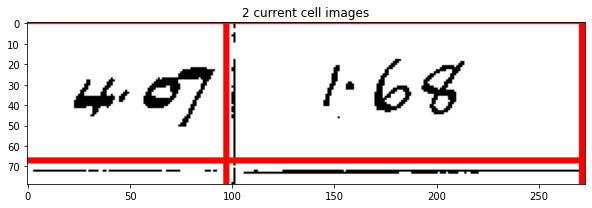

2 cur_cell info: [148, 1631, 976, 1729, 1]


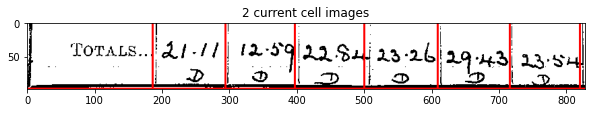

2 cur_cell info: [976, 1662, 1291, 1729, 1]


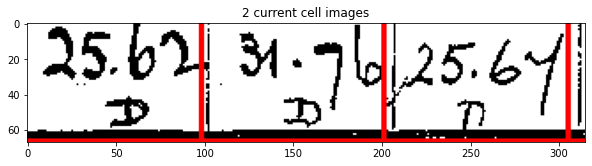

2 cur_cell info: [1291, 1662, 1564, 1729, 1]


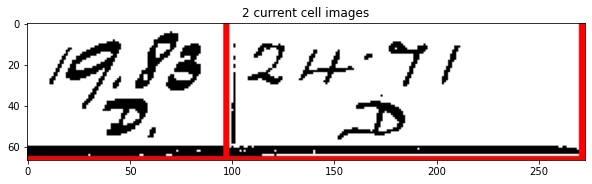

-----Below-----

1 overlap score: 0.0 0.0
collll [[146, 1551, 974, 1600, 1], [974, 1551, 1289, 1600, 1], [1289, 1551, 1562, 1600, 1]] 1551_1600
collll [[146, 1600, 974, 1661, 1], [974, 1600, 1289, 1661, 1], [1289, 1600, 1562, 1661, 1]] 1600_1661
collll [[146, 1661, 974, 1728, 1], [974, 1661, 1289, 1728, 1], [1289, 1661, 1562, 1728, 1]] 1661_1728
[[146, 1551, 974, 1600, 1], [974, 1551, 1289, 1600, 1], [1289, 1551, 1562, 1600, 1], [146, 1600, 974, 1661, 1], [974, 1600, 1289, 1661, 1], [1289, 1600, 1562, 1661, 1], [146, 1661, 974, 1728, 1], [974, 1661, 1289, 1728, 1], [1289, 1661, 1562, 1728, 1]]
2--1551 just below cell: [146, 1619, 1562, 1728, 1], Current cell: [1074, 1551, 1562, 1619, 1], [146, 1551, 1562, 1619, 1] 1.0


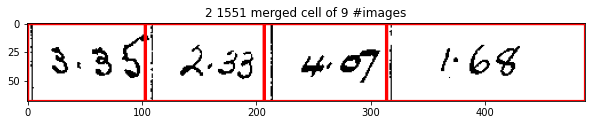

2 cur_cell info: [148, 1552, 976, 1601, 1]


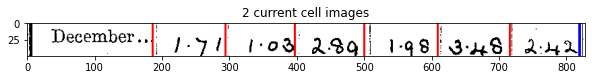

2 cur_cell info: [976, 1552, 1291, 1601, 1]


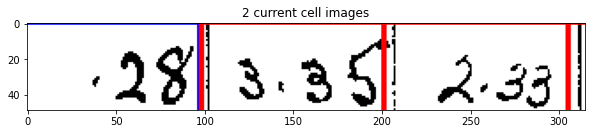

2 cur_cell info: [1291, 1552, 1564, 1631, 1]


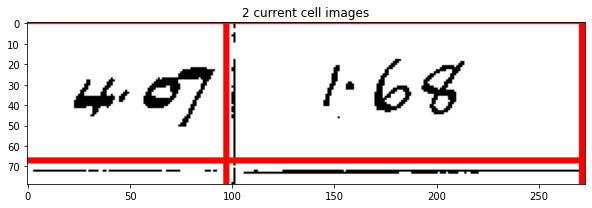

2 cur_cell info: [148, 1631, 976, 1729, 1]


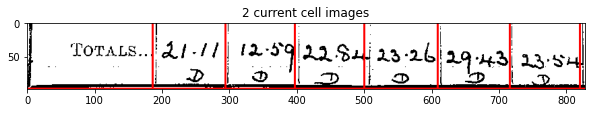

2 cur_cell info: [976, 1662, 1291, 1729, 1]


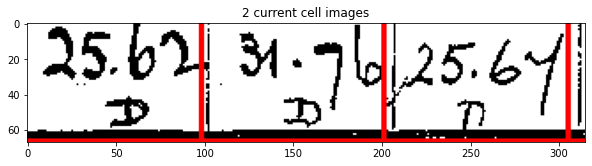

2 cur_cell info: [1291, 1662, 1564, 1729, 1]


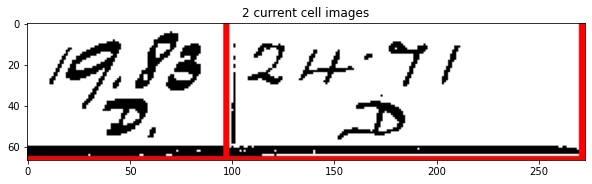

-----Below-----

============1619================== 
Above cells:[[334, 1551, 864, 1619, 1], [1074, 1551, 1562, 1619, 1]] 
Current cells: [[146, 1619, 1562, 1728, 1]] 
Below cells: []
1 overlap score: 1.0 0.3742937853107345
1 cell info: [334, 1551, 864, 1619, 1] [146, 1619, 1562, 1728, 1] [334, 1551, 864, 1728, 1]


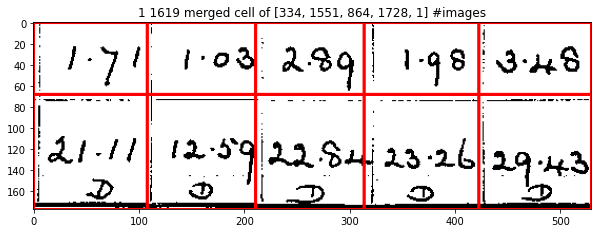

1--1619 just above cell: [334, 1551, 864, 1619, 1], Current cell: [146, 1619, 1562, 1728, 1], [334, 1619, 864, 1728, 1], 1.0
collll [[334, 1551, 864, 1614, 1]] 1551_1614
collll [[334, 1614, 864, 1699, 1]] 1614_1699
collll [[334, 1699, 864, 1728, 1]] 1699_1728
[[334, 1551, 864, 1614, 1], [334, 1614, 864, 1699, 1], [334, 1699, 864, 1728, 1]]
1 cur_cell info: [336, 1552, 866, 1615, 1]


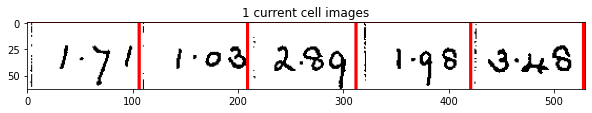

1 cur_cell info: [336, 1615, 866, 1700, 1]


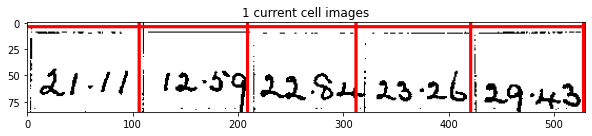

-----Above-----

1 overlap score: 1.0 0.3446327683615819
1 cell info: [1074, 1551, 1562, 1619, 1] [146, 1619, 1562, 1728, 1] [1074, 1551, 1562, 1728, 1]


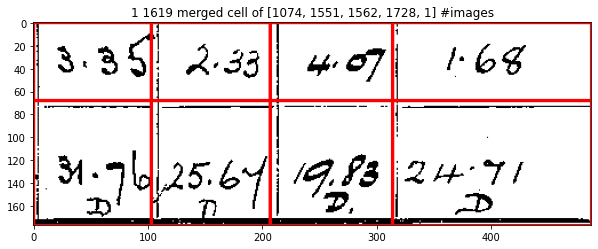

1--1619 just above cell: [1074, 1551, 1562, 1619, 1], Current cell: [146, 1619, 1562, 1728, 1], [1074, 1619, 1562, 1728, 1], 1.0
collll [[1074, 1551, 1289, 1600, 1], [1289, 1551, 1562, 1600, 1]] 1551_1600
collll [[1074, 1600, 1289, 1666, 1], [1289, 1600, 1562, 1666, 1]] 1600_1666
collll [[1074, 1666, 1289, 1728, 1], [1289, 1666, 1562, 1728, 1]] 1666_1728
[[1074, 1551, 1289, 1600, 1], [1289, 1551, 1562, 1600, 1], [1074, 1600, 1289, 1666, 1], [1289, 1600, 1562, 1666, 1], [1074, 1666, 1289, 1728, 1], [1289, 1666, 1562, 1728, 1]]
1 cur_cell info: [1076, 1552, 1291, 1601, 1]


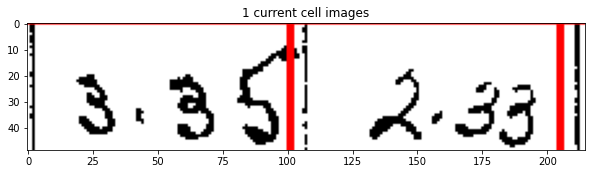

1 cur_cell info: [1291, 1552, 1564, 1634, 1]


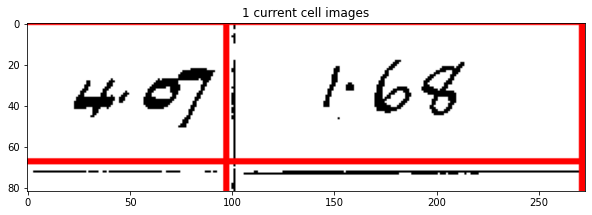

1 cur_cell info: [1076, 1634, 1291, 1729, 1]


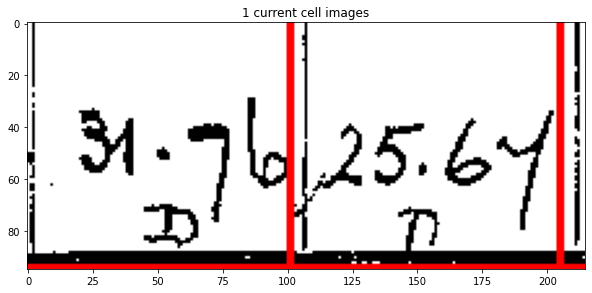

1 cur_cell info: [1291, 1667, 1564, 1729, 1]


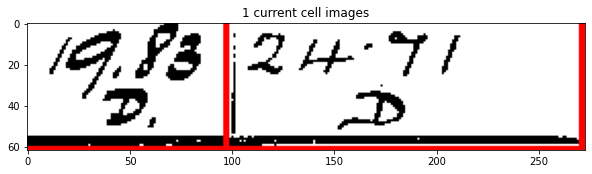

-----Above-----



In [24]:
# combine x and y neighbours v2

error_corrected_cells = []
not_corrected_cells = []

if len(x_y_neighbouring_cells_dict)>2:
    for yid in x_y_neighbouring_cells_dict:
    #     print(yid)
        ynid, xnid = x_y_neighbouring_cells_dict[yid]

        if len(ynid) == 0:             
            new_corrected, not_corrected = classify_error_cells(xnid, tables, masks[1], average_cordinates,0.7) # correct single error cell or declare error            
            if len(error_corrected_cells)>0:
                new_corrected, error_corrected_cells = find_overlapped_cell(error_corrected_cells, new_corrected, average_cordinates)
            
            error_corrected_cells+=new_corrected

            if len(not_corrected)>0:
                for cell in not_corrected:                
                    tid = cell[4]
                    avg_x, avg_y = average_cordinates[tid]
                    tab_boundary = list(map(int, tables[tid]))

                    move = cell[5]

                    for idx,i in enumerate(move):
                        if i == 0:
                            if abs(cell[idx]-tab_boundary[idx])<avg_y/3:
                                cell[idx] = tab_boundary[idx]
                                move[idx] = 5

                    if 0 in move:
                        not_corrected_cells+=not_corrected

                    else:
                        cell[5] =  move

                        if len(error_corrected_cells)>0:
                            cell, error_corrected_cells = find_overlapped_cell(error_corrected_cells, [cell], average_cordinates)
                            error_corrected_cells+=cell
    #                     print(cell, imagedraw[idx],tab_boundary[idx], avg_y/3, abs(cell[idx]-tab_boundary[idx]))

        elif len(xnid)>0: #multiple neighbours
    #         print(ynid, yid)
            above_cells = []
            cur_cells = []
            below_cells = []
            for y_n in ynid:
                if y_n < yid:
    #                 print(y_n, yid)
                    above_cells = x_y_neighbouring_cells_dict[y_n][1]
                else:
                    cur_cells = xnid

                    below_cells = x_y_neighbouring_cells_dict[y_n][1]
            print(f'============{yid}================== \nAbove cells:{above_cells} \nCurrent cells: {xnid} \nBelow cells: {below_cells}')

            for cell in xnid:
                anchor = list(cell)  

                tid = cell[4]
                avg_x, avg_y = average_cordinates[tid]

                step_x = int(avg_x*0.025)
                step_y = int(avg_y*0.025)

                tab_boundary = list(map(int, tables[tid]))

                #check above first:
                for a_cell in above_cells:
                    anchor_a = list(a_cell)
                    anchor_a[1] = anchor[1] # change the y-coordinates to see overlapping or not and if overlapped the cell is immediate neighbour
                    anchor_a[3] = anchor[3]
                    score1 = tsa.how_much_contained(anchor_a, cell)
                    score2 = tsa.how_much_contained(cell,anchor_a)
                    
                    print('1 overlap score:',score1,score2)

                    if score1>0.5:
                        merged_cell = list(a_cell)
                        merged_cell[3] = cell[3]
                    
                        print('1 cell info:',a_cell, cell, merged_cell)
                        
                        croppedimage_full=image[int(merged_cell[1]):int(merged_cell[3]),int(merged_cell[0]):int(merged_cell[2])] 
                        plt.rcParams["figure.figsize"] = (10,5)
                        plt.imshow(croppedimage_full)
                        plt.title(f'1 {yid} merged cell of {merged_cell} #images')
                        plt.show()   

#                         if a_cell[0] < cell[0]:  ## check if a_cell[0] >= cell[0] and change a_cell[0] to cell[0] and a_cell[2] to cell[2] for correction

                        print(f'1--{yid} just above cell: {a_cell}, Current cell: {cell}, {anchor_a}, {score1}')
                        above = True

                        cur_corrected = segment_image(merged_cell, masks[1], average_cordinates)

                        merged_cell = list(cell)
                        merged_cell[1] = a_cell[1]
                        cur_correct_final =[]

                        for cur_cell in cur_corrected:

                            cur_cell[0]+=step_x
                            cur_cell[1]+=step_y
                            cur_cell[2]+=step_x
                            cur_cell[3]+=step_y
                    
                            print('1 cur_cell info:',cur_cell)
                            if check_cell(cur_cell,average_cordinates):
                                croppedimage_full=image[int(cur_cell[1]):int(cur_cell[3]),int(cur_cell[0]):int(cur_cell[2])]  
                                plt.rcParams["figure.figsize"] = (10,5)
                                plt.imshow(croppedimage_full)
                                plt.title(f'1 current cell images')
                                plt.show()
                                cur_correct_final.append(cur_cell)
                        
                        if len(error_corrected_cells)>0:
                            cur_correct_final, error_corrected_cells = find_overlapped_cell(error_corrected_cells, cur_correct_final, average_cordinates)
                            error_corrected_cells += cur_correct_final

                        print('-----Above-----\n')
    #                         pass

    #                         croppedimage_full=image[int(a_cell[1]):int(a_cell[3]),int(a_cell[0]):int(a_cell[2])]  ## check if a_cell[0] >= cell[0] and change a_cell[0] to cell[0] and a_cell[2] to cell[2] for correction
    #                         plt.rcParams["figure.figsize"] = (10,5)
    #                         plt.imshow(croppedimage_full)
    #                         plt.title(f'Issue with above cell image')
    #                         plt.show()

    #                         croppedimage_full=image[int(cell[1]):int(cell[3]),int(cell[0]):int(cell[2])]
    #                         plt.rcParams["figure.figsize"] = (10,5)
    #                         plt.imshow(croppedimage_full)
    #                         plt.title(f'Current cell image')
    #                         plt.show()


                #check below cell:
                for b_cell in below_cells:
                    anchor_b = list(b_cell)
                    anchor_b[1] = anchor[1] # change the y-coordinates to see overlapping or not and if overlapped the cell is immediate neighbour
                    anchor_b[3] = anchor[3]
                    score1 = tsa.how_much_contained(cell,anchor_b)
                    score2 = tsa.how_much_contained(anchor_b, cell)

                    if score1>0.5:
                        
                        merged_cell = list(b_cell)
                        merged_cell[1] = cell[1]
                        cur_correct_final =[]

                        cur_corrected = segment_image(merged_cell, masks[1], average_cordinates)
                        print(f'2--{yid} just below cell: {b_cell}, Current cell: {cell}, {anchor_b} {score1}')

                        merged_cell = list(cell)
                        # merged_cell[3] = b_cell[3]

                        croppedimage_full=image[int(merged_cell[1]):int(merged_cell[3]),int(merged_cell[0]):int(merged_cell[2])]  
                        plt.rcParams["figure.figsize"] = (10,5)
                        plt.imshow(croppedimage_full)
                        plt.title(f'2 {yid} merged cell of {len(y_cords[yid])} #images')
                        plt.show()

                        for cur_cell in cur_corrected:

                            cur_cell[0]+=step_x
                            cur_cell[1]+=step_y
                            cur_cell[2]+=step_x
                            cur_cell[3]+=step_y
                    
                            print('2 cur_cell info:',cur_cell)
                            if check_cell(cur_cell,average_cordinates):

                                croppedimage_full=image[int(cur_cell[1]):int(cur_cell[3]),int(cur_cell[0]):int(cur_cell[2])]  
                                plt.rcParams["figure.figsize"] = (10,5)
                                plt.imshow(croppedimage_full)
                                plt.title(f'2 current cell images')
                                plt.show()
                                cur_correct_final.append(cur_cell)
                        
                        if len(error_corrected_cells)>0:
                            cur_correct_final, error_corrected_cells = find_overlapped_cell(error_corrected_cells, cur_correct_final, average_cordinates)
                            error_corrected_cells += cur_correct_final

                        print('-----Below-----\n')
    #                         pass

    #                         croppedimage_full=image[int(cell[1]):int(cell[3]),int(cell[0]):int(cell[2])]
    #                         plt.rcParams["figure.figsize"] = (10,5)
    #                         plt.imshow(croppedimage_full)
    #                         plt.title(f'Current cell image')
    #                         plt.show()

    #                         croppedimage_full=image[int(b_cell[1]):int(b_cell[3]),int(b_cell[0]):int(b_cell[2])]  ##check if b_cell[0] >= cell[0] and change b_cell[0] to cell[0] and b_cell[2] to cell[2] for correction
    #                         plt.rcParams["figure.figsize"] = (10,5)
    #                         plt.imshow(croppedimage_full)
    #                         plt.title(f'Issue with below cell image')
    #                         plt.show()

    #         print(f'\n')

    #         for imagedraw in xnid:                    
    #             croppedimage_full=image[int(imagedraw[1]):int(imagedraw[3]),int(imagedraw[0]):int(imagedraw[2])]
    #             plt.rcParams["figure.figsize"] = (10,5)
    #             plt.imshow(croppedimage_full)
    #             plt.title(f'Wrong image')
    #             plt.show()

        

In [25]:
new_corrected_excluded_cells = []
not_corrected_cells = []

error_corrected_cells, all_valid_cells =  find_overlapped_cell(all_valid_cells, error_corrected_cells, average_cordinates)

considered_cells = all_valid_cells+error_corrected_cells
if len(error_corrected_cells)>0:
    not_overlap_error_cells, considered_cells =  find_overlapped_cell(considered_cells, not_corrected_excluded_cells, average_cordinates)
    new_corrected_excluded_cells, not_corrected_cells = classify_error_cells(not_overlap_error_cells, tables, masks[1], average_cordinates,0.7)

not_corrected_cells, not_corrected_excluded_cells =  find_overlapped_cell(not_corrected_excluded_cells, not_corrected_cells, average_cordinates)

In [26]:
# # new_corrected_cells =  find_overlapped_cell(all_valid_cells, new_corrected_cells)
considered_cells = all_valid_cells + error_corrected_cells+new_corrected_excluded_cells
not_corrected_excluded_cells, considered_cells =  find_overlapped_cell(considered_cells, not_corrected_excluded_cells+not_corrected_cells, average_cordinates)
# not_corrected_cells = find_overlapped_cell(not_corrected_excluded_cells, not_corrected_cells, average_cordinates)

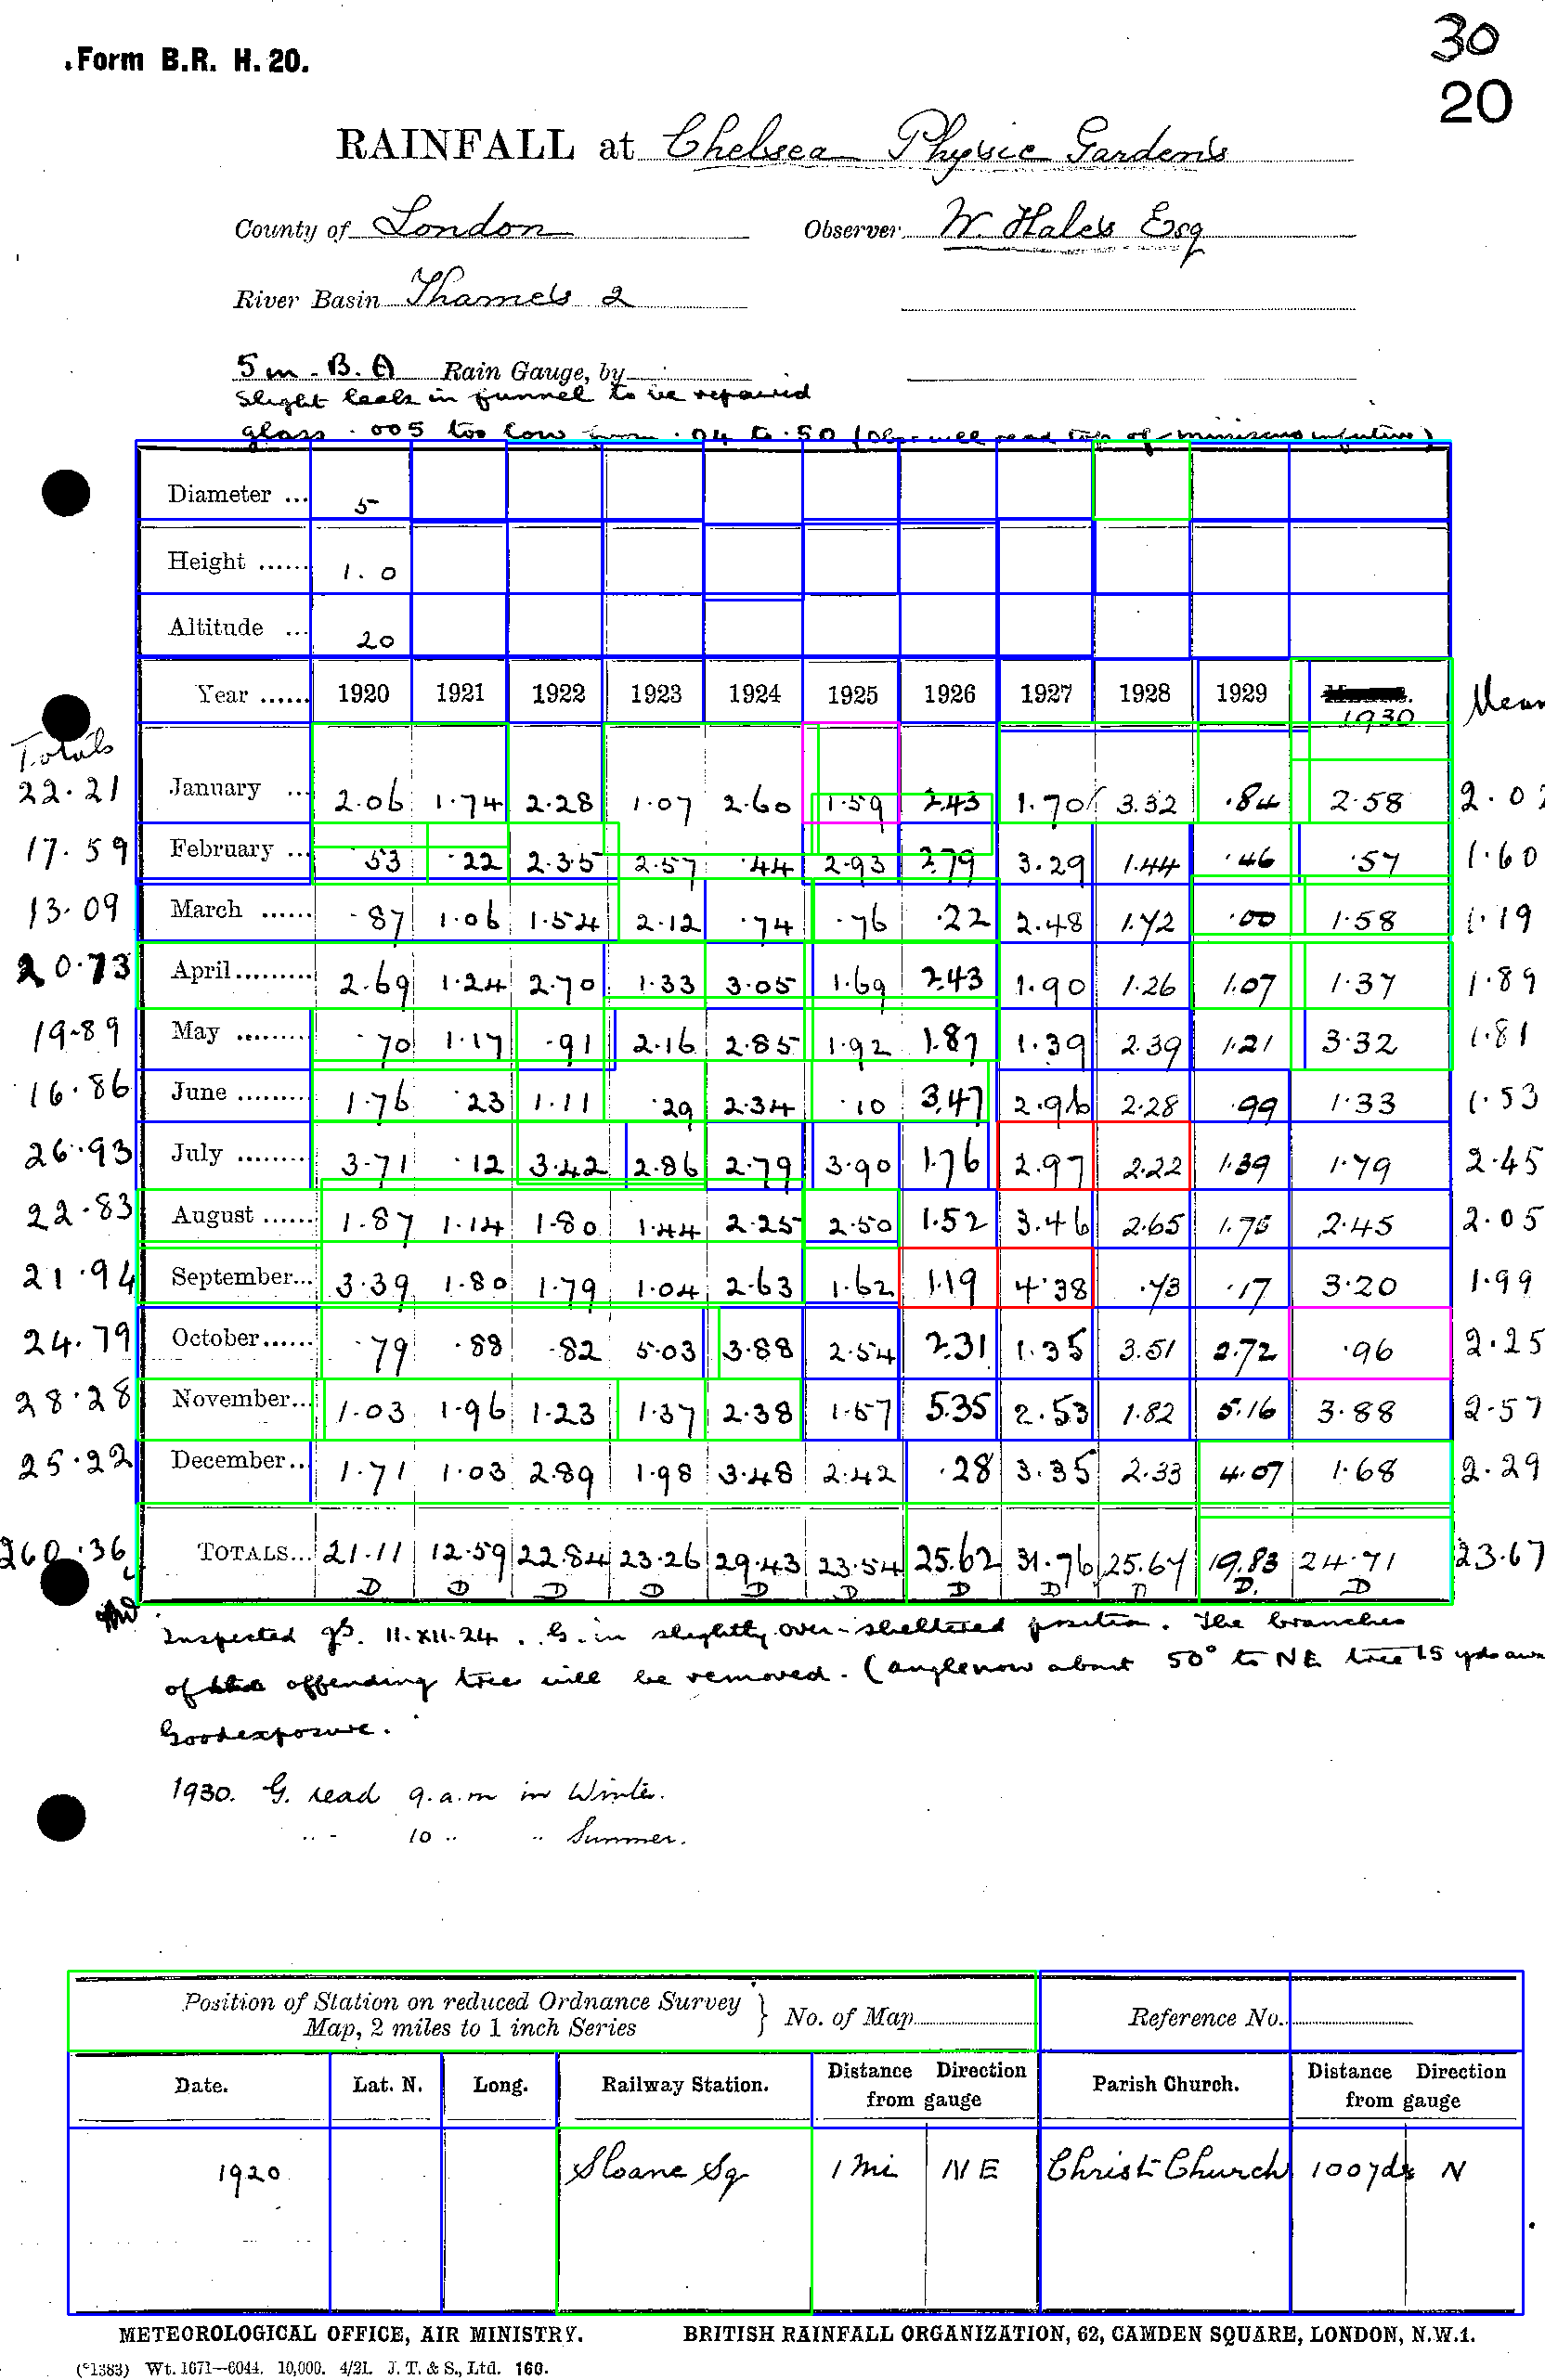

In [29]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in all_valid_cells:
    put_box(image,box,(0,0,color)) # Blue
    
for box in error_corrected_cells:
    put_box(image,box,(0,color,0)) # Green

for box in not_corrected_excluded_cells:
    put_box(image,box,(color,0,0)) # Red
    
for box in new_corrected_excluded_cells:
    put_box(image,box,(color,0,color))  # pink
    
for box in blank_cells:   
    put_box(image,box,(color,color,0)) # Yellow

im_pil = Image.fromarray(image)
# im_pil.save(f"{filename}_temp_cell_multiple_cell_correction.jpg")
im_pil 

In [37]:
all_valid_cells = all_valid_cells+error_corrected_cells+new_corrected_excluded_cells
correct_cells, blank_cells_new, exclude_cells_new = classify_cells(all_valid_cells, masks[1], average_cordinates)
new_corrected_excluded_cells, not_corrected_cells = classify_error_cells(exclude_cells_new, tables, masks[1], average_cordinates,0.7)

In [39]:
exclude_cells_new, new_corrected_excluded_cells_v2 =  find_overlapped_cell(new_corrected_excluded_cells, exclude_cells_new, average_cordinates)


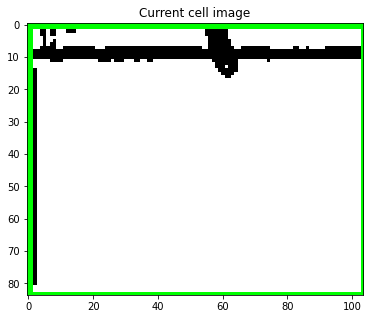

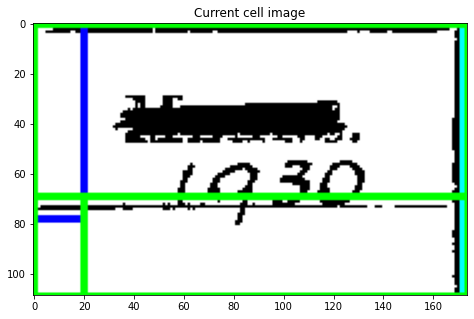

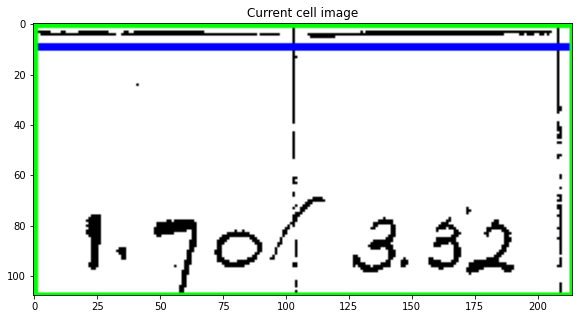

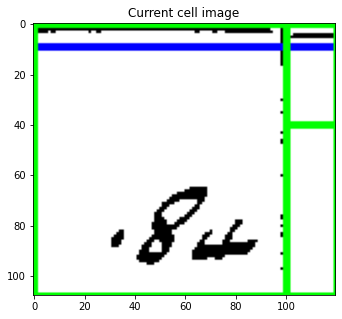

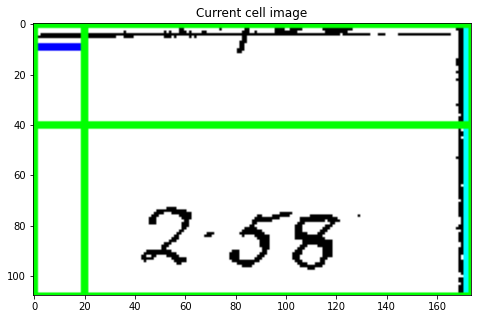

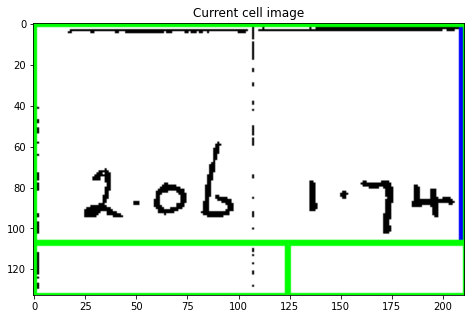

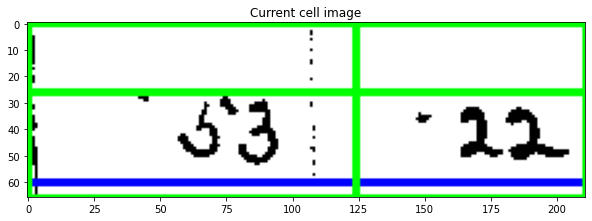

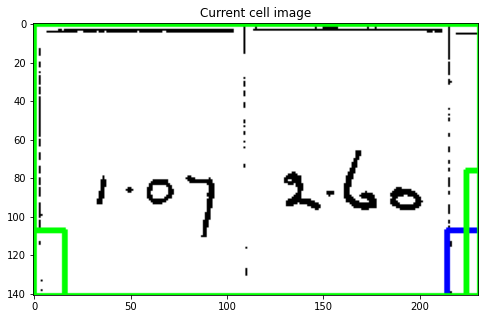

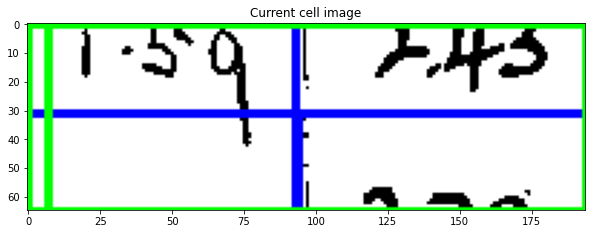

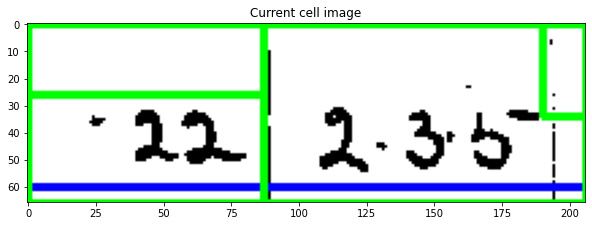

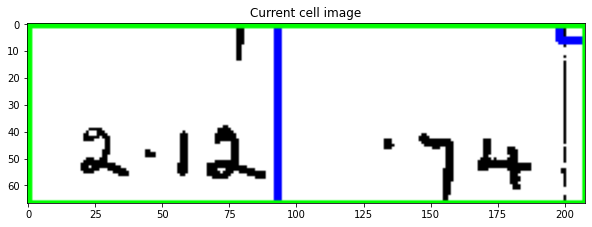

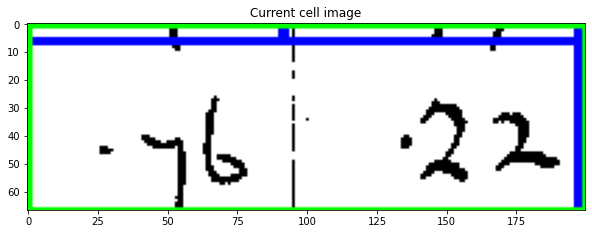

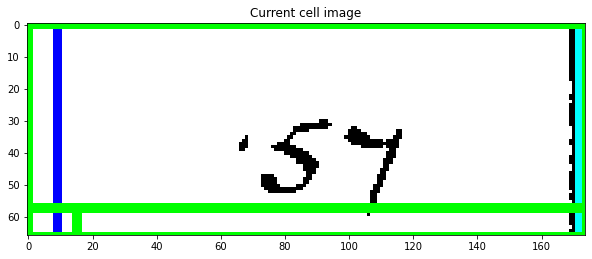

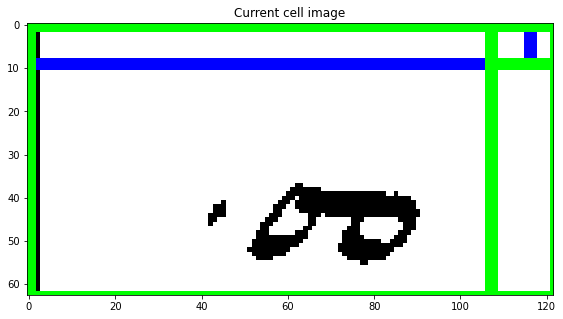

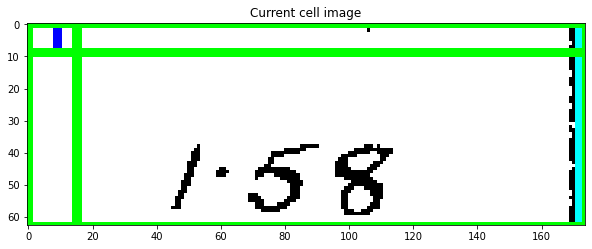

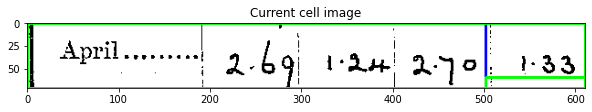

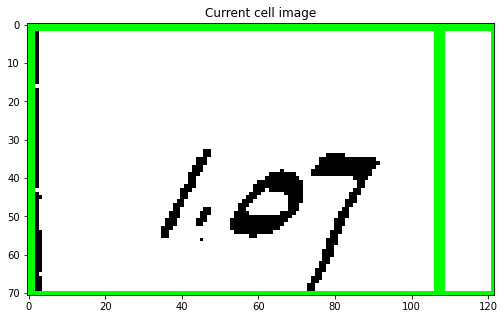

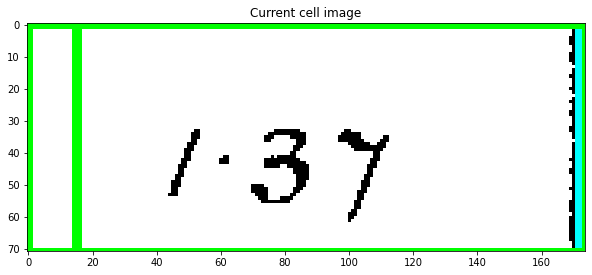

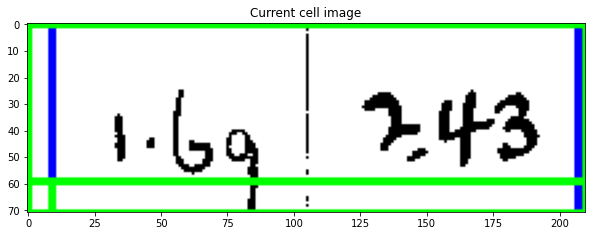

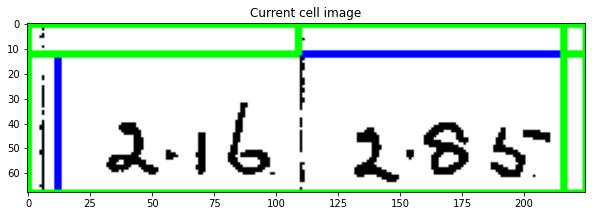

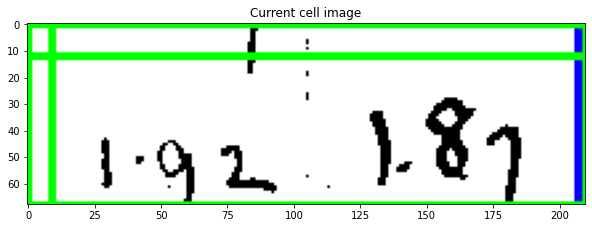

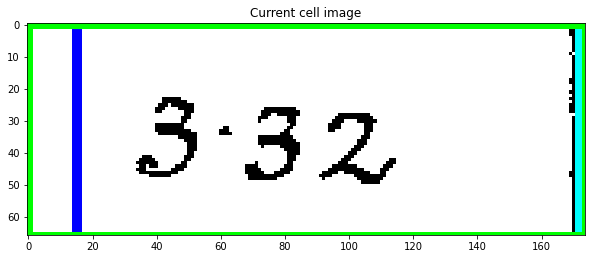

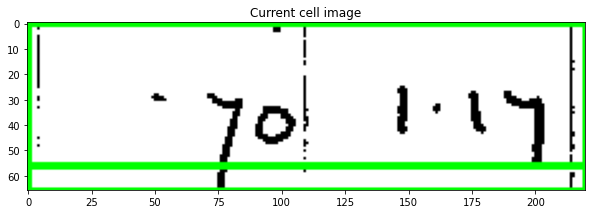

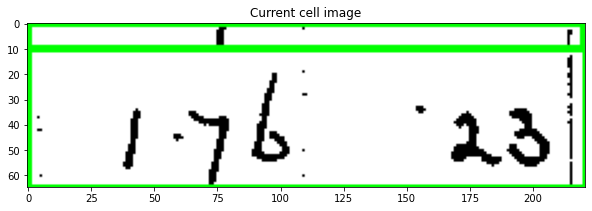

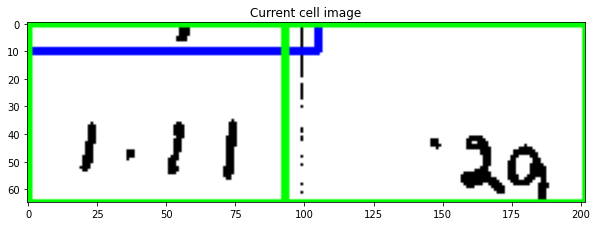

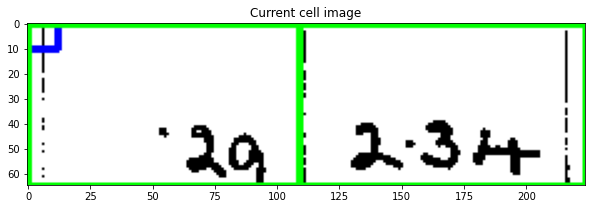

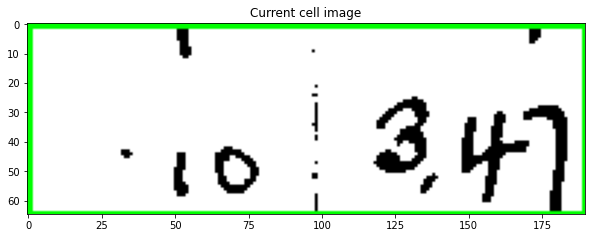

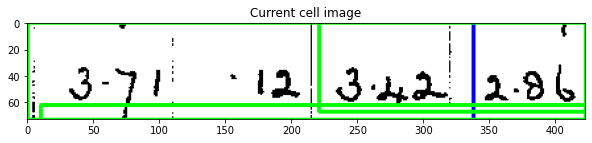

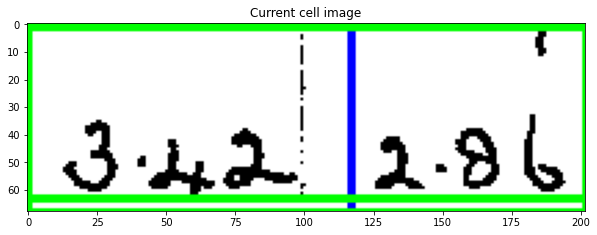

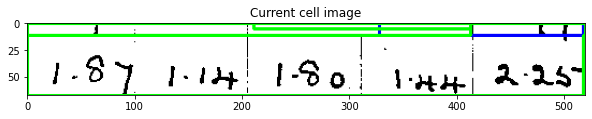

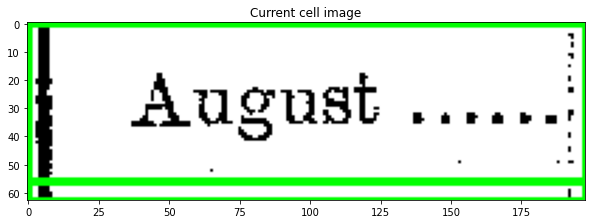

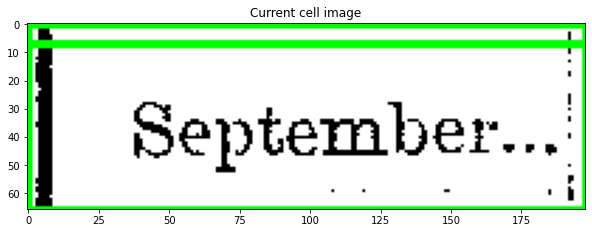

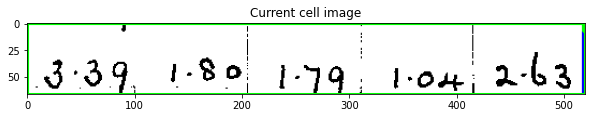

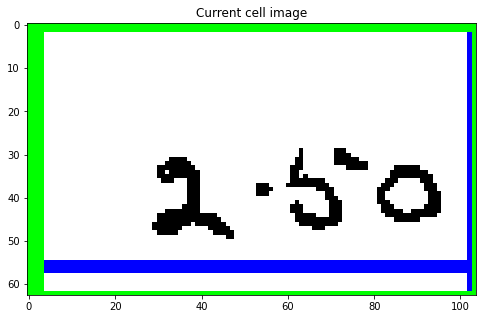

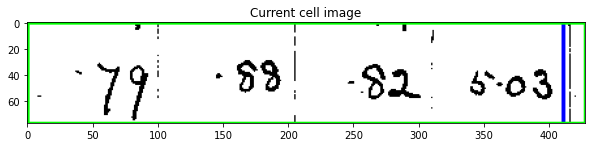

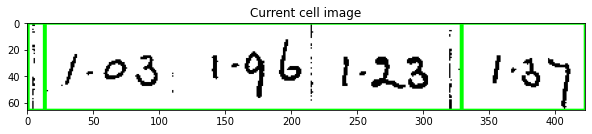

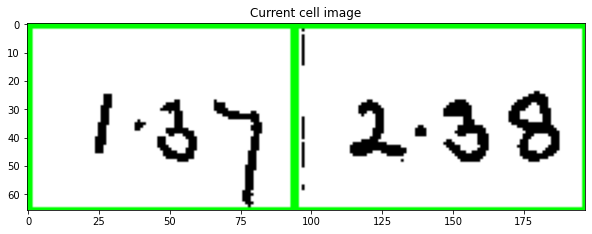

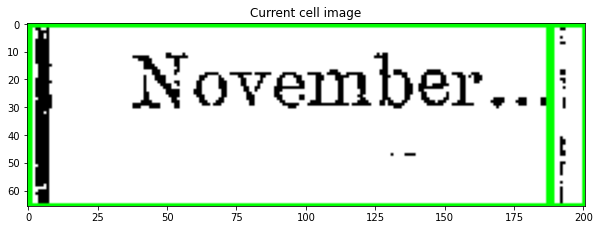

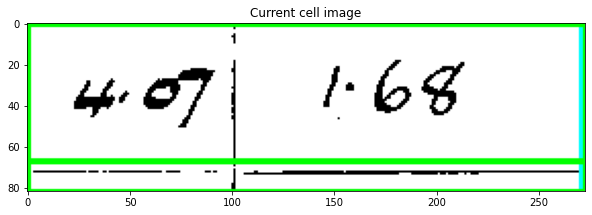

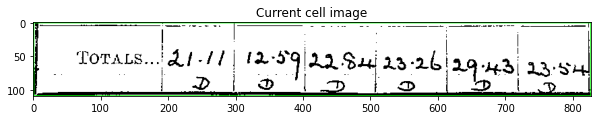

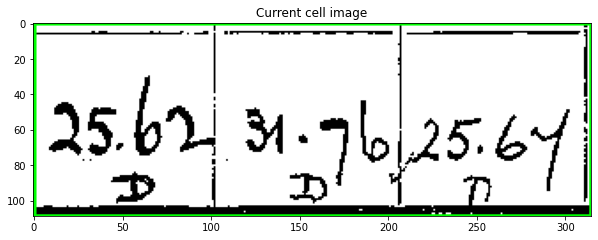

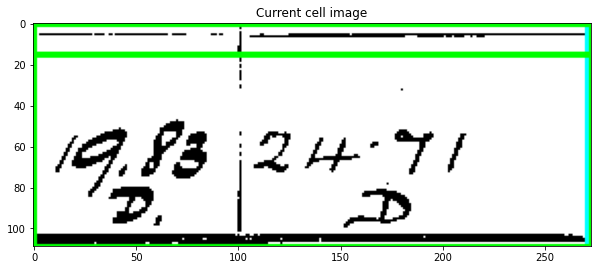

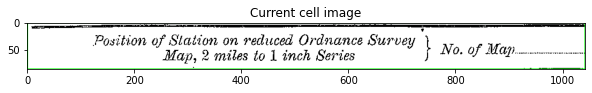

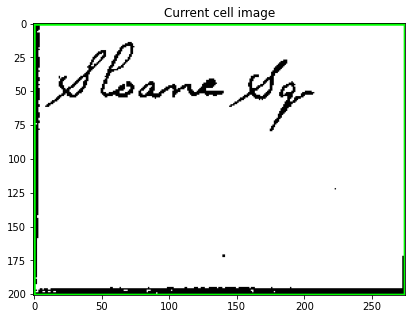

In [28]:
for cell in error_corrected_cells:
    croppedimage_full=image[int(cell[1]):int(cell[3]),int(cell[0]):int(cell[2])]
    plt.rcParams["figure.figsize"] = (10,5)
    plt.imshow(croppedimage_full)
    plt.title(f'Current cell image')
    plt.show()

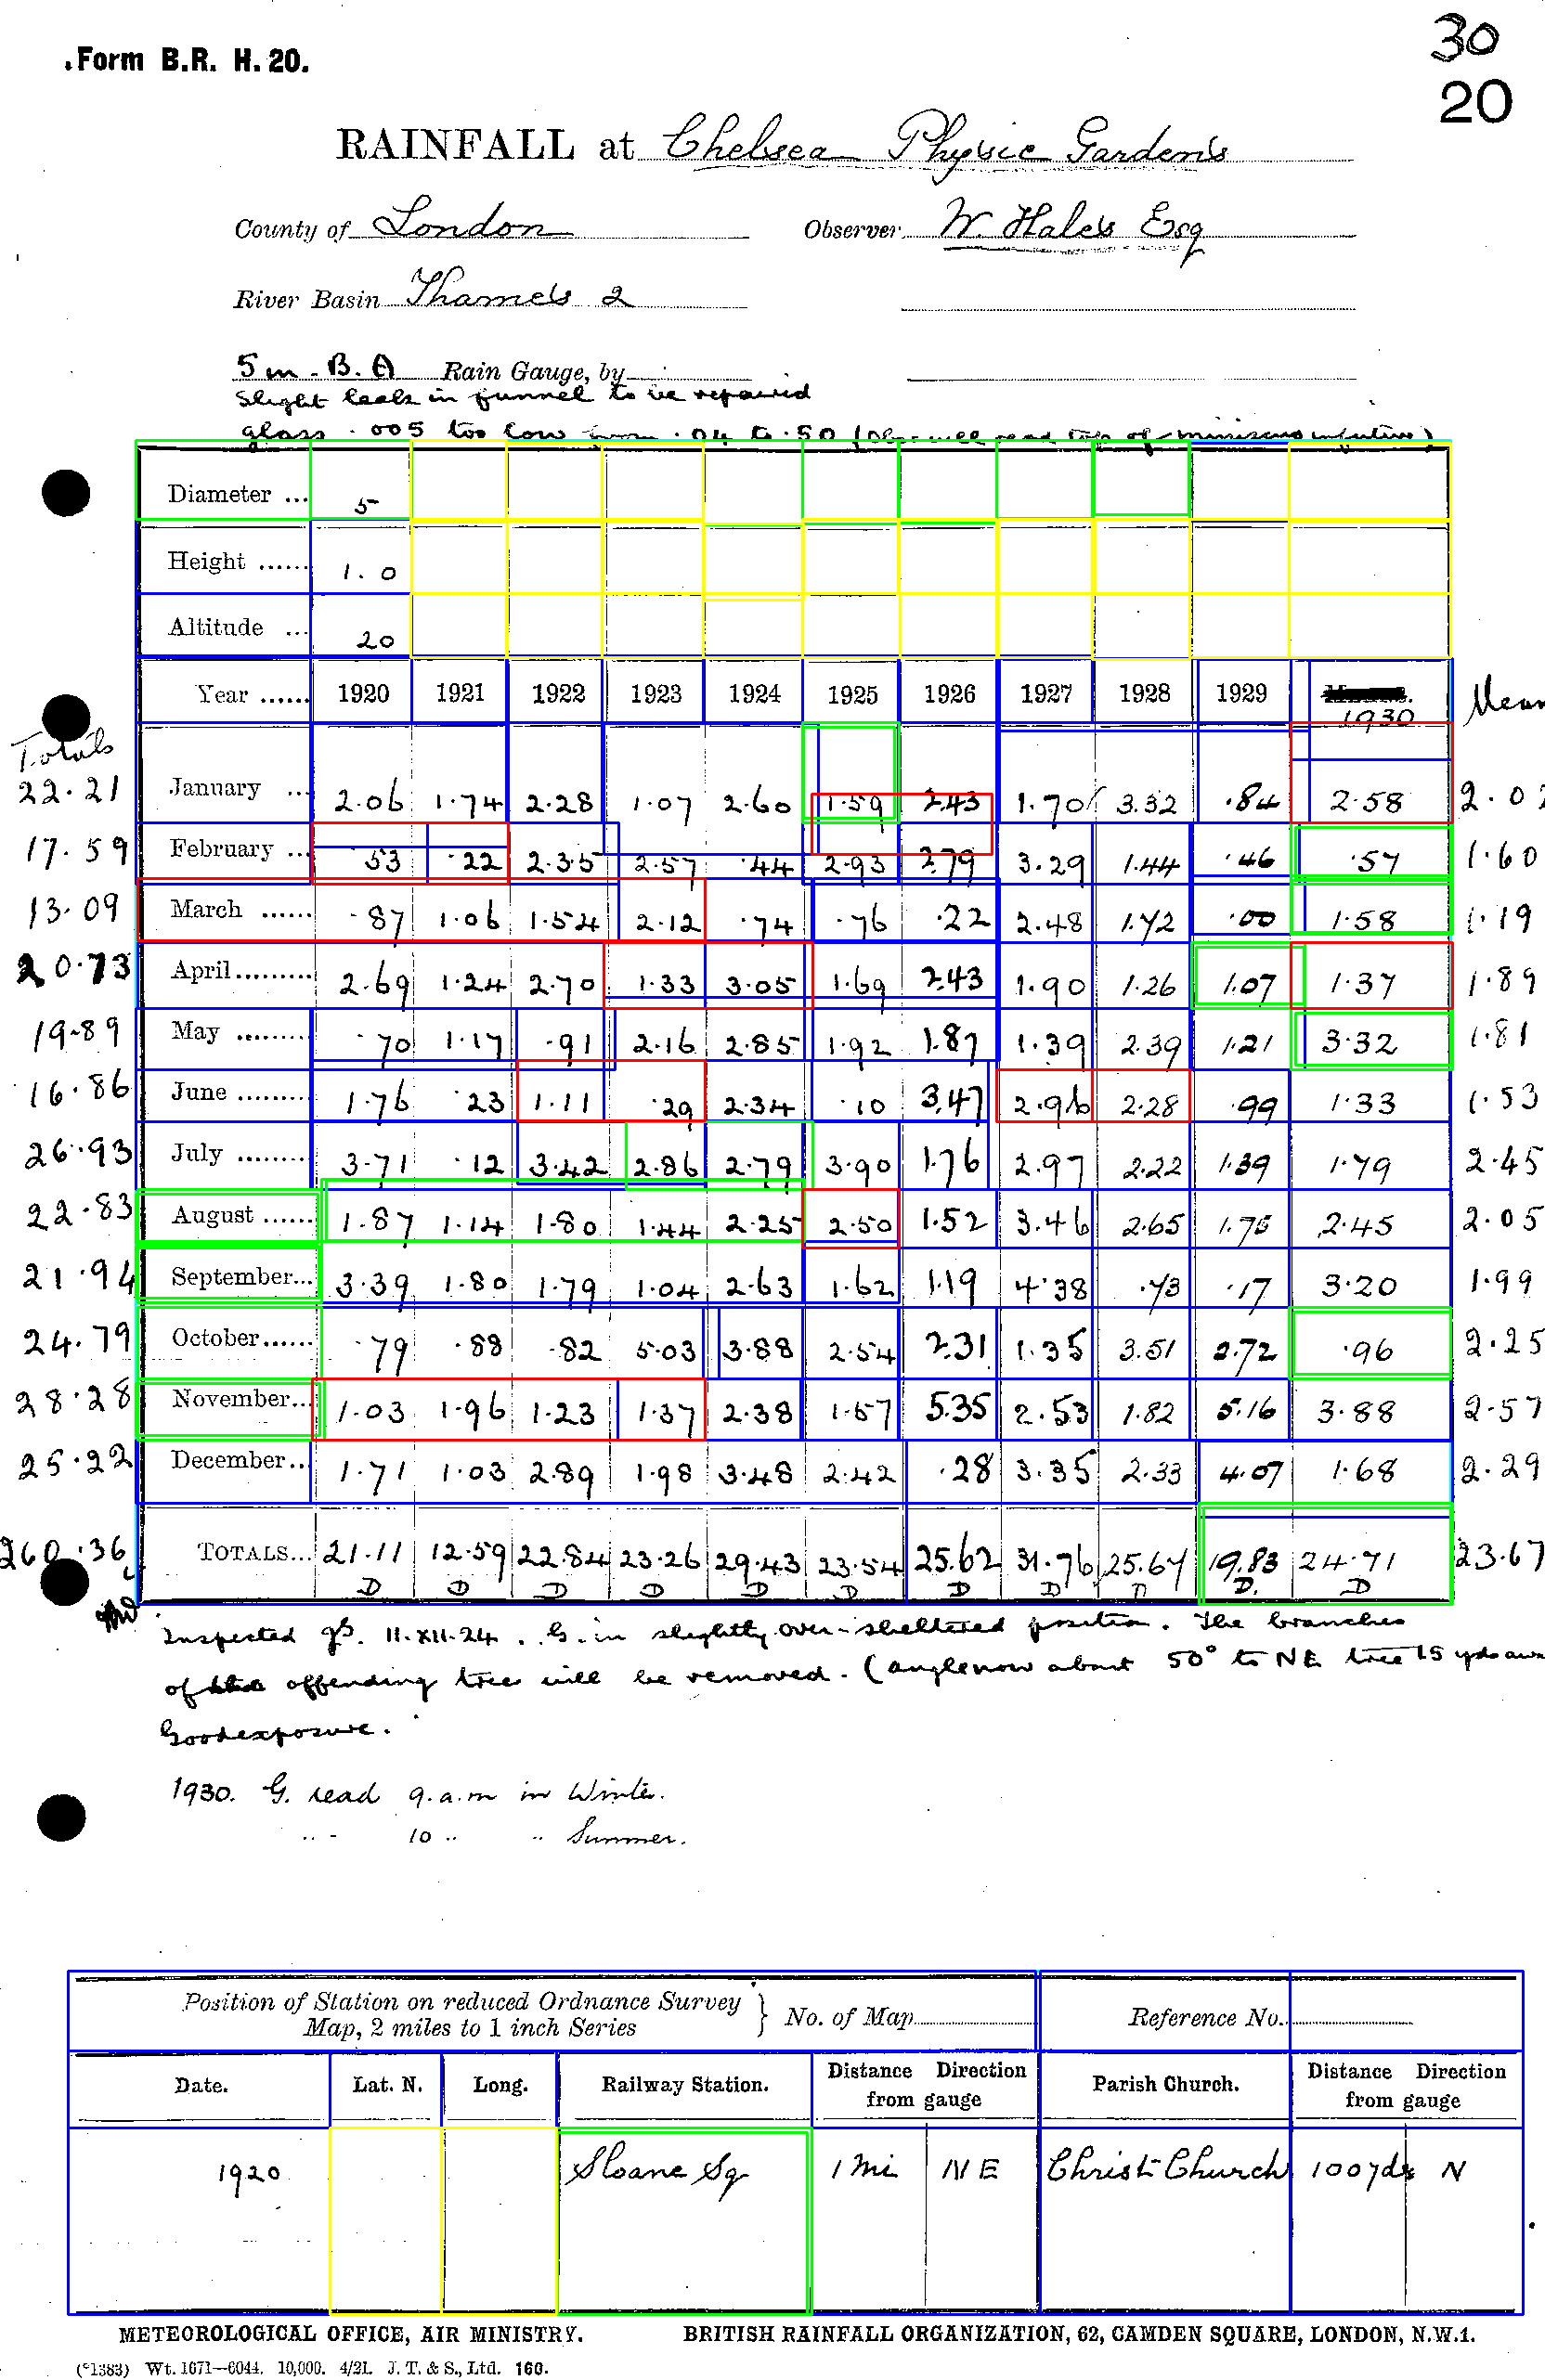

In [42]:
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255
for box in tables:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,color)) # Cyan 
    
for box in correct_cells:
    put_box(image,box,(0,0,color)) # Blue
    
for box in new_corrected_excluded_cells_v2:
    put_box(image,box,(0,color,0)) # Green

for box in exclude_cells_new:
    put_box(image,box,(color,0,0)) # Red
    
# for box in new_corrected_excluded_cells:
#     put_box(image,box,(color,0,color))  # pink
    
for box in blank_cells_new:   
    put_box(image,box,(color,color,0)) # Yellow

im_pil = Image.fromarray(image)
# im_pil.save(f"{filename}_temp_cell_multiple_cell_correction.jpg")
im_pil 